
# Ensemble Techniques

**Data Description**: The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

**Domain**: Banking

**Context**: Leveraging customer information is paramount for most businesses. In the case of a bank, attributes of customers like the ones mentioned below can be crucial in strategizing a marketing campaign when launching a new product.

**Attribute Information**
* **`age`**: age at the time of call
* **`job`**: type of job
* **`marital`**: marital status
* **`education`**: education background at the time of call
* **`default`**: has credit in default?
* **`balance`**: average yearly balance, in euros (numeric)
* **`housing`**: has housing loan?
* **`loan`**: has personal loan?
* **`contact`**: contact communication type
* **`day`**: last contact day of the month (1 -31)
* **`month`**: last contact month of year ('jan', 'feb', 'mar', ..., 'nov', 'dec')
* **`duration`**: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration = 0 then Target = 'no'). Yet, the duration is not known before a call is performed. Also, after the end of the call Target is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
* **`campaign`**: number of contacts performed during this campaign and for this client (includes last contact)
* **`pdays`**: number of days that passed by after the client was last contacted from a previous campaign
* **`previous`**: number of contacts performed before this campaign and for this client
* **`poutcome`**: outcome of the previous marketing campaign
* **`target`**: has the client subscribed a term deposit? ('yes', 'no')

**Learning Outcomes**
* Exploratory Data Analysis
* Preparing the data to train a model
* Training and making predictions using an Ensemble Model
* Tuning an Ensemble model

## Table of Contents
* [Import Packages](#packages)
* [Reading the data as a dataframe and print the first five rows](#reading)
* [Get info of the dataframe columns](#info)
    * [Observation 1 - Dataset shape](#o1)
* [Exploratory Data Analysis](#eda)
    * [Five point summary of numerical attributes and check unique values in 'object' columns](#5point)
        * [Observation 2 - information on the type of variable and min-max values](#o2)
        * [Observation 3 - Descriptive statistics for the numerical variables](#o3)
    * [Checking the distribution of target variable](#target)
        * [Observation 4 - Distribution of target variable](#o4)
    * [Univariate and Bivariate Visualization](#unibi)
        * [Observation 5 - Comments from categorical columns](#o5)
    * [Check outlier and distribution for numerical columns and also plot it's relation with target variable](#outlier)
        * [Observation 6 - Comments from numerical columns](#o6)
    * [Print categorical and numerical columns list, remove outliers with upper and lower percentile values being 99 and 1, respectively and get dummies](#dummies)
    * [Use MICE imputer to handled outliers that were filled with in the earlier step](#mice)
        * [Observation 7 - Observation after MICE](#o7)
    * [Checking whether count of 0 in previous column is equal to count of -1 in pdays column](#pdays)
        * [Observation 8 - pdays and previous](#o8)
    * [Multivariate visualization](#multi)
        * [Check scattermatrix](#scatter)
        * [Correlation matrix](#corr)
            * [Observation 9 - Correlation Matrix](#o9)
    * [Creating age groups and check relation with balance and target; also with campaign and target](#age)
        * [Observation 10 - Comments](#o10)
* [Modelling](#modelling)
    * [Dummy Classifier -- Baseline Model](#dummy)
    * [Standard Models](#sm)
        * [Logistic Regression](#lr)
        * [k-Nearest Neighbor Classifier](#knn)
        * [Naive Bayes Classifier](#nb)
        * [Oversampling and Naive Bayes](#onb)
        * [Oversampling and Logistic Regression](#olr)
    * [Ensemble Techniques](#et)
        * [Decision Tree Classifier](#dt)
        * [Bagging, AdaBoost, Gradient Boosting Classifier](#bag)
        * [Oversampling and AdaBoost Classifier](#oa)
        * [Random Forest Classifier](#rf)
        * [Oversampling and Random Forest Classifier](#orf)
* [Comparing model results](#mr)
* [Conclusion](#conclusion)

<a id='packages'></a>
### Import Packages

In [46]:
!pip install impyute

In [47]:
# Basic packages
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from scipy import stats; from scipy.stats import zscore, norm, randint
import matplotlib.style as style; style.use('fivethirtyeight')
import plotly.express as px
%matplotlib inline

# Impute and Encode
from sklearn.preprocessing import LabelEncoder
from impyute.imputation.cs import mice

# Modelling - LR, KNN, NB, Metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.metrics import make_scorer

# Oversampling
from imblearn.over_sampling import SMOTE

# Suppress warnings
import warnings; warnings.filterwarnings('ignore')

# Visualize Tree
from sklearn.tree import export_graphviz
from IPython.display import Image
from os import system

# Display settings
pd.options.display.max_rows = 10000
pd.options.display.max_columns = 10000

random_state = 42
np.random.seed(random_state)

<a id='reading'></a>
### Reading the data as a dataframe and print the first five rows

In [48]:
# Reading the data as dataframe and print the first five rows
bank = pd.read_csv('bank-full.csv')
bank.head()

age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome Target  
0  unknown    5   may       261         1     -1         0  unknown     no  
1  unknown    5   may       151         1     -1         0  unknown     no  
2  unknown    5   may        76         1     -1         0  unknown     no  
3  unknown    5   may        92         1     -1         0  unknown     no  
4  unknown    5   may       198         1     -1         0  unknown     no

<a id='info'></a>
### Get info of the dataframe columns

In [49]:
# Get info of the dataframe columns
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  Target     45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


<a id='o1'></a>
#### Observation 1 - Dataset shape
Dataset has 45211 rows and 17 columns, with no missing values.

<a id='eda'></a>
## Exploratory Data Analysis
Performing exploratory data analysis on the bank dataset. Below are some of the steps performed:

* Get descriptive statistics including five point summary
* Check unique values in `object` columns
* Check distribution of Target column
* Count plot by Target for categorical columns (`job`, `marital`, `education`, `default`, `housing`, `loan`, `contact`, `day`, `month`, `poutcome`)
* Check outliers in each numerical columna (`age`, `balance`, `duration`, `campaign`, `pdays`, `previous`)
* Distribution of numerical columns (with and without outliers)
* Distribution of numerical columns for Target values (subscribed and didn`t subscribed to term deposit)
* Fill outliers with upper and lower percentile values being 99 and 1, respectively by nan values
* Frequency encoding for categorical columns with string values
* Convert type of categorical columns (`job`, `marital`, `education`, `default`, `housing`, `loan`, `contact`, `day`, `month`, `poutcome`, `Target`) to float for MICE training. Creating multiple imputations, as opposed to single imputations to `complete` datasets, accounts for the statistical uncertainty in the imputations. MICE algorithms works by running multiple regression models and each missing value is modeled conditionally depeding on the observed (non-missing) values.
* Get correlation matrix and check absolute correlation of independent variables with `Target`. Drop columns based on these.
* Create age groups and check if there is relation with balance and target, campaign and target.

<a id='5point'></a>
### Five point summary of numerical attributes and check unique values in 'object' columns

In [50]:
bank.describe(include = 'all').T

count unique          top   freq         mean          std  \
age        45211.0    NaN          NaN    NaN     40.93621    10.618762   
job          45211     12  blue-collar   9732          NaN          NaN   
marital      45211      3      married  27214          NaN          NaN   
education    45211      4    secondary  23202          NaN          NaN   
default      45211      2           no  44396          NaN          NaN   
balance    45211.0    NaN          NaN    NaN  1362.272058  3044.765829   
housing      45211      2          yes  25130          NaN          NaN   
loan         45211      2           no  37967          NaN          NaN   
contact      45211      3     cellular  29285          NaN          NaN   
day        45211.0    NaN          NaN    NaN    15.806419     8.322476   
month        45211     12          may  13766          NaN          NaN   
duration   45211.0    NaN          NaN    NaN    258.16308   257.527812   
campaign   45211.0    NaN          NaN    NaN     2.763841     3.098021   
pdays      45211.0    NaN          NaN    NaN    40.197828   100.128746   
previous   45211.0    NaN          NaN    NaN     0.580323     2.303441   
poutcome     45211      4      unknown  36959          NaN          NaN   
Target       45211      2           no  39922          NaN          NaN   

              min    25%    50%     75%       max  
age          18.0   33.0   39.0    48.0      95.0  
job           NaN    NaN    NaN     NaN       NaN  
marital       NaN    NaN    NaN     NaN       NaN  
education     NaN    NaN    NaN     NaN       NaN  
default       NaN    NaN    NaN     NaN       NaN  
balance   -8019.0   72.0  448.0  1428.0  102127.0  
housing       NaN    NaN    NaN     NaN       NaN  
loan          NaN    NaN    NaN     NaN       NaN  
contact       NaN    NaN    NaN     NaN       NaN  
day           1.0    8.0   16.0    21.0      31.0  
month         NaN    NaN    NaN     NaN       NaN  
duration      0.0  103.0  180.0   319.0    4918.0  
campaign      1.0    1.0    2.0     3.0      63.0  
pdays        -1.0   -1.0   -1.0    -1.0     871.0  
previous      0.0    0.0    0.0     0.0     275.0  
poutcome      NaN    NaN    NaN     NaN       NaN  
Target        NaN    NaN    NaN     NaN       NaN

In [51]:
columns = bank.loc[:, bank.dtypes == 'object'].columns.tolist()
for cols in columns:
    print(f'Unique values for {cols} is \n{bank[cols].unique()}\n')

Unique values for job is 
['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']

Unique values for marital is 
['married' 'single' 'divorced']

Unique values for education is 
['tertiary' 'secondary' 'unknown' 'primary']

Unique values for default is 
['no' 'yes']

Unique values for housing is 
['yes' 'no']

Unique values for loan is 
['no' 'yes']

Unique values for contact is 
['unknown' 'cellular' 'telephone']

Unique values for month is 
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']

Unique values for poutcome is 
['unknown' 'failure' 'other' 'success']

Unique values for Target is 
['no' 'yes']



<a id='o2'></a>
#### Observation 2 - information on the type of variable and min-max values

##### Client info
* **Categorical**
	* **`job`**: Nominal. Includes type of job. 'blue-collar' is the most frequently occurring in the data.
	* **`marital`**: Nominal. Most of the clients are married in the dataset we have.
	* **`education`**: Ordinal. Most of the clients have secondary level education.
	* **`default`**: Binary. Most of clients don't have credit in default.
	* **`housing`**: Binary. Most of the clients have housing loan.
	* **`loan`**: Binary. Most of the clients don't have personal loan.

* **Numerical**
	* **`age`**: Continuous, ratio (has true zero, technically). Whether it's discrete or continuous depends on whether they are measured to the nearest year or not. At present, it seems it's discrete. Min age in the dataset being 18 and max being 95.
	* **`balance`**: Continuous, ratio. Range of average yearly balance is very wide from -8019 euros to 102127 euros.

##### Last contact info
* **Categorical**
	* **`contact`**: Nominal. Includes communication type with the client, most frequently use communication mode is cellular.
	* **`day`**: Ordinal. Includes last contact day of the month.
	* **`month`**: Ordinal. Includes last contact month of the year.

* **Numerical**
    * **`duration`**: Continuous, interval. Includes last contact duration in seconds. Min value being 0 and max value being 4918. It would be important to check is higher duration of call leading to more subscription.

##### This campaign info
* **Numerical**
	* **`campaign`**: Discrete, interval. Min number of contacts performed during this campaign being 1 and is also represents about 25% of the value and max being 63.

##### Previous campaign info
* **Categorical**
	* **`poutcome`**: Nominal. Includes outcome of the previous marketing campaign. Most occuring value being 'unknown'.

* **Numerical**
	* **`pdays`**: Continuous, interval. Min number of days that passed by after the client was last contacted from a previous campaign being -1 which may be dummy value for the cases where client wasn't contacted and max days being 63.
	* **`previous`**: Discrete, ratio. Min number of contacts performed before this campaign is 0 and max being 275.

##### Target
* **Categorical**
	* **`Target`**: Binary. Most occurring value being 'no' i.e. cases where the client didn't subscribe to the term deposit.

<a id='o3'></a>
#### Observation 3 - Descriptive statistics for the numerical variables
Descriptive statistics for the numerical variables (age, balance, duration, campaign, pdays, previous)
* **`age`**: Range of Q1 to Q3 is between 33 to 48. Since mean is slightly greater than median, we can say that age is right (positively) skewed.
* **`balance`**: Range of Q1 to Q3 is between 72 to 1428. Since mean is greater than median, we can say that balance is skewed towards right (positively).
* **`duration`**: Range of Q1 to Q3 is between 103 to 319. Since mean is greater than median, we can say that duration is right (positively) skewed.
* **`campaign`**: Range of Q1 to Q3 is between 1 to 3. Since mean is greater than median, we can say that campaign is right (positively) skewed.
* **`pdays`**: 75% of data values are around -1 which is a dummy value. It needs further check without considering the -1 value.
* **`previous`**: 75% of data values are around 0 which is a dummy value, maybe cases where client wasn't contacted. It needs further checks.

<a id='target'></a>
### Checking the distribution of target variable

In [52]:
display(bank['Target'].value_counts(), bank['Target'].value_counts(normalize = True)*100)

no     39922
yes     5289
Name: Target, dtype: int64

no     88.30152
yes    11.69848
Name: Target, dtype: float64

<a id='o4'></a>
#### Observation 4 - Distribution of target variable
Out of 45211 cases, only 5289 (=11.69%) are the cases where the client has subscribed to the term deposit.

In [53]:
# Replace values in some of the categorical columns
replace_values = {'education': {'unknown': -1, 'primary': 1, 'secondary': 2, 'tertiary': 3}, 'Target': {'no': 0, 'yes': 1},
                  'default': {'no': 0, 'yes': 1}, 'housing': {'no': 0, 'yes': 1}, 'loan': {'no': 0, 'yes': 1},
                  'month': {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 
                            'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}}

bank = bank.replace(replace_values)

In [54]:
# Convert columns to categorical types
columns.extend(['day'])
for cols in columns:
    bank[cols] = bank[cols].astype('category')

In [55]:
# Functions that will help us with EDA plot
def odp_plots(df, col):
    f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 7.2))
    
    # Boxplot to check outliers
    sns.boxplot(x = col, data = df, ax = ax1, orient = 'v', color = 'darkslategrey')
    
    # Distribution plot with outliers
    sns.distplot(df[col], ax = ax2, color = 'teal', fit = norm).set_title(f'Distribution of {col} with outliers')
    
    # Removing outliers, but in a new dataframe
    upperbound, lowerbound = np.percentile(df[col], [1, 99])
    y = pd.DataFrame(np.clip(df[col], upperbound, lowerbound))
    
    # Distribution plot without outliers
    sns.distplot(y[col], ax = ax3, color = 'tab:orange', fit = norm).set_title(f'Distribution of {col} without outliers')
    
    kwargs = {'fontsize':14, 'color':'black'}
    ax1.set_title(col + ' Boxplot Analysis', **kwargs)
    ax1.set_xlabel('Box', **kwargs)
    ax1.set_ylabel(col + ' Values', **kwargs)

    return plt.show()
    
def target_plot(df, col, target = 'Target'):
    fig = plt.figure(figsize = (15, 7.2))
    # Distribution for 'Target' -- didn't subscribed, considering outliers   
    ax = fig.add_subplot(121)
    sns.distplot(df[(df[target] == 0)][col], color = 'c', 
                 ax = ax).set_title(f'{col.capitalize()} for Term Desposit - Didn\'t subscribed')

    # Distribution for 'Target' -- Subscribed, considering outliers
    ax= fig.add_subplot(122)
    sns.distplot(df[(df[target] == 1)][col], color = 'b', 
             ax = ax).set_title(f'{col.capitalize()} for Term Desposit - Subscribed')
    return plt.show()

def target_count(df, col1, col2):
    fig = plt.figure(figsize = (15, 7.2))
    ax = fig.add_subplot(121)
    sns.countplot(x = col1, data = df, palette = ['tab:blue', 'tab:cyan'], ax = ax, orient = 'v',
                  hue = 'Target').set_title(col1.capitalize() +' count plot by Target', 
                                                                      fontsize = 13)
    plt.legend(labels = ['Didn\'t Subcribed', 'Subcribed'])
    plt.xticks(rotation = 90)
    
    ax = fig.add_subplot(122)
    sns.countplot(x = col2, data = df, palette = ['tab:blue', 'tab:cyan'], ax = ax, orient = 'v', 
                  hue = 'Target').set_title(col2.capitalize() +' coount plot by Target', 
                                                                      fontsize = 13)
    plt.legend(labels = ['Didn\'t Subcribed', 'Subcribed'])
    plt.xticks(rotation = 90)
    return plt.show()

<a id='unibi'></a>
## Univariate and Bivariate Visualization
Looking at one feature at a time to understand how are the values distributed, checking outliers, checking relation of the column with Target column (bi).

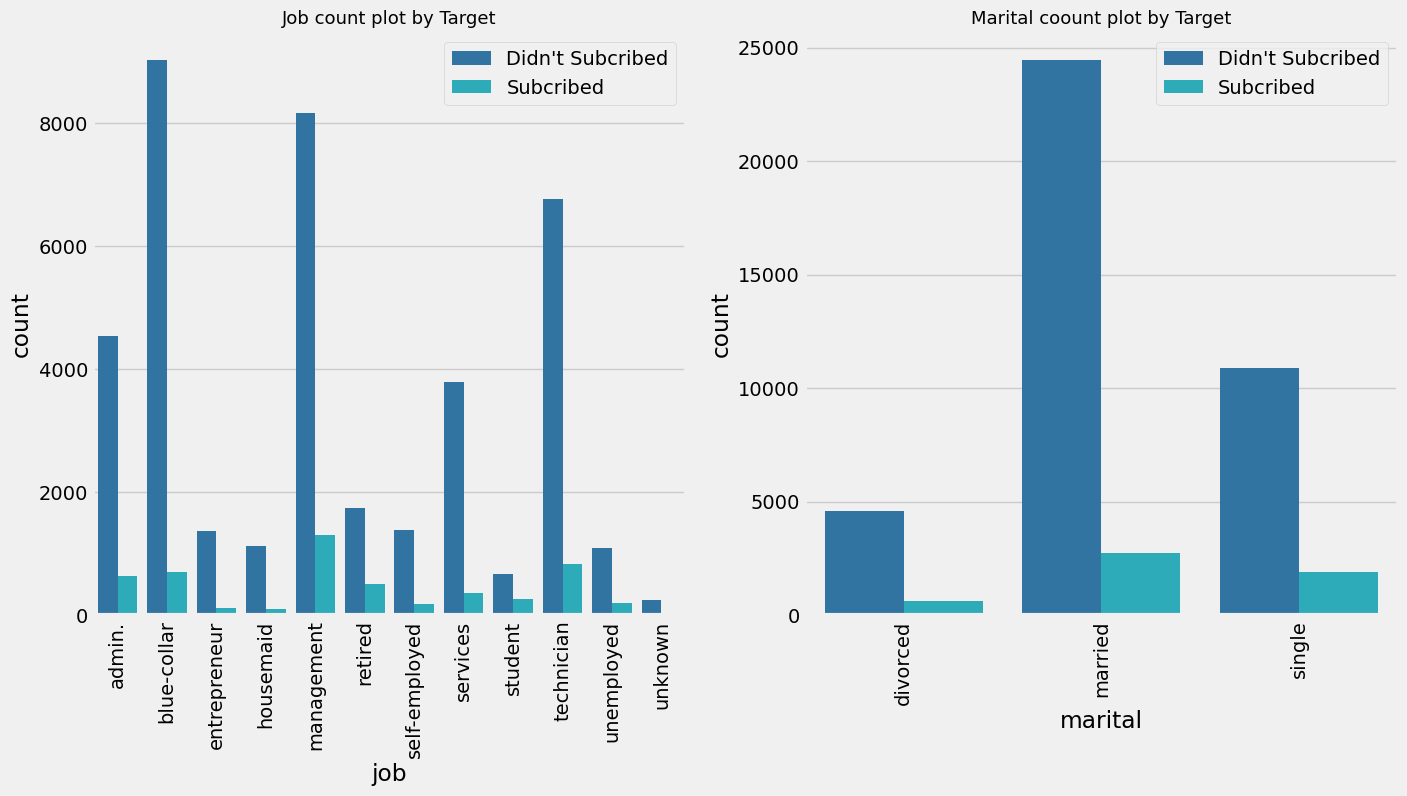

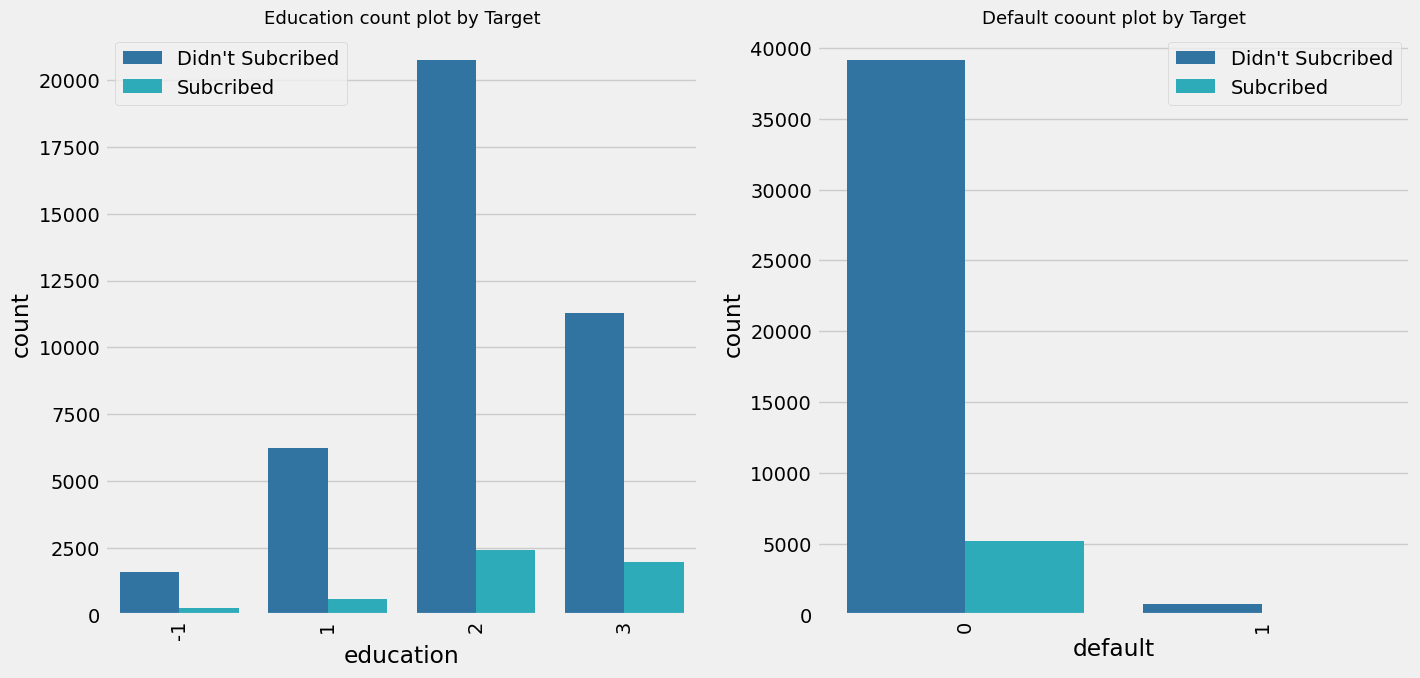

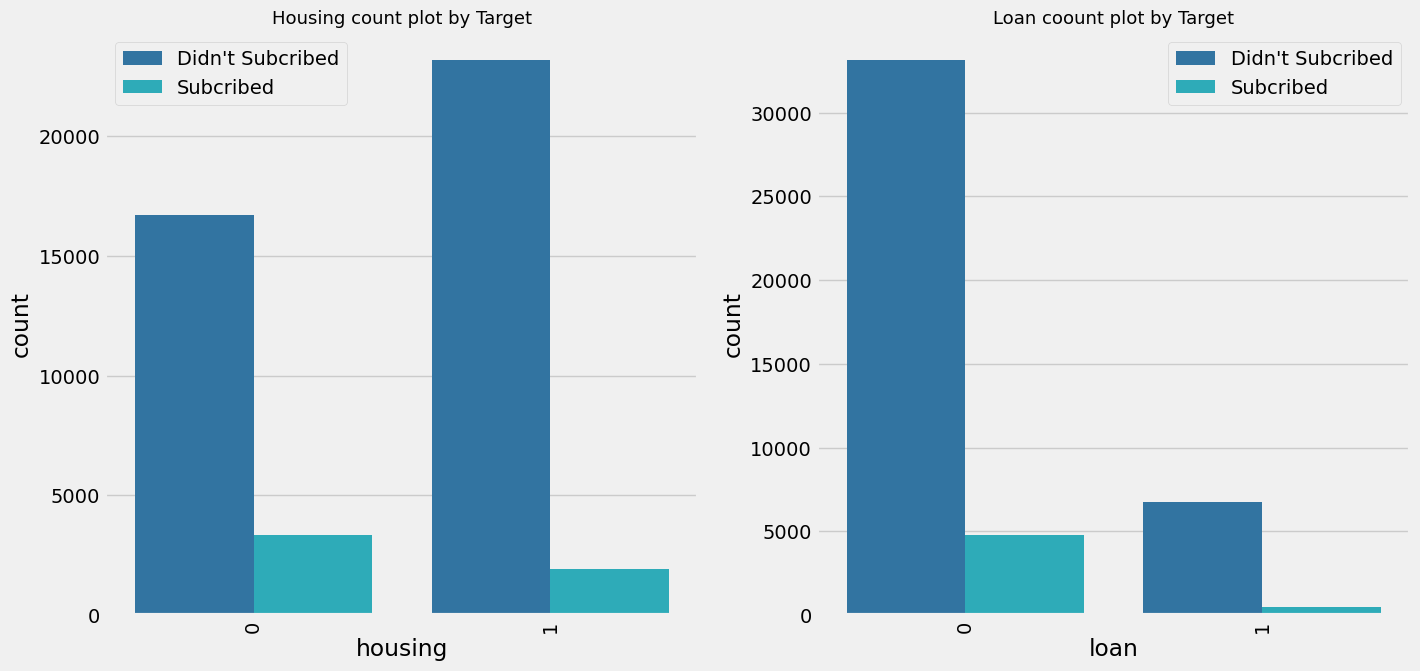

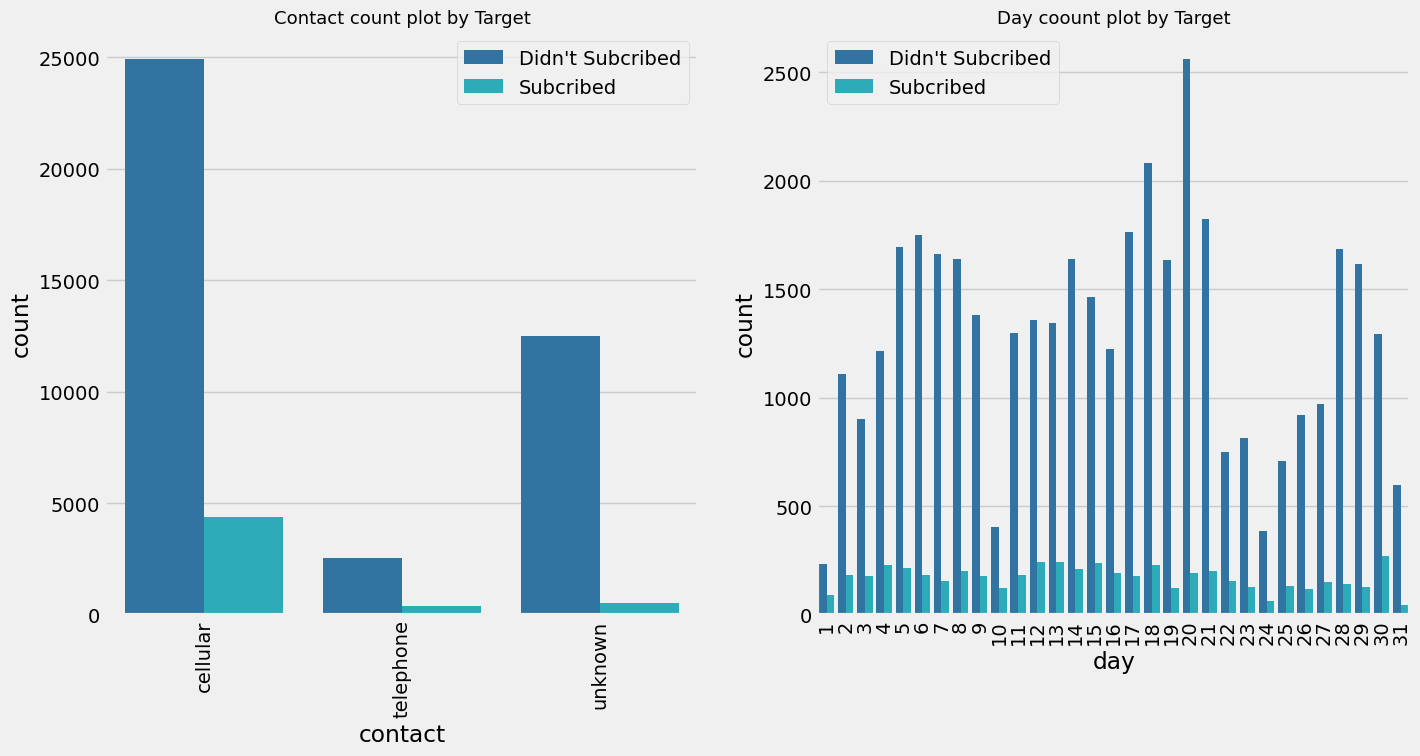

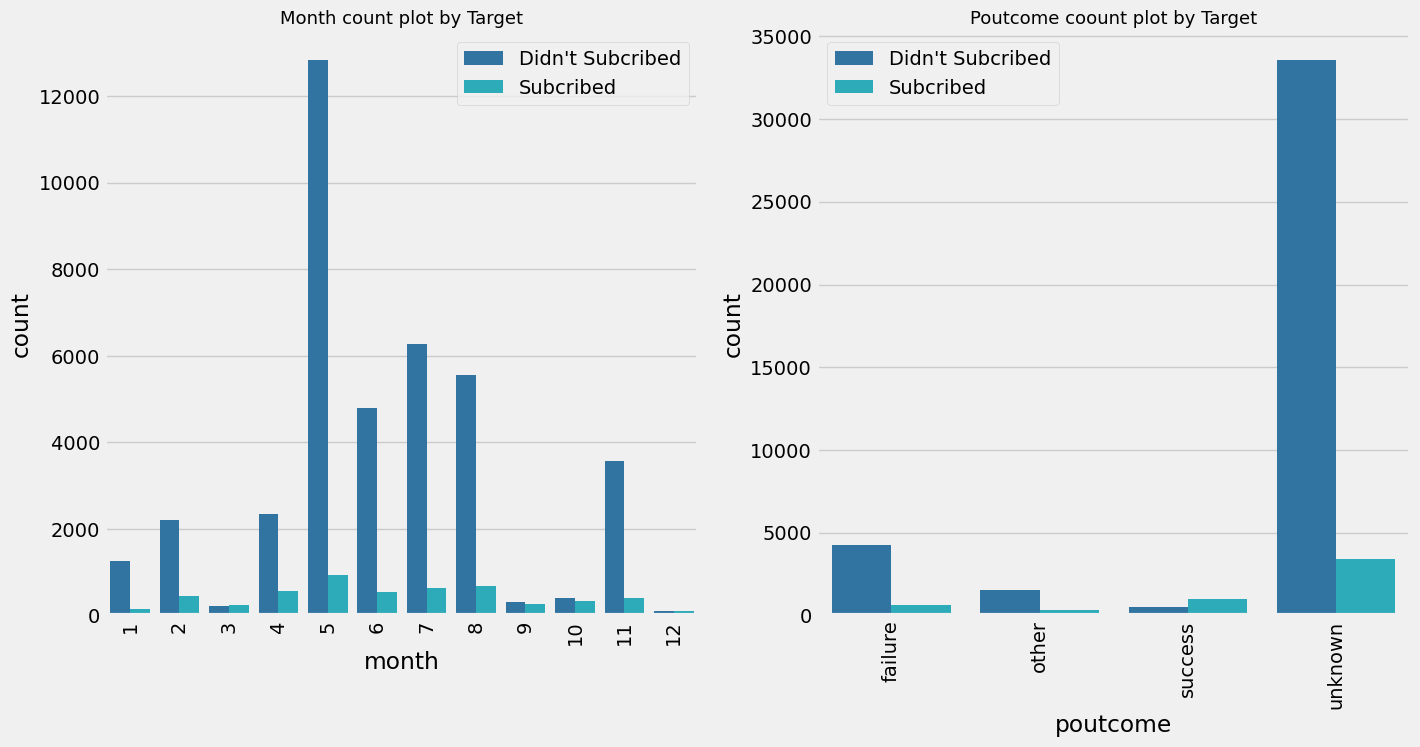

In [56]:
# Subscribe and didn't subscribe for categorical columns
target_count(bank, 'job', 'marital')
target_count(bank, 'education', 'default')
target_count(bank, 'housing', 'loan')
target_count(bank, 'contact', 'day')
target_count(bank, 'month', 'poutcome')

<a id='o5'></a>
#### Observation 5 - Comments from categorical columns
* Management have a subscription rate of ~25 percent followed by technician.
* Married and single clients are more likely to subscribe then divorced clients
* Clients with education of secondary followed by tertiary are more likely to subscribe to term deposits
* Most of the clients don't have credit in default and their subscription rate is higher then people with default
* Cellular communication type have higher subscription rate
* Most of the subscription were made in May and August

<a id='outlier'></a>
### Check outlier and distribution for numerical columns and also plot it's relation with target variable

Age column --------------------------------------------------------------------------------------------------------------


age      job   marital education default  balance housing loan  \
29158   83  retired   married         1       0      425       0    0   
29261   75  retired  divorced         1       0       46       0    0   
29263   75  retired   married         1       0     3324       0    0   
29322   83  retired   married         3       0     6236       0    0   
29865   75  retired  divorced         1       0     3881       1    0   

         contact day month  duration  campaign  pdays  previous poutcome  \
29158  telephone   2     2       912         1     -1         0  unknown   
29261   cellular   2     2       294         1     -1         0  unknown   
29263   cellular   2     2       149         1     -1         0  unknown   
29322   cellular   2     2       283         2     -1         0  unknown   
29865   cellular   4     2       136         3     -1         0  unknown   

      Target  
29158      0  
29261      0  
29263      0  
29322      0  
29865      1

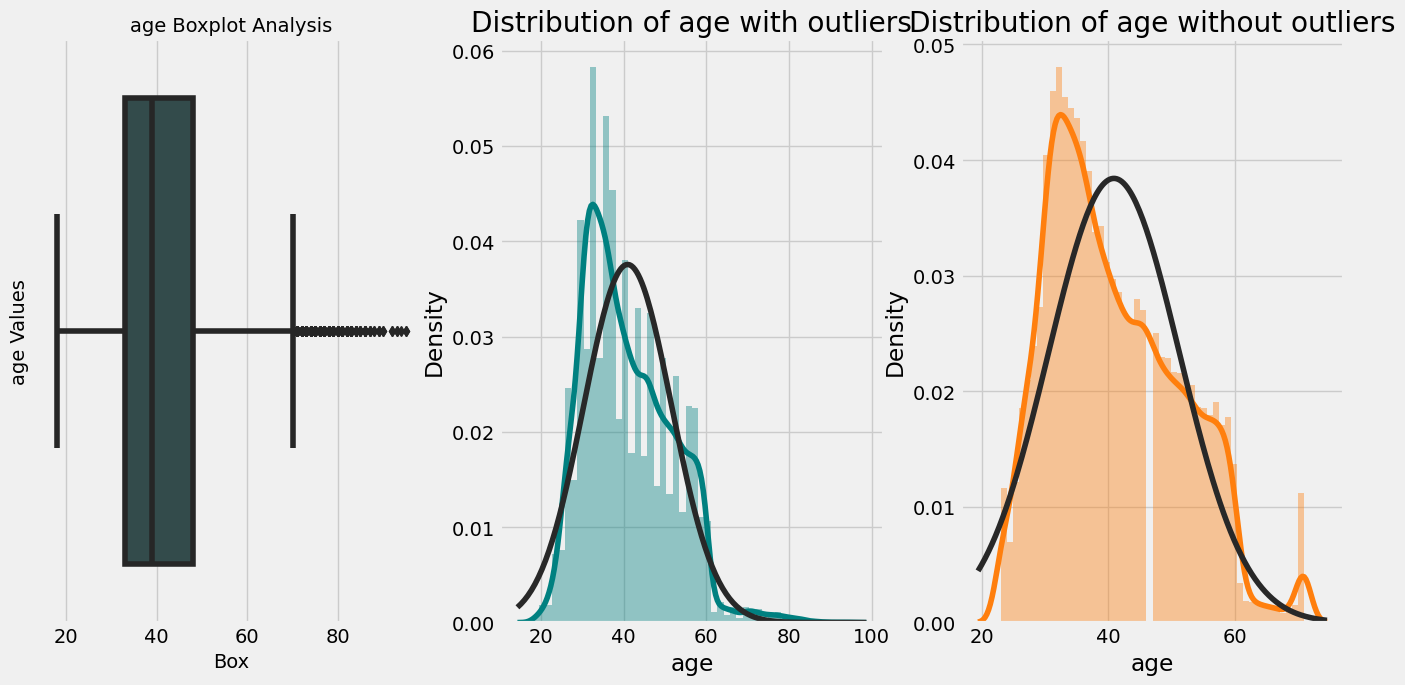

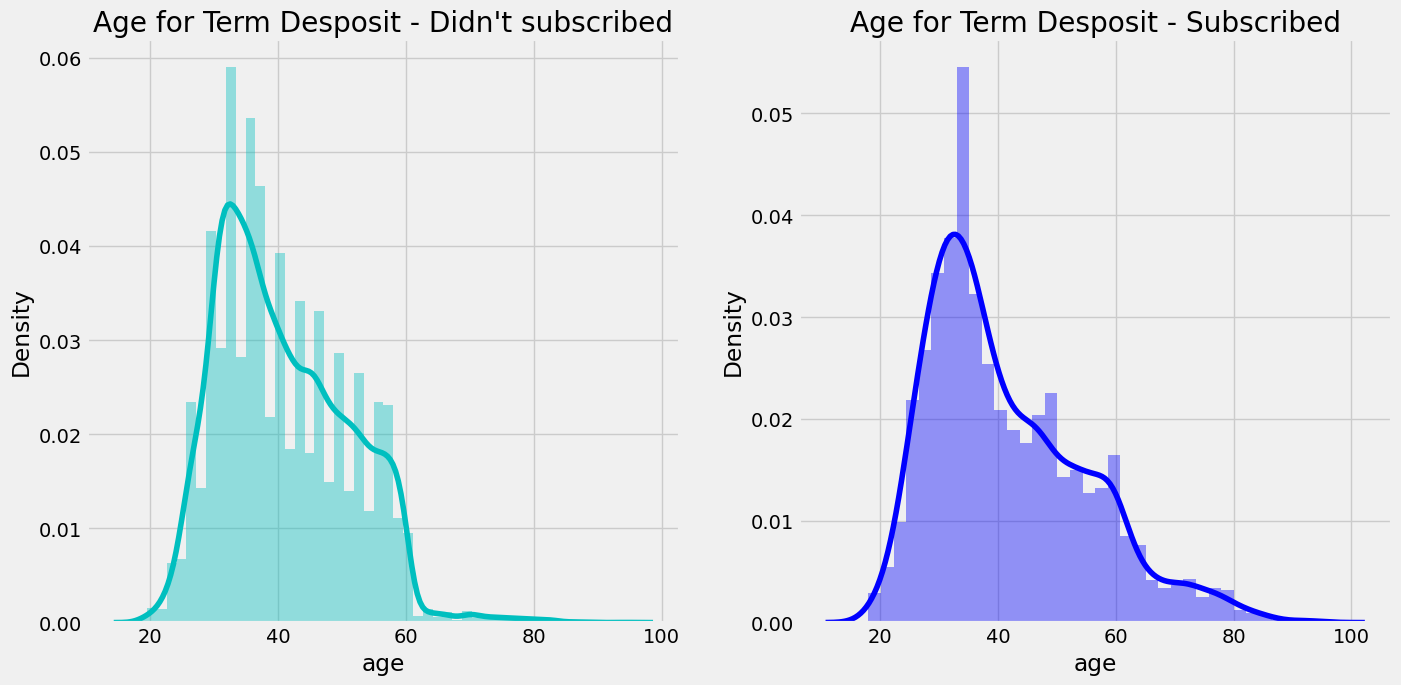

In [57]:
# Outlier, distribution for 'age' column
Q3 = bank['age'].quantile(0.75)
Q1 = bank['age'].quantile(0.25)
IQR = Q3 - Q1

print('Age column', '--'*55)
display(bank.loc[(bank['age'] < (Q1 - 1.5 * IQR)) | (bank['age'] > (Q3 + 1.5 * IQR))].head())

odp_plots(bank, 'age')

# Distribution of 'age' by 'Target'
target_plot(bank, 'age')

Balance column --------------------------------------------------------------------------------------------------------------


age          job   marital education default  balance housing loan  \
34    51   management   married         3       0    10635       1    0   
65    51   management   married         3       0     6530       1    0   
69    35  blue-collar    single         2       0    12223       1    1   
70    57  blue-collar   married         2       0     5935       1    1   
186   40     services  divorced        -1       0     4384       1    0   

     contact day month  duration  campaign  pdays  previous poutcome Target  
34   unknown   5     5       336         1     -1         0  unknown      0  
65   unknown   5     5        91         1     -1         0  unknown      0  
69   unknown   5     5       177         1     -1         0  unknown      0  
70   unknown   5     5       258         1     -1         0  unknown      0  
186  unknown   5     5       315         1     -1         0  unknown      0

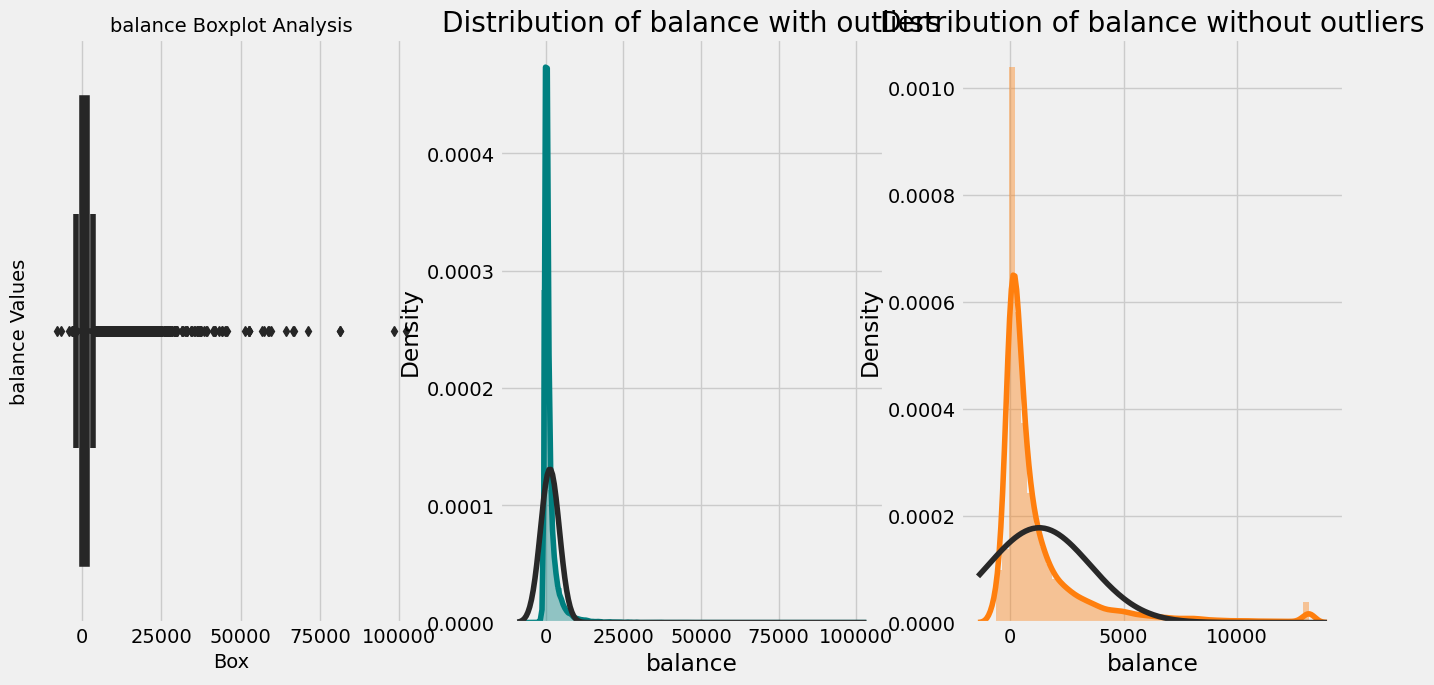

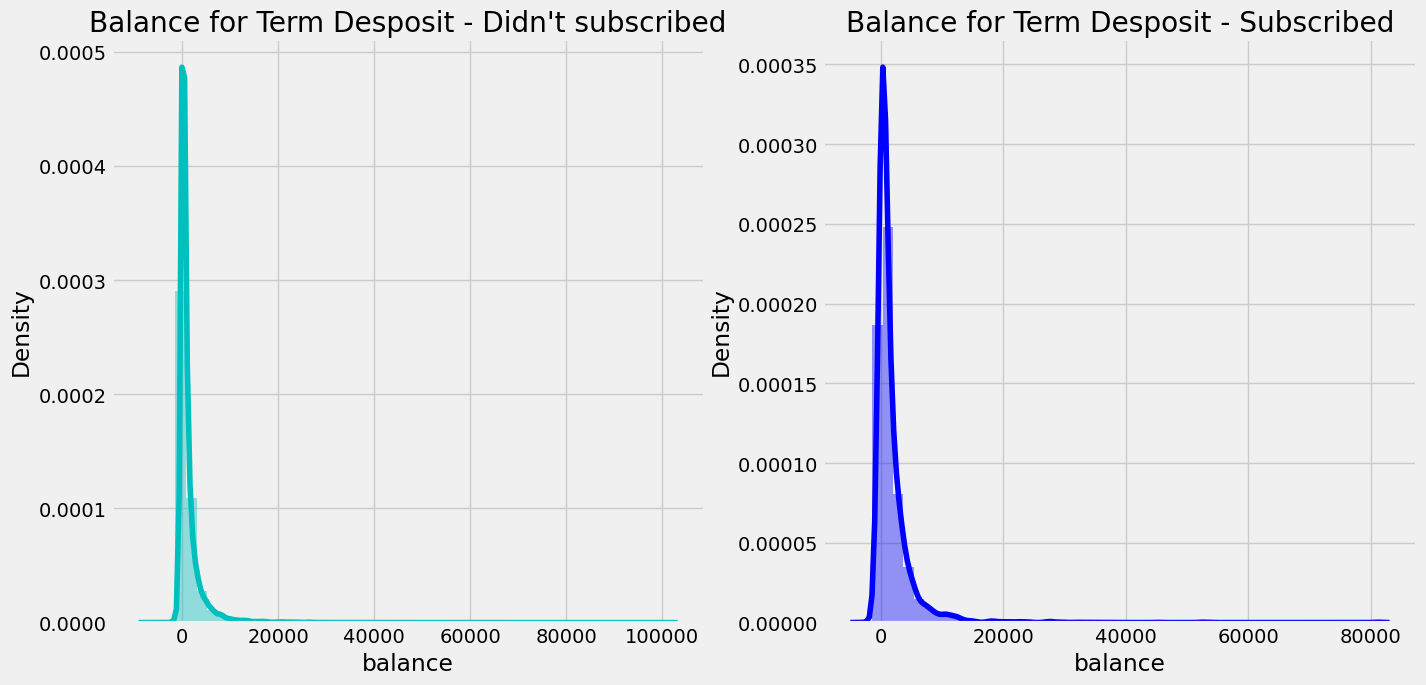

In [58]:
# Outlier, distribution for 'balance' column
Q3 = bank['balance'].quantile(0.75)
Q1 = bank['balance'].quantile(0.25)
IQR = Q3 - Q1
print('Balance column', '--'*55)
display(bank.loc[(bank['balance'] < (Q1 - 1.5 * IQR)) | (bank['balance'] > (Q3 + 1.5 * IQR))].head())

odp_plots(bank, 'balance')

# Distribution of 'balance' by 'Target'
target_plot(bank, 'balance')

Duration column ------------------------------------------------------------------------------------------------------------


age         job   marital education default  balance housing loan  \
37   53  technician   married         2       0       -3       0    0   
43   54     retired   married         2       0      529       1    0   
53   42      admin.    single         2       0      -76       1    0   
59   46    services   married         1       0      179       1    0   
61   53  technician  divorced         2       0      989       1    0   

    contact day month  duration  campaign  pdays  previous poutcome Target  
37  unknown   5     5      1666         1     -1         0  unknown      0  
43  unknown   5     5      1492         1     -1         0  unknown      0  
53  unknown   5     5       787         1     -1         0  unknown      0  
59  unknown   5     5      1778         1     -1         0  unknown      0  
61  unknown   5     5       812         1     -1         0  unknown      0

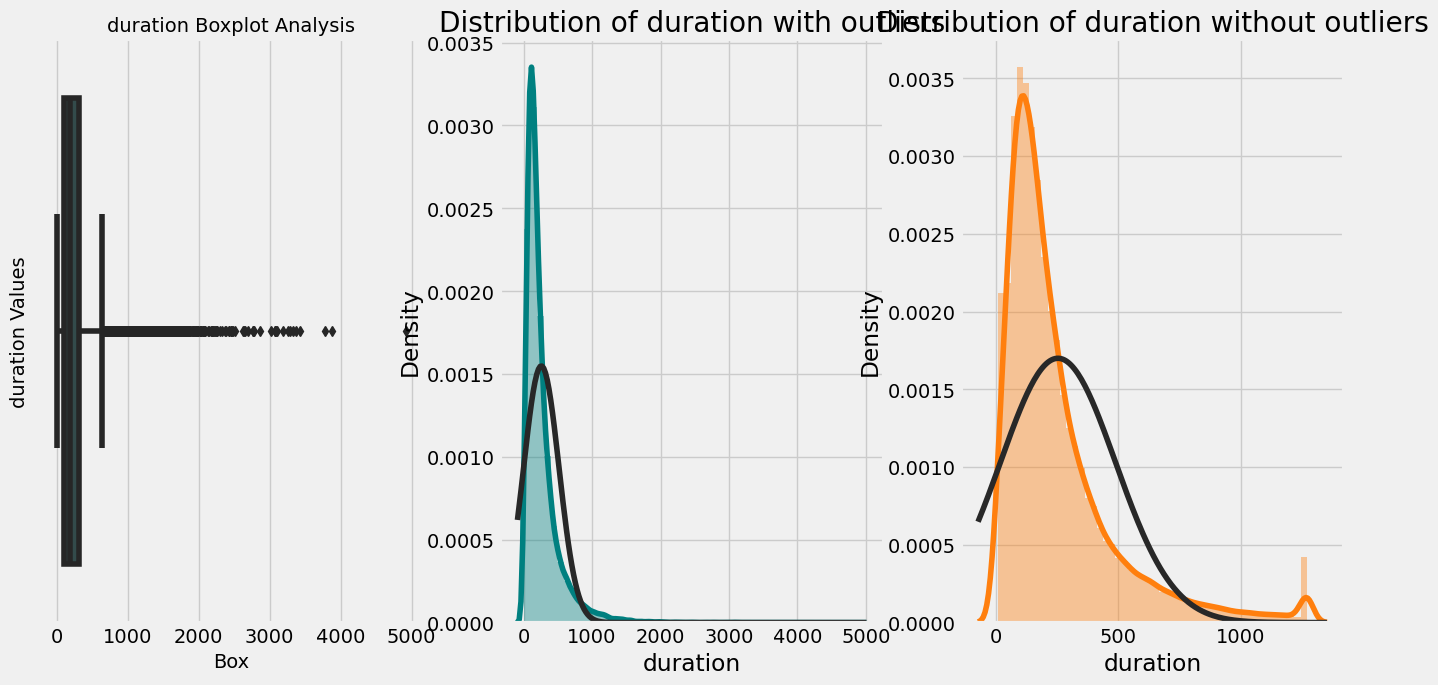

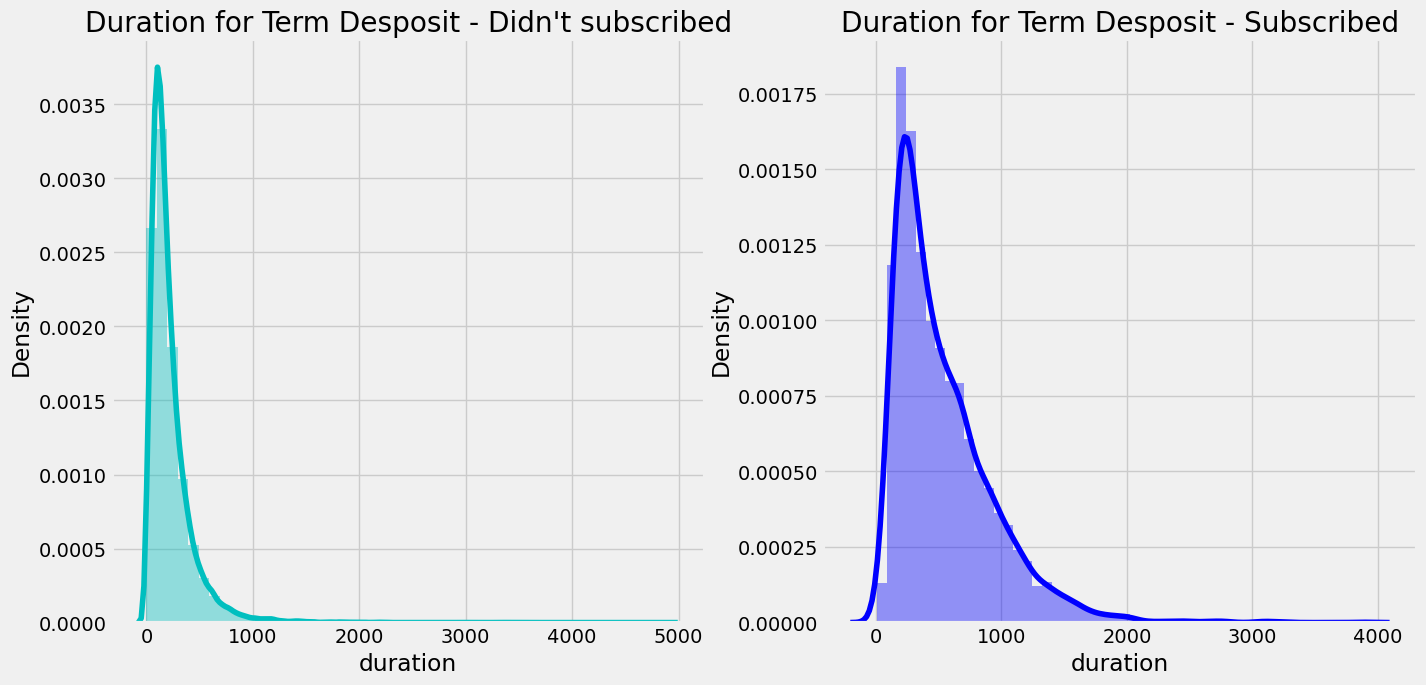

In [59]:
# Outlier, distribution for 'duration' column
Q3 = bank['duration'].quantile(0.75)
Q1 = bank['duration'].quantile(0.25)
IQR = Q3 - Q1

print('Duration column', '--'*54)
display(bank.loc[(bank['duration'] < (Q1 - 1.5 * IQR)) | (bank['duration'] > (Q3 + 1.5 * IQR))].head())

odp_plots(bank, 'duration')

# Distribution of 'duration' by 'Target'
target_plot(bank, 'duration')

Campaign column ------------------------------------------------------------------------------------------------------------


age         job  marital education default  balance housing loan  \
758    59    services  married         2       0      307       1    1   
780    30      admin.  married         2       0        4       0    0   
906    27    services   single         2       0        0       1    0   
1103   52  technician  married        -1       0      133       1    0   
1105   43      admin.  married         3       0     1924       1    0   

      contact day month  duration  campaign  pdays  previous poutcome Target  
758   unknown   6     5       250         7     -1         0  unknown      0  
780   unknown   7     5       172         8     -1         0  unknown      0  
906   unknown   7     5       388         7     -1         0  unknown      0  
1103  unknown   7     5       253         8     -1         0  unknown      0  
1105  unknown   7     5       244         7     -1         0  unknown      0

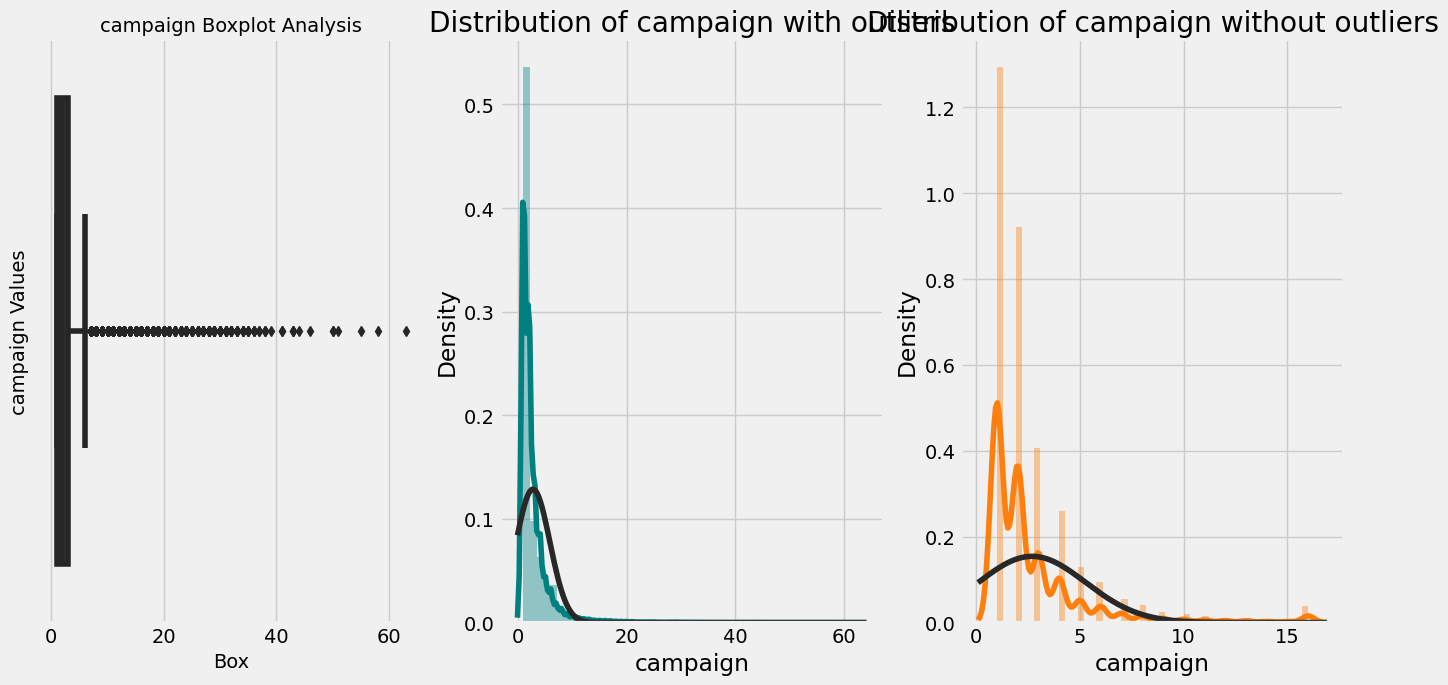

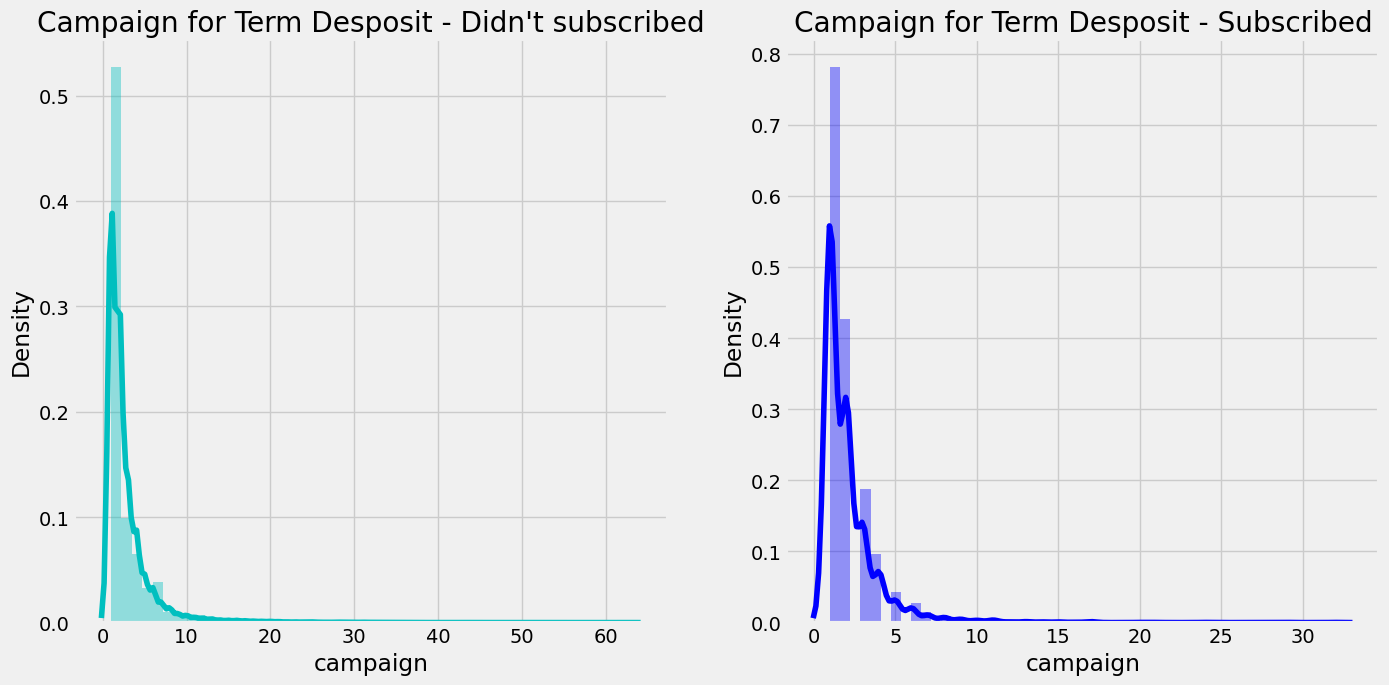

In [60]:
# Outlier, distribution for 'campaign' column
Q3 = bank['campaign'].quantile(0.75)
Q1 = bank['campaign'].quantile(0.25)
IQR = Q3 - Q1

print('Campaign column', '--'*54)
display(bank.loc[(bank['campaign'] < (Q1 - 1.5 * IQR)) | (bank['campaign'] > (Q3 + 1.5 * IQR))].head())

odp_plots(bank, 'campaign')

# Distribution of 'campaign' by 'Target'
target_plot(bank, 'campaign')

Pdays column --------------------------------------------------------------------------------------------------------------


age         job  marital education default  balance housing loan  \
24060   33      admin.  married         3       0      882       0    0   
24062   42      admin.   single         2       0     -247       1    1   
24064   33    services  married         2       0     3444       1    0   
24072   36  management  married         3       0     2415       1    0   
24077   36  management  married         3       0        0       1    0   

         contact day month  duration  campaign  pdays  previous poutcome  \
24060  telephone  21    10        39         1    151         3  failure   
24062  telephone  21    10       519         1    166         1    other   
24064  telephone  21    10       144         1     91         4  failure   
24072  telephone  22    10        73         1     86         4    other   
24077  telephone  23    10       140         1    143         3  failure   

      Target  
24060      0  
24062      1  
24064      1  
24072      0  
24077      1

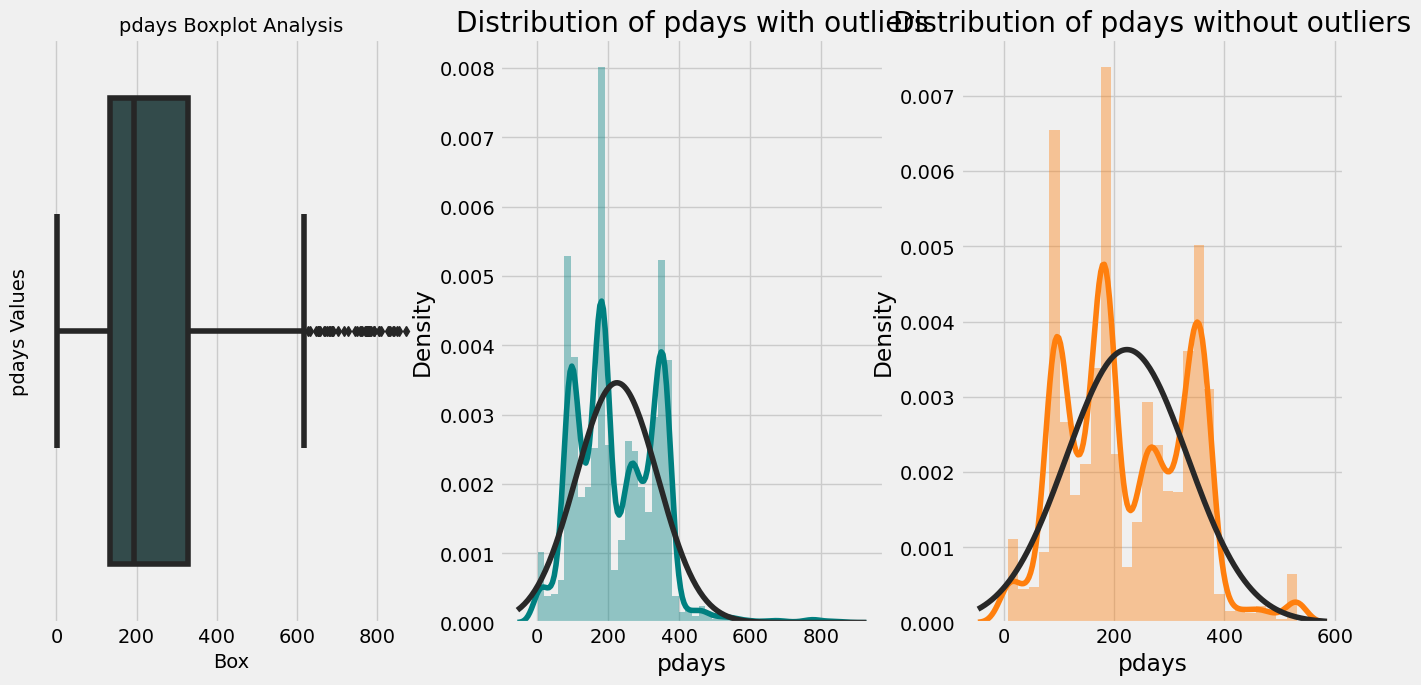

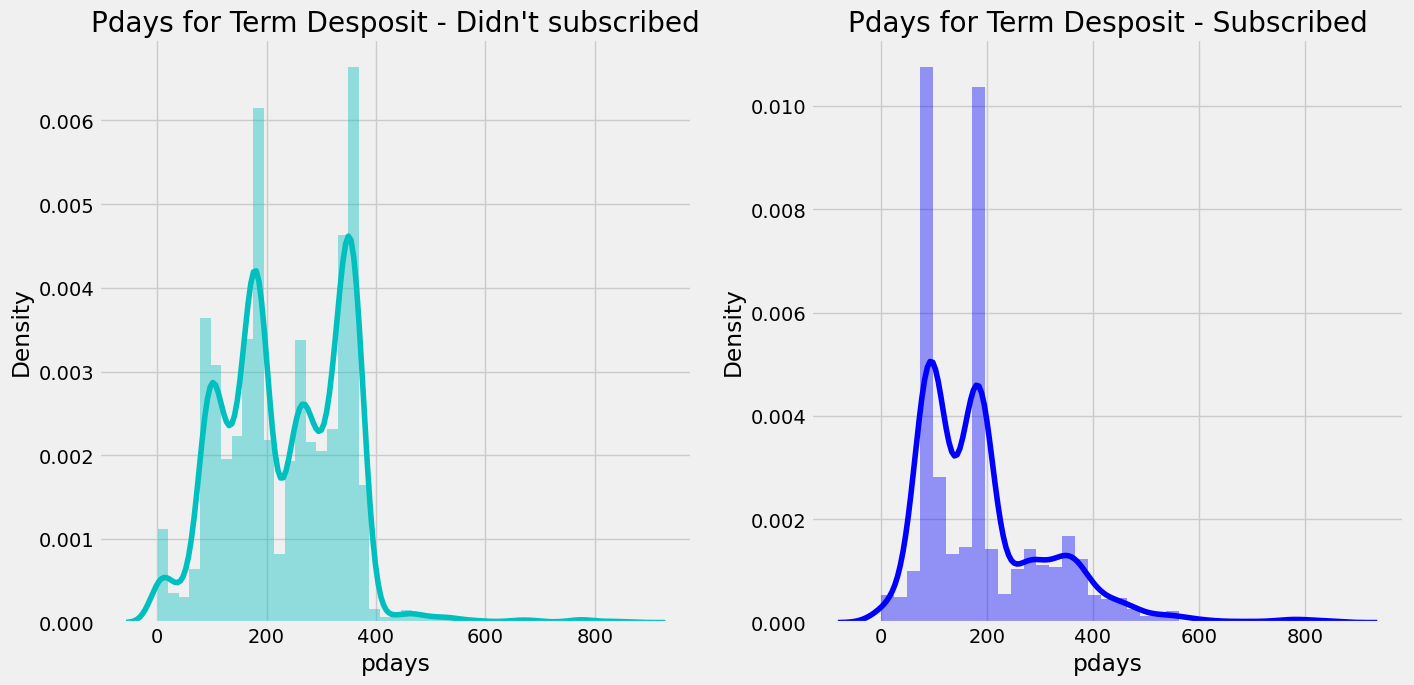

In [61]:
# Outlier, distribution for 'pdays' column
Q3 = bank['pdays'].quantile(0.75)
Q1 = bank['pdays'].quantile(0.25)
IQR = Q3 - Q1

print('Pdays column', '--'*55)
display(bank.loc[(bank['pdays'] < (Q1 - 1.5 * IQR)) | (bank['pdays'] > (Q3 + 1.5 * IQR))].head())

# Check outlier in 'pdays', not considering -1
pdays = bank.loc[bank['pdays'] > 0, ['pdays', 'Target']]
pdays = pd.DataFrame(pdays, columns = ['pdays', 'Target'])
odp_plots(pdays, 'pdays')

# Distribution of 'pdays' by 'Target', not considering -1
target_plot(pdays, 'pdays')

Previous column ------------------------------------------------------------------------------------------------------------


age         job  marital education default  balance housing loan  \
24060   33      admin.  married         3       0      882       0    0   
24062   42      admin.   single         2       0     -247       1    1   
24064   33    services  married         2       0     3444       1    0   
24072   36  management  married         3       0     2415       1    0   
24077   36  management  married         3       0        0       1    0   

         contact day month  duration  campaign  pdays  previous poutcome  \
24060  telephone  21    10        39         1    151         3  failure   
24062  telephone  21    10       519         1    166         1    other   
24064  telephone  21    10       144         1     91         4  failure   
24072  telephone  22    10        73         1     86         4    other   
24077  telephone  23    10       140         1    143         3  failure   

      Target  
24060      0  
24062      1  
24064      1  
24072      0  
24077      1

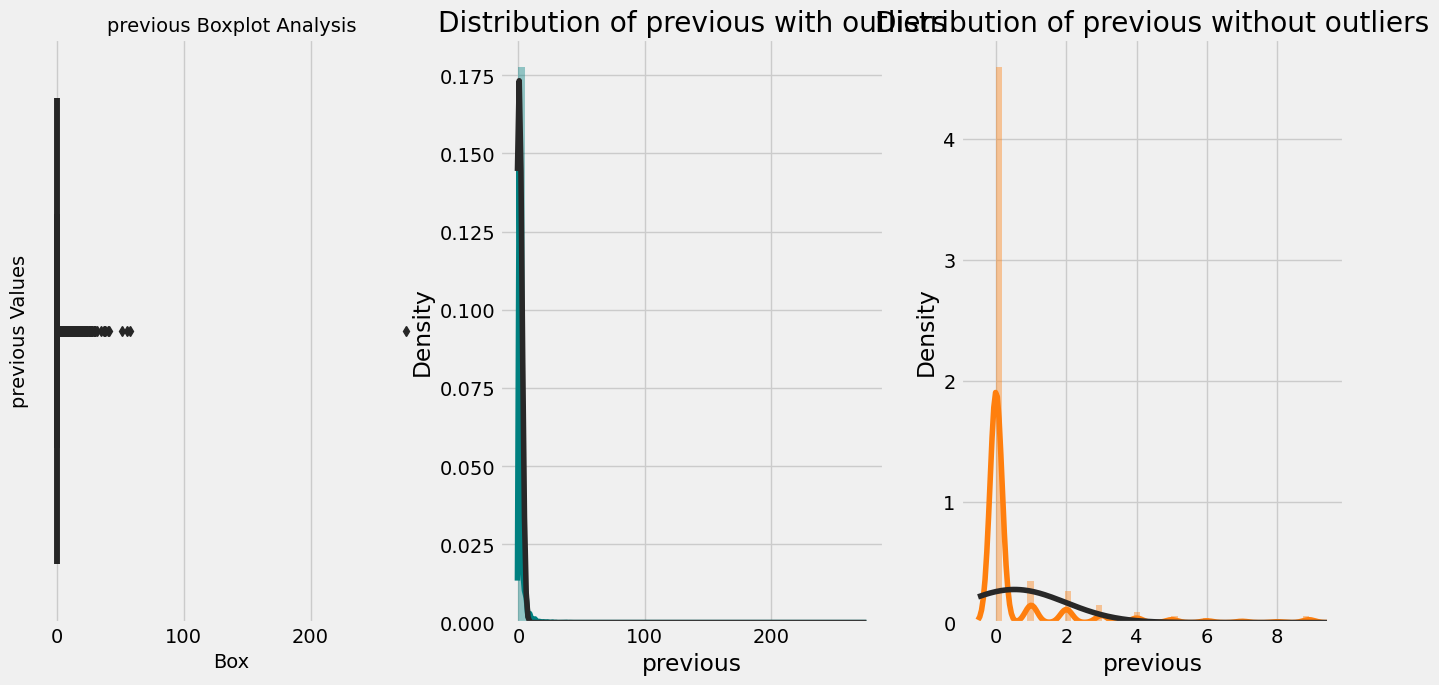

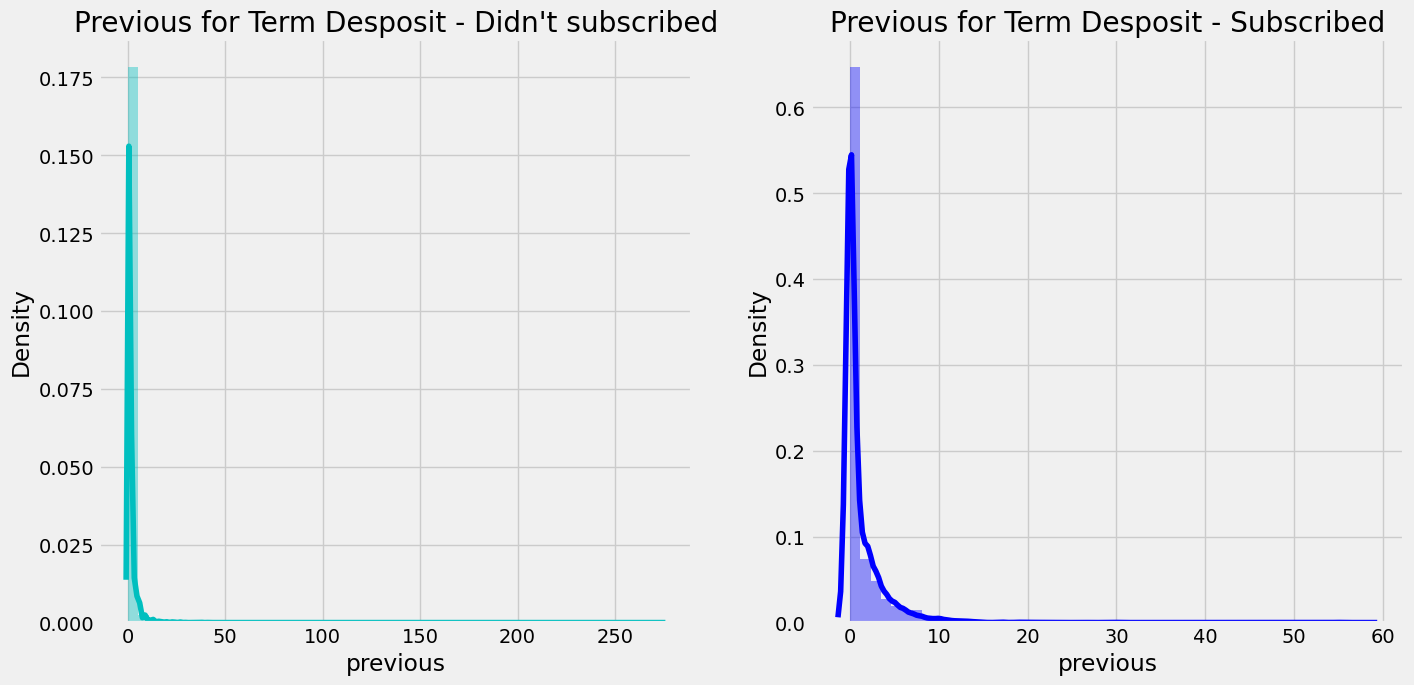

In [62]:
# Outlier, distribution and probability plot for 'previous' column
Q3 = bank['previous'].quantile(0.75)
Q1 = bank['previous'].quantile(0.25)
IQR = Q3 - Q1

print('Previous column', '--'*54)
display(bank.loc[(bank['previous'] < (Q1 - 1.5 * IQR)) | (bank['previous'] > (Q3 + 1.5 * IQR))].head())

odp_plots(bank, 'previous')

# Distribution of 'previous' by 'Target'
target_plot(bank, 'previous')

<a id='o6'></a>
#### Observation 6 - Comments from numerical columns
* Used quantile method to check outliers in numerical column. It appears that there are outliers in each of the numerical columns.
* It appears that removing outliers below 25% percentile and above 75% percentile will bring the age and pdays columns to almost normal distribution.

<a id='dummies'></a>
### Print categorical and numerical columns list, remove outliers with upper and lower percentile values being 99 and 1, respectively and get dummies

In [63]:
print('Categorical Columns: \n{}'.format(list(bank.select_dtypes('category').columns)))
print('\nNumerical Columns: \n{}'.format(list(bank.select_dtypes(exclude = 'category').columns)))

Categorical Columns: 
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'day', 'month', 'poutcome', 'Target']

Numerical Columns: 
['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']


In [64]:
# Removing outliers with upper and lower percentile values being 99 and 1, respectively
bank_nulls = bank.copy(deep = True)
columns = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']

for col in columns:
    upper_lim = np.percentile(bank_nulls[col].values, 99)
    lower_lim = np.percentile(bank_nulls[col].values, 1)
    bank_nulls.loc[(bank_nulls[col] > upper_lim), col] = np.nan
    bank_nulls.loc[(bank_nulls[col] < lower_lim), col] = np.nan

print('Column for which outliers where removed with upper and lower percentile values: \n', columns)

Column for which outliers where removed with upper and lower percentile values: 
 ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']


In [65]:
# # Frequency encoding of 'job' column, this would creating too many columns with sparse distribution
# columns = ['job']#, 'marital', 'contact', 'poutcome']

# for col in columns:
#     counts = bank_nulls[col].value_counts().index.tolist()
#     encoding = bank_nulls.groupby(col).size()
#     encoding = encoding/len(bank_nulls)
#     bank_nulls[col] = bank_nulls[col].map(encoding)
#     print([counts, bank_nulls[col].value_counts().index.tolist()], '\n')

In [66]:
# pd.get_dummies
cols_to_transform = ['job', 'marital', 'contact', 'poutcome']
bank_nulls = pd.get_dummies(bank_nulls, columns = cols_to_transform) #, drop_first = True)

print('Got dummies for \n', cols_to_transform)
bank_nulls.info()

Got dummies for 
 ['job', 'marital', 'contact', 'poutcome']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 35 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   age                44473 non-null  float64 
 1   education          45211 non-null  category
 2   default            45211 non-null  category
 3   balance            44308 non-null  float64 
 4   housing            45211 non-null  category
 5   loan               45211 non-null  category
 6   day                45211 non-null  category
 7   month              45211 non-null  category
 8   duration           44341 non-null  float64 
 9   campaign           44760 non-null  float64 
 10  pdays              44826 non-null  float64 
 11  previous           44758 non-null  float64 
 12  Target             45211 non-null  category
 13  job_admin.         45211 non-null  uint8   
 14  job_blue-collar    45211 non-null  uint8  

In [67]:
# Convert 'astype' of categorical columns to integer for getting it ready for MICE
columns = ['education', 'default', 'housing', 'loan', 'day', 'month', 'Target']
for col in columns:
    bank_nulls[col] = bank_nulls[col].astype('float')

<a id='mice'></a>
### Use MICE imputer to handled outliers that were filled with `np.nan` in the earlier step

In [68]:
# start the MICE training
bank_imputed = mice(bank_nulls.values)
bank_imputed = pd.DataFrame(bank_imputed, columns = bank_nulls.columns)

display(bank.describe(include = 'all').T, bank_imputed.describe(include = 'all').T)

count unique          top     freq         mean          std  \
age        45211.0    NaN          NaN      NaN     40.93621    10.618762   
job          45211     12  blue-collar     9732          NaN          NaN   
marital      45211      3      married    27214          NaN          NaN   
education  45211.0    4.0          2.0  23202.0          NaN          NaN   
default    45211.0    2.0          0.0  44396.0          NaN          NaN   
balance    45211.0    NaN          NaN      NaN  1362.272058  3044.765829   
housing    45211.0    2.0          1.0  25130.0          NaN          NaN   
loan       45211.0    2.0          0.0  37967.0          NaN          NaN   
contact      45211      3     cellular    29285          NaN          NaN   
day        45211.0   31.0         20.0   2752.0          NaN          NaN   
month      45211.0   12.0          5.0  13766.0          NaN          NaN   
duration   45211.0    NaN          NaN      NaN    258.16308   257.527812   
campaign   45211.0    NaN          NaN      NaN     2.763841     3.098021   
pdays      45211.0    NaN          NaN      NaN    40.197828   100.128746   
previous   45211.0    NaN          NaN      NaN     0.580323     2.303441   
poutcome     45211      4      unknown    36959          NaN          NaN   
Target     45211.0    2.0          0.0  39922.0          NaN          NaN   

              min    25%    50%     75%       max  
age          18.0   33.0   39.0    48.0      95.0  
job           NaN    NaN    NaN     NaN       NaN  
marital       NaN    NaN    NaN     NaN       NaN  
education     NaN    NaN    NaN     NaN       NaN  
default       NaN    NaN    NaN     NaN       NaN  
balance   -8019.0   72.0  448.0  1428.0  102127.0  
housing       NaN    NaN    NaN     NaN       NaN  
loan          NaN    NaN    NaN     NaN       NaN  
contact       NaN    NaN    NaN     NaN       NaN  
day           NaN    NaN    NaN     NaN       NaN  
month         NaN    NaN    NaN     NaN       NaN  
duration      0.0  103.0  180.0   319.0    4918.0  
campaign      1.0    1.0    2.0     3.0      63.0  
pdays        -1.0   -1.0   -1.0    -1.0     871.0  
previous      0.0    0.0    0.0     0.0     275.0  
poutcome      NaN    NaN    NaN     NaN       NaN  
Target        NaN    NaN    NaN     NaN       NaN

count         mean          std         min    25%  \
age                45211.0    40.836870    10.073690   23.000000   33.0   
education          45211.0     2.019442     0.902795   -1.000000    2.0   
default            45211.0     0.018027     0.133049    0.000000    0.0   
balance            45211.0  1174.932363  1898.534988 -812.502754   81.0   
housing            45211.0     0.555838     0.496878    0.000000    0.0   
loan               45211.0     0.160226     0.366820    0.000000    0.0   
day                45211.0    15.806419     8.322476    1.000000    8.0   
month              45211.0     6.144655     2.408034    1.000000    5.0   
duration           45211.0   247.428930   211.290370   11.000000  106.0   
campaign           45211.0     2.562222     2.214906    1.000000    1.0   
pdays              45211.0    37.922341    92.399489  -47.832018   -1.0   
previous           45211.0     0.461333     1.208702    0.000000    0.0   
Target             45211.0     0.116985     0.321406    0.000000    0.0   
job_admin.         45211.0     0.114375     0.318269    0.000000    0.0   
job_blue-collar    45211.0     0.215257     0.411005    0.000000    0.0   
job_entrepreneur   45211.0     0.032890     0.178351    0.000000    0.0   
job_housemaid      45211.0     0.027427     0.163326    0.000000    0.0   
job_management     45211.0     0.209197     0.406740    0.000000    0.0   
job_retired        45211.0     0.050076     0.218105    0.000000    0.0   
job_self-employed  45211.0     0.034925     0.183592    0.000000    0.0   
job_services       45211.0     0.091880     0.288860    0.000000    0.0   
job_student        45211.0     0.020747     0.142538    0.000000    0.0   
job_technician     45211.0     0.168034     0.373901    0.000000    0.0   
job_unemployed     45211.0     0.028820     0.167303    0.000000    0.0   
job_unknown        45211.0     0.006370     0.079559    0.000000    0.0   
marital_divorced   45211.0     0.115171     0.319232    0.000000    0.0   
marital_married    45211.0     0.601933     0.489505    0.000000    0.0   
marital_single     45211.0     0.282896     0.450411    0.000000    0.0   
contact_cellular   45211.0     0.647741     0.477680    0.000000    0.0   
contact_telephone  45211.0     0.064276     0.245247    0.000000    0.0   
contact_unknown    45211.0     0.287983     0.452828    0.000000    0.0   
poutcome_failure   45211.0     0.108403     0.310892    0.000000    0.0   
poutcome_other     45211.0     0.040698     0.197592    0.000000    0.0   
poutcome_success   45211.0     0.033421     0.179735    0.000000    0.0   
poutcome_unknown   45211.0     0.817478     0.386278    0.000000    1.0   

                     50%     75%           max  
age                 39.0    48.0     71.743841  
education            2.0     3.0      3.000000  
default              0.0     0.0      1.000000  
balance            467.0  1402.0  13164.000000  
housing              1.0     1.0      1.000000  
loan                 0.0     0.0      1.000000  
day                 16.0    21.0     31.000000  
month                6.0     8.0     12.000000  
duration           183.0   316.0   1269.000000  
campaign             2.0     3.0     16.000000  
pdays               -1.0    -1.0    370.000000  
previous             0.0     0.0      8.000000  
Target               0.0     0.0      1.000000  
job_admin.           0.0     0.0      1.000000  
job_blue-collar      0.0     0.0      1.000000  
job_entrepreneur     0.0     0.0      1.000000  
job_housemaid        0.0     0.0      1.000000  
job_management       0.0     0.0      1.000000  
job_retired          0.0     0.0      1.000000  
job_self-employed    0.0     0.0      1.000000  
job_services         0.0     0.0      1.000000  
job_student          0.0     0.0      1.000000  
job_technician       0.0     0.0      1.000000  
job_unemployed       0.0     0.0      1.000000  
job_unknown          0.0     0.0      1.000000  
marital_divorced     0.0     0.0      1.000000

<a id='o7'></a>
#### Observation 7 - Observation after MICE

| **Column** | **Before MICE** | **After MICE** |
|--------|-------------|------------|
|**`age`**| Range of Q1 to Q3 is 33-48. Mean > Median, right (positively) skewed | Range of Q1 to Q3 is unchanged, because of change in min and max values there's a slight reduction is mean, right skewed|
|**`balance`**| Range of Q1 to Q3 is 72-1428. Mean > Median, skewed towards right (positively) | Range of Q1 to Q3 is 81 to 1402, reduction in mean, right skewed |
|**`duration`**| Range of Q1 to Q3 is 103-319. Mean > Median, right (positively) skewed | Range of Q1 to Q3 is 106-316, right skewed|
|**`campaign`**| Range of Q1 to Q3 is 1-3. Mean > Median, right (positively) skewed | Unchanged range and skewness|
|**`pdays`**| 75% of data values are around -1 | Unchanged|
|**`previous`**| 75% of data values are around 0 | Unchanged|

<a id='pdays'></a>
### Checking whether count of 0 in previous column is equal to count of -1 in pdays column

In [69]:
# Checking whether count of 0 in previous is equal to count of -1 in pdays
display(bank_imputed.loc[bank_imputed['previous'] == 0, 'previous'].value_counts().sum(), 
        bank_imputed.loc[bank_imputed['pdays'] == -1, 'pdays'].value_counts().sum())

36954

36954

<a id='o8'></a>
#### Observation 8 - pdays and previous
Count of 0 in previous is equal to count of -1 in pdays column, we might replace -1 in pdays with 0 to account for cases where the client wasn't contacted previously. Checking correlation between variables and target next...

<a id='multi'></a>
## Multivariate visualization
Checking relationship between two or more variables. Includes correlation and scatterplot matrix, checking relation between two variables and Target.

<a id='scatter'></a>
### Check scattermatrix

In [70]:
sns.pairplot(bank_imputed[['age', 'education', 'default', 'balance', 'housing', 'loan', 'day', 'month', 
                           'duration', 'campaign', 'pdays', 'previous', 'Target']], hue = 'Target')

<a id='corr'></a>
### Correlation matrix

Text(0.5, 1.0, 'Correlation Matrix of Data')

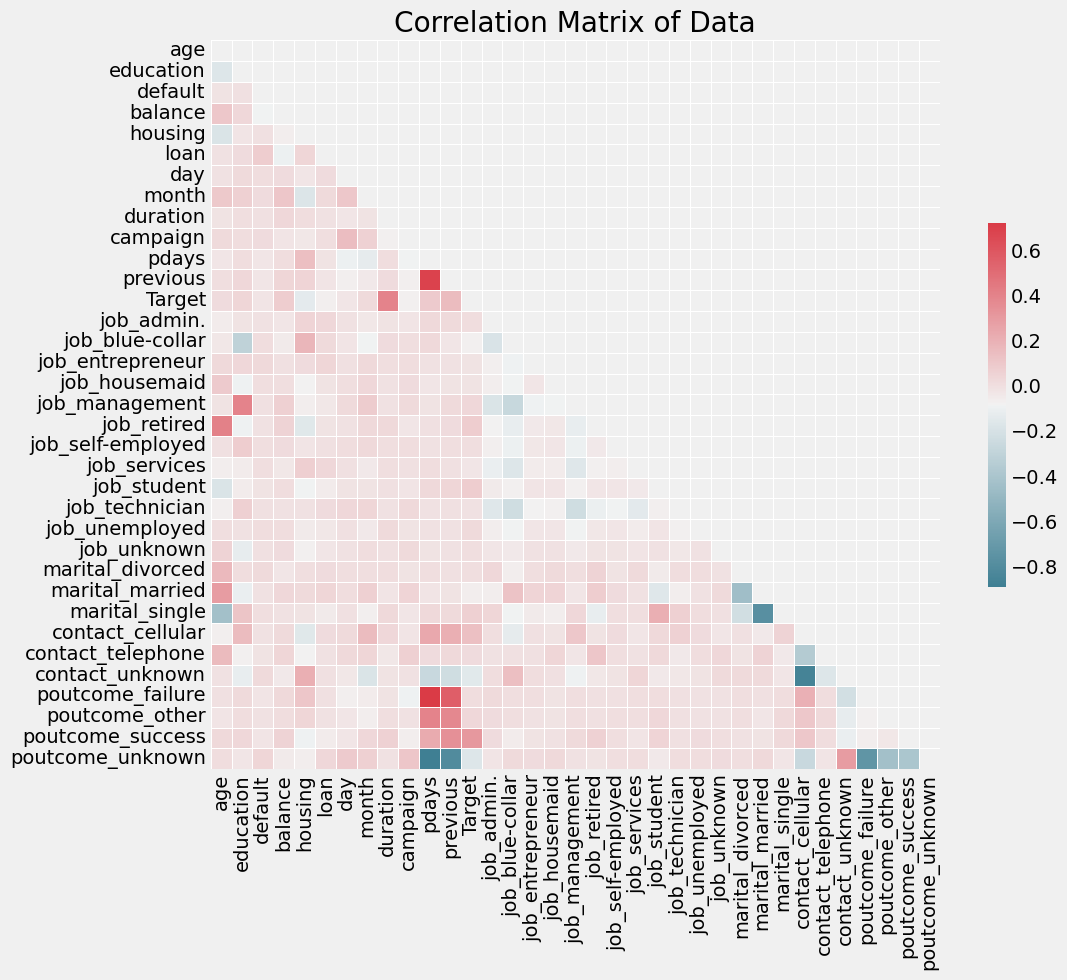

In [71]:
# Correlation matrix for all variables
corr = bank_imputed.corr()

mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize = (11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap = True)

sns.heatmap(corr, mask = mask, cmap = cmap, square = True, linewidths = .5, cbar_kws = {"shrink": .5})#, annot = True)
ax.set_title('Correlation Matrix of Data')

In [72]:
# Filter for correlation value greater than 0.8
sort = corr.abs().unstack()
sort = sort.sort_values(kind = "quicksort", ascending = False)
sort[(sort > 0.8) & (sort < 1)]

pdays             poutcome_unknown    0.891235
poutcome_unknown  pdays               0.891235
contact_cellular  contact_unknown     0.862398
contact_unknown   contact_cellular    0.862398
previous          poutcome_unknown    0.806952
poutcome_unknown  previous            0.806952
dtype: float64

In [73]:
# Absolute correlation of independent variables with 'Target' i.e. the target variable
absCorrwithDep = []
allVars = bank_imputed.drop('Target', axis = 1).columns

for var in allVars:
    absCorrwithDep.append(abs(bank_imputed['Target'].corr(bank_imputed[var])))

display(pd.DataFrame([allVars, absCorrwithDep], index = ['Variable', 'Correlation']).T.\
        sort_values('Correlation', ascending = False))

Variable Correlation
8            duration    0.398107
32   poutcome_success    0.306788
33   poutcome_unknown    0.167051
11           previous    0.153341
29    contact_unknown    0.150935
4             housing    0.139173
27   contact_cellular    0.135873
10              pdays    0.086593
17        job_retired    0.079245
3             balance    0.076923
20        job_student    0.076897
9            campaign    0.075451
13    job_blue-collar    0.072083
5                loan    0.068185
26     marital_single    0.063526
25    marital_married     0.06026
1           education    0.041634
16     job_management    0.032919
31     poutcome_other    0.031955
6                 day    0.028348
19       job_services    0.027864
2             default    0.022419
22     job_unemployed     0.02039
14   job_entrepreneur    0.019662
7               month    0.018717
15      job_housemaid    0.015195
28  contact_telephone    0.014042
0                 age    0.013475
30   poutcome_failure    0.009885
21     job_technician     0.00897
12         job_admin.    0.005637
24   marital_divorced    0.002772
18  job_self-employed    0.000855
23        job_unknown    0.000267

<a id='corr'></a>
#### Observation 9 - Correlation Matrix
* `poutcome_unknown` and `pdays`; `contact_unknown` and `contact_cellular`; `poutcome_unknown` and `previous`; `marital_married` and `marital_single`; `poutcome_unknown` and `poutcome_failure`; `pdays` and `poutcome_failure`; `previous` and `pdays`; `poutcome_failure` and `previous` columns are correlated with each other.
* `duration`, `poutcome_success`, `poutcome_unknown` and `previous` are few columns which have a relatively strong correlation with `Target` column.

In [74]:
#bank_imputed.drop(['pdays', 'contact_cellular'], axis = 1, inplace = True) #, 'previous', 'marital_married', 'poutcome_failure'

<a id='age'></a>
### Creating age groups and check relation with balance and target; also with campaign and target

In [75]:
# Creating age groups
bank_imputed.loc[(bank_imputed['age'] < 30), 'age_group'] = 20
bank_imputed.loc[(bank_imputed['age'] >= 30) & (bank_imputed['age'] < 40), 'age_group'] = 30
bank_imputed.loc[(bank_imputed['age'] >= 40) & (bank_imputed['age'] < 50), 'age_group'] = 40
bank_imputed.loc[(bank_imputed['age'] >= 50) & (bank_imputed['age'] < 60), 'age_group'] = 50
bank_imputed.loc[(bank_imputed['age'] >= 60), 'age_group'] = 60

Text(0.5, 1.0, 'Relationship between balance and age group by Target')

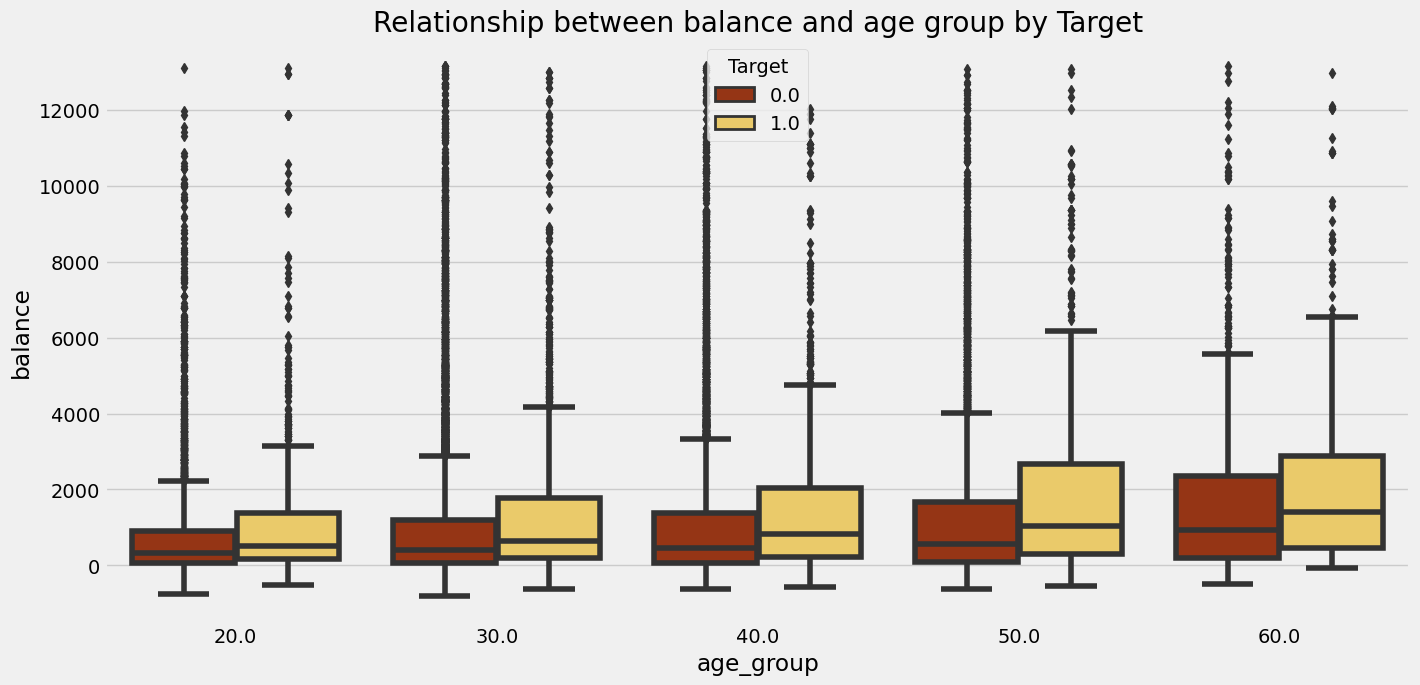

In [76]:
# Check relationship between balance and age group by Target
fig = plt.figure(figsize = (15, 7.2))
ax = sns.boxplot(x = 'age_group', y = 'balance', hue = 'Target', palette = 'afmhot', data = bank_imputed)
ax.set_title('Relationship between balance and age group by Target')

Text(0.5, 1.0, 'Relationship between campaign and age group by Target')

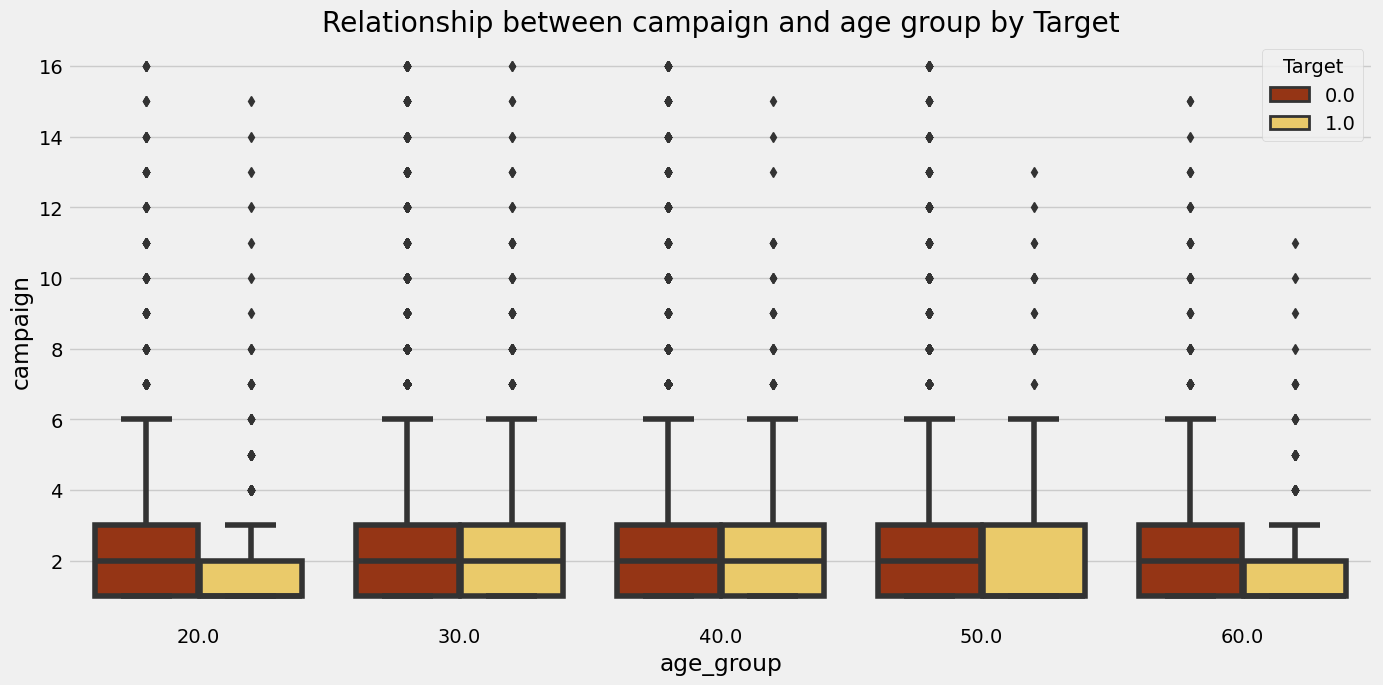

In [77]:
# Check relationship between campaign and age group by Target
fig = plt.figure(figsize = (15, 7.2))
ax = sns.boxplot(x = 'age_group', y = 'campaign', hue = 'Target', palette = 'afmhot', data = bank_imputed)
ax.set_title('Relationship between campaign and age group by Target')

In [78]:
# bank_imputed.drop(['age_group'], axis = 1, inplace = True)

<a id='o10'></a>
#### Observation 10 - Comments
* Created `age_group` and checked it's relation with `balance` and `target` and it appears that higher the balance range more are the chances that the client would subscribe to the term deposit irrespective of age group. It also appears that clients within age group 50 have the highest range of balance.

* Then checked relation between campaign, age group and target and it appears that campaigns for client with age group 20 and 60 are less.

<a id='modelling'></a>
## Modelling
* Create a baseline model
* Use different classification models (Logistic, K-NN and Naïve Bayes) to predict will the client subscribe to term deposit.
* Training and making predictions using an Ensemble Model.

<a id='dummy'></a>
### Dummy Classifier -- Baseline Model

In [79]:
# Separating dependent and independent variables
X = bank_imputed.drop(['Target'], axis = 1)
y = bank_imputed['Target']

# Splitting the data into training and test set in the ratio of 70:30 respectively
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = random_state)

dummy = DummyClassifier(strategy = 'most_frequent', random_state = random_state)
dummy.fit(X_train, y_train)
y_pred = dummy.predict(X_test)

accuracy_ = accuracy_score(y_test, y_pred)
pre_s = precision_score(y_test, y_pred, average = 'binary', pos_label = 1)
re_s = recall_score(y_test, y_pred, average = 'binary', pos_label = 1)
f1_s = f1_score(y_test, y_pred, average = 'binary', pos_label = 1)

pre_m = precision_score(y_test, y_pred, average = 'macro')
re_m = recall_score(y_test, y_pred, average = 'macro')
f1_m = f1_score(y_test, y_pred, average = 'macro')

print('Training Score: ', dummy.score(X_train, y_train).round(3))
print('Test Score: ', dummy.score(X_test, y_test).round(3))

print('Accuracy: ', accuracy_.round(3))
print('Precision Score - Subscribe: ', pre_s.round(3))
print('Recall Score - Subscribe: ', re_s.round(3))
print('f1 Score - Subscribe: ', f1_s.round(3))

print('Precision Score - Macro: ', pre_m.round(3))
print('Recall Score - Macro: ', re_m.round(3))
print('f1 Score - Macro: ', f1_m.round(3))

df = pd.DataFrame([accuracy_.round(3), pre_s.round(3), pre_m.round(3), re_s.round(3), 
                   re_m.round(3), f1_s.round(3), f1_m.round(3)], columns = ['Baseline Model']).T
df.columns = ['Accuracy', 'Precision_Subscribe', 'Precision_Macro',
              'Recall_Subscribe', 'Recall_Macro', 'f1_Subscribe', 'f1_Macro']
df

Training Score:  0.883
Test Score:  0.882
Accuracy:  0.882
Precision Score - Subscribe:  0.0
Recall Score - Subscribe:  0.0
f1 Score - Subscribe:  0.0
Precision Score - Macro:  0.441
Recall Score - Macro:  0.5
f1 Score - Macro:  0.469


Accuracy  Precision_Subscribe  Precision_Macro  \
Baseline Model     0.882                  0.0            0.441   

                Recall_Subscribe  Recall_Macro  f1_Subscribe  f1_Macro  
Baseline Model               0.0           0.5           0.0     0.469

In [91]:
# Helper function for making prediction and evaluating scores
def train_and_predict(n_splits, base_model, X, y, name, subscribe = 1, oversampling = False):
    features = X.columns
    X = np.array(X)
    y = np.array(y)
    
    folds = list(StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = random_state).split(X, y))
    
    train_pred = np.zeros((X.shape[0], len(base_model)))
    
    accuracy = []

    precision_subscribe = []
    recall_subscribe = []
    f1_subscribe = []
    
    precision_macro = []
    recall_macro = []
    f1_macro = []
    
    for i, clf in enumerate(base_model):
        for j, (train, test) in enumerate(folds):
            
            # Creating train and test sets
            X_train = X[train]
            y_train = y[train]
            X_test = X[test]
            y_test = y[test]
            
            if oversampling:
                sm = SMOTE(random_state = random_state, sampling_strategy = 'minority')
                X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
           
            # fit the model
                clf.fit(X_train_res, y_train_res)

            # Get predictions
                y_true, y_pred = y_test, clf.predict(X_test)

            # Evaluate train and test scores
                train_ = clf.score(X_train_res, y_train_res)
                test_ = clf.score(X_test, y_test)
            
            else:
            
            # fit the model
                clf.fit(X_train, y_train)

            # Get predictions
                y_true, y_pred = y_test, clf.predict(X_test)

            # Evaluate train and test scores
                train_ = clf.score(X_train, y_train)
                test_ = clf.score(X_test, y_test)
                      
            # Other scores
            accuracy_ = accuracy_score(y_true, y_pred).round(3)
            
            precision_b = precision_score(y_true, y_pred, average = 'binary', pos_label = subscribe).round(3)
            recall_b = recall_score(y_true, y_pred, average = 'binary', pos_label = subscribe).round(3)
            f1_b = f1_score(y_true, y_pred, average = 'binary', pos_label = subscribe).round(3)
            
            precision_m = precision_score(y_true, y_pred, average = 'macro').round(3)
            recall_m = recall_score(y_true, y_pred, average = 'macro').round(3)
            f1_m = f1_score(y_true, y_pred, average = 'macro').round(3)
            
            print(f'Model- {name.capitalize()} and CV- {j}')
            print('-'*20)
            print('Training Score: {0:.3f}'.format(train_))
            print('Test Score: {0:.3f}'.format(test_))
            
            print('Accuracy Score: {0:.3f}'.format(accuracy_))
            
            print('Precision Score - Subscribe: {0:.3f}'.format(precision_b))
            print('Recall Score - Subscribe: {0:.3f}'.format(recall_b))
            print('f1 Score - Subscribe: {0:.3f}'.format(f1_b))
            
            print('Precision Score - Macro: {0:.3f}'.format(precision_m))
            print('Recall Score - Macro: {0:.3f}'.format(recall_m))
            print('f1 Score - Macro: {0:.3f}'.format(f1_m))
            print('\n')
            
            ## Appending scores   
            accuracy.append(accuracy_)
            precision_subscribe.append(precision_b)
            recall_subscribe.append(recall_b)
            f1_subscribe.append(f1_b)
            precision_macro.append(precision_m)
            recall_macro.append(recall_m)
            f1_macro.append(f1_m)
                       
            # Creating a dataframe of scores
            df = pd.DataFrame([np.mean(accuracy).round(3), np.mean(precision_subscribe).round(3), 
                               np.mean(precision_macro).round(3), np.mean(recall_subscribe).round(3), 
                               np.mean(recall_macro).round(3), np.mean(f1_subscribe).round(3), 
                               np.mean(f1_macro).round(3)], columns = [name]).T
            df.columns = ['Accuracy', 'Precision_Subscribe', 'Precision_Macro',
                          'Recall_Subscribe', 'Recall_Macro', 'f1_Subscribe', 'f1_Macro']
            
    return df

In [92]:
# Separating dependent and independent variables
from sklearn.preprocessing import RobustScaler
X = bank_imputed.drop(['Target'], axis = 1)
y = bank_imputed['Target']

# Applying RobustScaler to make it less prone to outliers
features = X.columns
scaler = RobustScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns = features)

# Scaling the independent variables
Xs = X.apply(zscore)

display(X.shape, Xs.shape, y.shape)

(45211, 35)

(45211, 35)

(45211,)

<a id='sm'></a>
### Logistic Regression, kNN and Naive Bayes
Oversampling the one with better accuracy and recall score for subscribe

<a id='lr'></a>
#### Logistic Regression

In [93]:
# LR model without hyperparameter tuning
LR = LogisticRegression()
base_model = [LR]
n_splits = 5
df1 = train_and_predict(n_splits, base_model, X, y, 'Logistic Regression Without Hyperparameter Tuning')
df = df.append(df1)
df

Model- Logistic regression without hyperparameter tuning and CV- 0
--------------------
Training Score: 0.898
Test Score: 0.901
Accuracy Score: 0.901
Precision Score - Subscribe: 0.648
Recall Score - Subscribe: 0.335
f1 Score - Subscribe: 0.441
Precision Score - Macro: 0.783
Recall Score - Macro: 0.655
f1 Score - Macro: 0.694


Model- Logistic regression without hyperparameter tuning and CV- 1
--------------------
Training Score: 0.899
Test Score: 0.897
Accuracy Score: 0.897
Precision Score - Subscribe: 0.605
Recall Score - Subscribe: 0.336
f1 Score - Subscribe: 0.432
Precision Score - Macro: 0.761
Recall Score - Macro: 0.653
f1 Score - Macro: 0.688


Model- Logistic regression without hyperparameter tuning and CV- 2
--------------------
Training Score: 0.899
Test Score: 0.897
Accuracy Score: 0.897
Precision Score - Subscribe: 0.611
Recall Score - Subscribe: 0.327
f1 Score - Subscribe: 0.426
Precision Score - Macro: 0.764
Recall Score - Macro: 0.650
f1 Score - Macro: 0.685


Model- Log

Accuracy  \
Baseline Model                                         0.882   
Logistic Regression Without Hyperparameter Tuning      0.898   
Logistic Regression With Hyperparameter Tuning         0.898   
k-Nearest Neighbor Scaled Without Hyperparamete...     0.891   
k-Nearest Neighbor Scaled With Hyperparameter T...     0.886   
Naive Bayes Classifier                                 0.815   
Logistic Regression Without Hyperparameter Tuning      0.898   

                                                    Precision_Subscribe  \
Baseline Model                                                    0.000   
Logistic Regression Without Hyperparameter Tuning                 0.624   
Logistic Regression With Hyperparameter Tuning                    0.624   
k-Nearest Neighbor Scaled Without Hyperparamete...                0.566   
k-Nearest Neighbor Scaled With Hyperparameter T...                0.517   
Naive Bayes Classifier                                            0.320   
Logistic Regression Without Hyperparameter Tuning                 0.624   

                                                    Precision_Macro  \
Baseline Model                                                0.441   
Logistic Regression Without Hyperparameter Tuning             0.770   
Logistic Regression With Hyperparameter Tuning                0.770   
k-Nearest Neighbor Scaled Without Hyperparamete...            0.739   
k-Nearest Neighbor Scaled With Hyperparameter T...            0.716   
Naive Bayes Classifier                                        0.625   
Logistic Regression Without Hyperparameter Tuning             0.770   

                                                    Recall_Subscribe  \
Baseline Model                                                 0.000   
Logistic Regression Without Hyperparameter Tuning              0.323   
Logistic Regression With Hyperparameter Tuning                 0.326   
k-Nearest Neighbor Scaled Without Hyperparamete...             0.300   
k-Nearest Neighbor Scaled With Hyperparameter T...             0.330   
Naive Bayes Classifier                                         0.520   
Logistic Regression Without Hyperparameter Tuning              0.323   

                                                    Recall_Macro  \
Baseline Model                                             0.500   
Logistic Regression Without Hyperparameter Tuning          0.648   
Logistic Regression With Hyperparameter Tuning             0.650   
k-Nearest Neighbor Scaled Without Hyperparamete...         0.635   
k-Nearest Neighbor Scaled With Hyperparameter T...         0.645   
Naive Bayes Classifier                                     0.687   
Logistic Regression Without Hyperparameter Tuning          0.648   

                                                    f1_Subscribe  f1_Macro  
Baseline Model                                             0.000     0.469  
Logistic Regression Without Hyperparameter Tuning          0.425     0.685  
Logistic Regression With Hyperparameter Tuning             0.428     0.686  
k-Nearest Neighbor Scaled Without Hyperparamete...         0.392     0.666  
k-Nearest Neighbor Scaled With Hyperparameter T...         0.403     0.670  
Naive Bayes Classifier                                     0.396     0.643  
Logistic Regression Without Hyperparameter Tuning          0.425     0.685

In [94]:
# LR with hyperparameter tuning
LR = LogisticRegression(n_jobs = -1, random_state = random_state)

params = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter': [100, 110, 120, 130, 140],
    'solver': ['liblinear', 'saga']  # Choose solvers that support 'l1' and 'l2' penalties
}

scoring = {
    'Recall': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score)
}
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = random_state)
LR_hyper = GridSearchCV(LR, param_grid = params, n_jobs = -1, cv = skf, scoring = scoring, refit = 'f1_score')

LR_hyper.fit(X_train, y_train)
print(LR_hyper.best_estimator_)
print(LR_hyper.best_params_)

LogisticRegression(C=10, n_jobs=-1, random_state=42, solver='liblinear')
{'C': 10, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}


In [95]:

LR_Hyper = LogisticRegression(
    C=100, 
    class_weight=None, 
    dual=False, 
    fit_intercept=True, 
    intercept_scaling=1, 
    l1_ratio=None, 
    max_iter=100,
    multi_class='auto',  # Corrected value
    n_jobs=-1, 
    penalty='l2', 
    random_state=42,
    solver='lbfgs',  # Corrected value
    tol=0.0001, 
    verbose=0, 
    warm_start=False
)

# Assuming base_model and train_and_predict functions are defined correctly
base_model = [LR_Hyper]
n_splits = 5

# Assuming X and y are defined
df1 = train_and_predict(n_splits, base_model, X, y, 'Logistic Regression With Hyperparameter Tuning')
df = df.append(df1)
df

Model- Logistic regression with hyperparameter tuning and CV- 0
--------------------
Training Score: 0.898
Test Score: 0.901
Accuracy Score: 0.901
Precision Score - Subscribe: 0.647
Recall Score - Subscribe: 0.343
f1 Score - Subscribe: 0.448
Precision Score - Macro: 0.783
Recall Score - Macro: 0.659
f1 Score - Macro: 0.697


Model- Logistic regression with hyperparameter tuning and CV- 1
--------------------
Training Score: 0.899
Test Score: 0.896
Accuracy Score: 0.896
Precision Score - Subscribe: 0.602
Recall Score - Subscribe: 0.329
f1 Score - Subscribe: 0.426
Precision Score - Macro: 0.759
Recall Score - Macro: 0.650
f1 Score - Macro: 0.684


Model- Logistic regression with hyperparameter tuning and CV- 2
--------------------
Training Score: 0.899
Test Score: 0.898
Accuracy Score: 0.898
Precision Score - Subscribe: 0.615
Recall Score - Subscribe: 0.334
f1 Score - Subscribe: 0.433
Precision Score - Macro: 0.766
Recall Score - Macro: 0.653
f1 Score - Macro: 0.688


Model- Logistic reg

Accuracy  \
Baseline Model                                         0.882   
Logistic Regression Without Hyperparameter Tuning      0.898   
Logistic Regression With Hyperparameter Tuning         0.898   
k-Nearest Neighbor Scaled Without Hyperparamete...     0.891   
k-Nearest Neighbor Scaled With Hyperparameter T...     0.886   
Naive Bayes Classifier                                 0.815   
Logistic Regression Without Hyperparameter Tuning      0.898   
Logistic Regression With Hyperparameter Tuning         0.898   

                                                    Precision_Subscribe  \
Baseline Model                                                    0.000   
Logistic Regression Without Hyperparameter Tuning                 0.624   
Logistic Regression With Hyperparameter Tuning                    0.624   
k-Nearest Neighbor Scaled Without Hyperparamete...                0.566   
k-Nearest Neighbor Scaled With Hyperparameter T...                0.517   
Naive Bayes Classifier                                            0.320   
Logistic Regression Without Hyperparameter Tuning                 0.624   
Logistic Regression With Hyperparameter Tuning                    0.624   

                                                    Precision_Macro  \
Baseline Model                                                0.441   
Logistic Regression Without Hyperparameter Tuning             0.770   
Logistic Regression With Hyperparameter Tuning                0.770   
k-Nearest Neighbor Scaled Without Hyperparamete...            0.739   
k-Nearest Neighbor Scaled With Hyperparameter T...            0.716   
Naive Bayes Classifier                                        0.625   
Logistic Regression Without Hyperparameter Tuning             0.770   
Logistic Regression With Hyperparameter Tuning                0.770   

                                                    Recall_Subscribe  \
Baseline Model                                                 0.000   
Logistic Regression Without Hyperparameter Tuning              0.323   
Logistic Regression With Hyperparameter Tuning                 0.326   
k-Nearest Neighbor Scaled Without Hyperparamete...             0.300   
k-Nearest Neighbor Scaled With Hyperparameter T...             0.330   
Naive Bayes Classifier                                         0.520   
Logistic Regression Without Hyperparameter Tuning              0.323   
Logistic Regression With Hyperparameter Tuning                 0.326   

                                                    Recall_Macro  \
Baseline Model                                             0.500   
Logistic Regression Without Hyperparameter Tuning          0.648   
Logistic Regression With Hyperparameter Tuning             0.650   
k-Nearest Neighbor Scaled Without Hyperparamete...         0.635   
k-Nearest Neighbor Scaled With Hyperparameter T...         0.645   
Naive Bayes Classifier                                     0.687   
Logistic Regression Without Hyperparameter Tuning          0.648   
Logistic Regression With Hyperparameter Tuning             0.650   

                                                    f1_Subscribe  f1_Macro  
Baseline Model                                             0.000     0.469  
Logistic Regression Without Hyperparameter Tuning          0.425     0.685  
Logistic Regression With Hyperparameter Tuning             0.428     0.686  
k-Nearest Neighbor Scaled Without Hyperparamete...         0.392     0.666  
k-Nearest Neighbor Scaled With Hyperparameter T...         0.403     0.670  
Naive Bayes Classifier                                     0.396     0.643  
Logistic Regression Without Hyperparameter Tuning          0.425     0.685  
Logistic Regression With Hyperparameter Tuning             0.428     0.686

<a id='knn'></a>
#### k-Nearest Neighbor Classifier

In [96]:
# KNN Model after scaling the features without hyperparameter tuning
kNN = KNeighborsClassifier()
base_model = [kNN]
n_splits = 5
df1 = train_and_predict(n_splits, base_model, Xs, y, 'k-Nearest Neighbor Scaled Without Hyperparameter Tuning')
df = df.append(df1)
df

Model- K-nearest neighbor scaled without hyperparameter tuning and CV- 0
--------------------
Training Score: 0.916
Test Score: 0.892
Accuracy Score: 0.892
Precision Score - Subscribe: 0.579
Recall Score - Subscribe: 0.292
f1 Score - Subscribe: 0.388
Precision Score - Macro: 0.745
Recall Score - Macro: 0.632
f1 Score - Macro: 0.665


Model- K-nearest neighbor scaled without hyperparameter tuning and CV- 1
--------------------
Training Score: 0.916
Test Score: 0.891
Accuracy Score: 0.891
Precision Score - Subscribe: 0.560
Recall Score - Subscribe: 0.312
f1 Score - Subscribe: 0.401
Precision Score - Macro: 0.737
Recall Score - Macro: 0.640
f1 Score - Macro: 0.670


Model- K-nearest neighbor scaled without hyperparameter tuning and CV- 2
--------------------
Training Score: 0.916
Test Score: 0.892
Accuracy Score: 0.892
Precision Score - Subscribe: 0.576
Recall Score - Subscribe: 0.299
f1 Score - Subscribe: 0.393
Precision Score - Macro: 0.744
Recall Score - Macro: 0.635
f1 Score - Macro: 

Accuracy  \
Baseline Model                                         0.882   
Logistic Regression Without Hyperparameter Tuning      0.898   
Logistic Regression With Hyperparameter Tuning         0.898   
k-Nearest Neighbor Scaled Without Hyperparamete...     0.891   
k-Nearest Neighbor Scaled With Hyperparameter T...     0.886   
Naive Bayes Classifier                                 0.815   
Logistic Regression Without Hyperparameter Tuning      0.898   
Logistic Regression With Hyperparameter Tuning         0.898   
k-Nearest Neighbor Scaled Without Hyperparamete...     0.891   

                                                    Precision_Subscribe  \
Baseline Model                                                    0.000   
Logistic Regression Without Hyperparameter Tuning                 0.624   
Logistic Regression With Hyperparameter Tuning                    0.624   
k-Nearest Neighbor Scaled Without Hyperparamete...                0.566   
k-Nearest Neighbor Scaled With Hyperparameter T...                0.517   
Naive Bayes Classifier                                            0.320   
Logistic Regression Without Hyperparameter Tuning                 0.624   
Logistic Regression With Hyperparameter Tuning                    0.624   
k-Nearest Neighbor Scaled Without Hyperparamete...                0.566   

                                                    Precision_Macro  \
Baseline Model                                                0.441   
Logistic Regression Without Hyperparameter Tuning             0.770   
Logistic Regression With Hyperparameter Tuning                0.770   
k-Nearest Neighbor Scaled Without Hyperparamete...            0.739   
k-Nearest Neighbor Scaled With Hyperparameter T...            0.716   
Naive Bayes Classifier                                        0.625   
Logistic Regression Without Hyperparameter Tuning             0.770   
Logistic Regression With Hyperparameter Tuning                0.770   
k-Nearest Neighbor Scaled Without Hyperparamete...            0.739   

                                                    Recall_Subscribe  \
Baseline Model                                                 0.000   
Logistic Regression Without Hyperparameter Tuning              0.323   
Logistic Regression With Hyperparameter Tuning                 0.326   
k-Nearest Neighbor Scaled Without Hyperparamete...             0.300   
k-Nearest Neighbor Scaled With Hyperparameter T...             0.330   
Naive Bayes Classifier                                         0.520   
Logistic Regression Without Hyperparameter Tuning              0.323   
Logistic Regression With Hyperparameter Tuning                 0.326   
k-Nearest Neighbor Scaled Without Hyperparamete...             0.300   

                                                    Recall_Macro  \
Baseline Model                                             0.500   
Logistic Regression Without Hyperparameter Tuning          0.648   
Logistic Regression With Hyperparameter Tuning             0.650   
k-Nearest Neighbor Scaled Without Hyperparamete...         0.635   
k-Nearest Neighbor Scaled With Hyperparameter T...         0.645   
Naive Bayes Classifier                                     0.687   
Logistic Regression Without Hyperparameter Tuning          0.648   
Logistic Regression With Hyperparameter Tuning             0.650   
k-Nearest Neighbor Scaled Without Hyperparamete...         0.635   

                                                    f1_Subscribe  f1_Macro  
Baseline Model                                             0.000     0.469  
Logistic Regression Without Hyperparameter Tuning          0.425     0.685  
Logistic Regression With Hyperparameter Tuning             0.428     0.686  
k-Nearest Neighbor Scaled Without Hyperparamete...         0.392     0.666  
k-Nearest Neighbor Scaled With Hyperparameter T...         0.403     0.670  
Naive Bayes Classifier                                     0.396     0.643  
Logistic

uniform


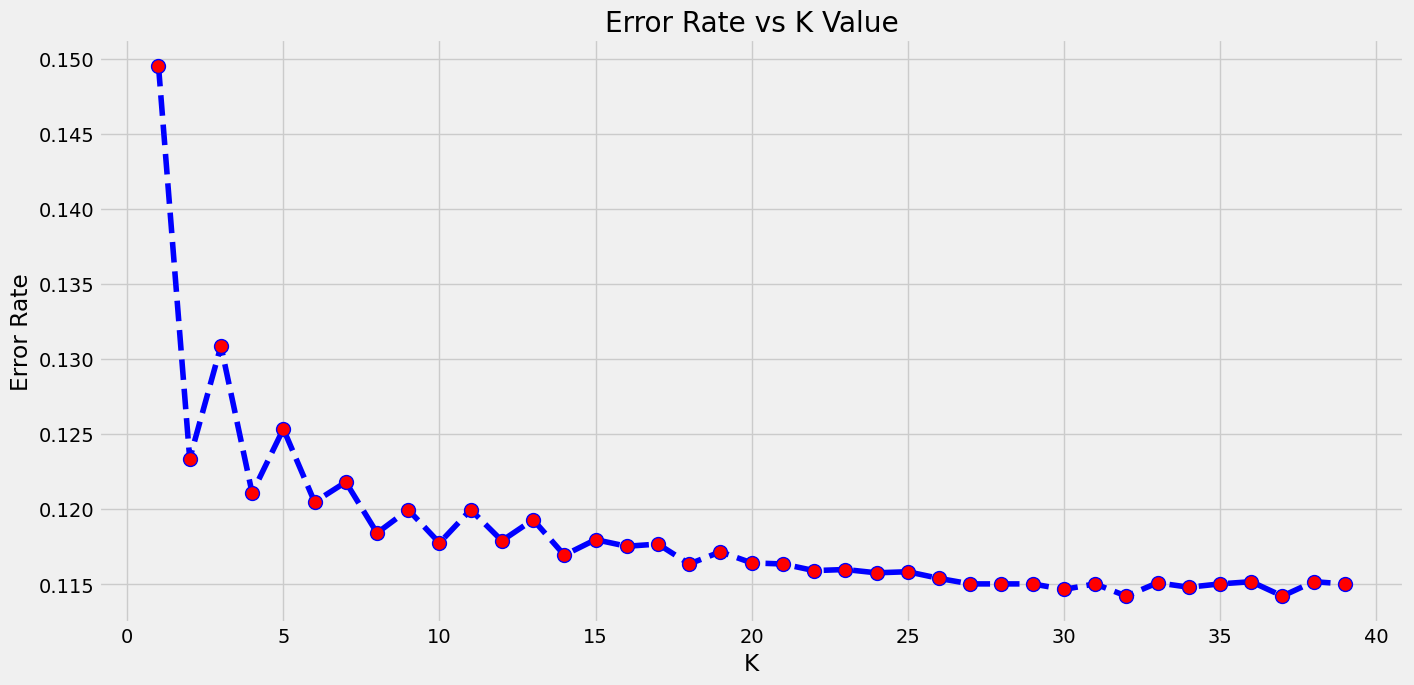

distance


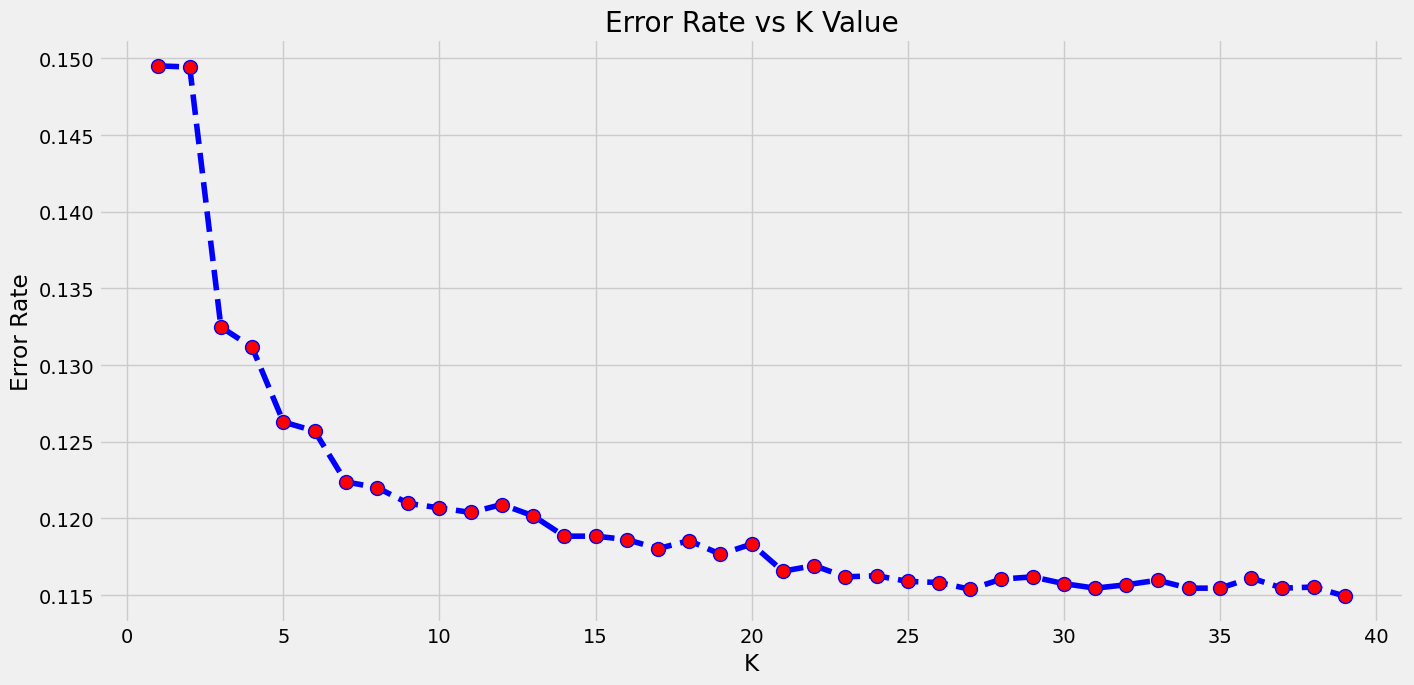

In [97]:
# Choosing a K Value
error_rate = {}
weights = ['uniform', 'distance']
for w in weights:
    print(w)
    rate = []
    for i in range(1, 40):
        knn = KNeighborsClassifier(n_neighbors = i, weights = w)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        rate.append(np.mean(y_pred != y_test))
    plt.figure(figsize = (15, 7.2))
    plt.plot(range(1, 40), rate, color = 'blue', linestyle = 'dashed', marker = 'o', 
             markerfacecolor = 'red', markersize = 10)
    plt.title('Error Rate vs K Value')
    plt.xlabel('K')
    plt.ylabel('Error Rate')
    plt.show()

In [98]:
# KNN with hyperparameter tuning
kNN = KNeighborsClassifier(n_jobs = -1)

params = {'n_neighbors': list(range(3, 40, 2)), 'weights': ['uniform', 'distance']}

scoring = {'Recall': make_scorer(recall_score), 'f1_score': make_scorer(f1_score)}

skf = StratifiedKFold(n_splits = 3, shuffle = True, random_state = random_state)

kNN_hyper = GridSearchCV(kNN, param_grid = params, n_jobs = -1, cv = skf, scoring = scoring, refit = 'f1_score')

kNN_hyper.fit(X_train, y_train)
print(kNN_hyper.best_estimator_)
print(kNN_hyper.best_params_)

KNeighborsClassifier(n_jobs=-1, n_neighbors=3, weights='distance')
{'n_neighbors': 3, 'weights': 'distance'}


In [99]:
# KNN with hyperparameter tuning
kNN_hyper = KNeighborsClassifier(algorithm = 'auto', leaf_size = 30, metric = 'minkowski', metric_params = None, 
                                 n_jobs = -1, n_neighbors = 3, p = 2, weights = 'distance')
base_model = [kNN_hyper]
n_splits = 5
df1 = train_and_predict(n_splits, base_model, Xs, y, 'k-Nearest Neighbor Scaled With Hyperparameter Tuning')
df = df.append(df1)
df

Model- K-nearest neighbor scaled with hyperparameter tuning and CV- 0
--------------------
Training Score: 1.000
Test Score: 0.886
Accuracy Score: 0.886
Precision Score - Subscribe: 0.518
Recall Score - Subscribe: 0.340
f1 Score - Subscribe: 0.411
Precision Score - Macro: 0.717
Recall Score - Macro: 0.649
f1 Score - Macro: 0.674


Model- K-nearest neighbor scaled with hyperparameter tuning and CV- 1
--------------------
Training Score: 1.000
Test Score: 0.884
Accuracy Score: 0.884
Precision Score - Subscribe: 0.504
Recall Score - Subscribe: 0.329
f1 Score - Subscribe: 0.398
Precision Score - Macro: 0.709
Recall Score - Macro: 0.643
f1 Score - Macro: 0.667


Model- K-nearest neighbor scaled with hyperparameter tuning and CV- 2
--------------------
Training Score: 1.000
Test Score: 0.888
Accuracy Score: 0.888
Precision Score - Subscribe: 0.533
Recall Score - Subscribe: 0.332
f1 Score - Subscribe: 0.409
Precision Score - Macro: 0.724
Recall Score - Macro: 0.647
f1 Score - Macro: 0.673


M

Accuracy  \
Baseline Model                                         0.882   
Logistic Regression Without Hyperparameter Tuning      0.898   
Logistic Regression With Hyperparameter Tuning         0.898   
k-Nearest Neighbor Scaled Without Hyperparamete...     0.891   
k-Nearest Neighbor Scaled With Hyperparameter T...     0.886   
Naive Bayes Classifier                                 0.815   
Logistic Regression Without Hyperparameter Tuning      0.898   
Logistic Regression With Hyperparameter Tuning         0.898   
k-Nearest Neighbor Scaled Without Hyperparamete...     0.891   
k-Nearest Neighbor Scaled With Hyperparameter T...     0.886   

                                                    Precision_Subscribe  \
Baseline Model                                                    0.000   
Logistic Regression Without Hyperparameter Tuning                 0.624   
Logistic Regression With Hyperparameter Tuning                    0.624   
k-Nearest Neighbor Scaled Without Hyperparamete...                0.566   
k-Nearest Neighbor Scaled With Hyperparameter T...                0.517   
Naive Bayes Classifier                                            0.320   
Logistic Regression Without Hyperparameter Tuning                 0.624   
Logistic Regression With Hyperparameter Tuning                    0.624   
k-Nearest Neighbor Scaled Without Hyperparamete...                0.566   
k-Nearest Neighbor Scaled With Hyperparameter T...                0.517   

                                                    Precision_Macro  \
Baseline Model                                                0.441   
Logistic Regression Without Hyperparameter Tuning             0.770   
Logistic Regression With Hyperparameter Tuning                0.770   
k-Nearest Neighbor Scaled Without Hyperparamete...            0.739   
k-Nearest Neighbor Scaled With Hyperparameter T...            0.716   
Naive Bayes Classifier                                        0.625   
Logistic Regression Without Hyperparameter Tuning             0.770   
Logistic Regression With Hyperparameter Tuning                0.770   
k-Nearest Neighbor Scaled Without Hyperparamete...            0.739   
k-Nearest Neighbor Scaled With Hyperparameter T...            0.716   

                                                    Recall_Subscribe  \
Baseline Model                                                 0.000   
Logistic Regression Without Hyperparameter Tuning              0.323   
Logistic Regression With Hyperparameter Tuning                 0.326   
k-Nearest Neighbor Scaled Without Hyperparamete...             0.300   
k-Nearest Neighbor Scaled With Hyperparameter T...             0.330   
Naive Bayes Classifier                                         0.520   
Logistic Regression Without Hyperparameter Tuning              0.323   
Logistic Regression With Hyperparameter Tuning                 0.326   
k-Nearest Neighbor Scaled Without Hyperparamete...             0.300   
k-Nearest Neighbor Scaled With Hyperparameter T...             0.330   

                                                    Recall_Macro  \
Baseline Model                                             0.500   
Logistic Regression Without Hyperparameter Tuning          0.648   
Logistic Regression With Hyperparameter Tuning             0.650   
k-Nearest Neighbor Scaled Without Hyperparamete...         0.635   
k-Nearest Neighbor Scaled With Hyperparameter T...         0.645   
Naive Bayes Classifier                                     0.687   
Logistic Regression Without Hyperparameter Tuning          0.648   
Logistic Regression With Hyperparameter Tuning             0.650   
k-Nearest Neighbor Scaled Without Hyperparamete...         0.635   
k-Nearest Neighbor Scaled With Hyperparameter T...         0.645   

                                                    f1_Subscribe  f1_Macro  
Baseline Model                                             0.000     0.469  
Logistic Regression Without Hyperparameter 

<a id='nb'></a>
#### Naive Bayes Classifier

In [100]:
# Naive Bayes Model
NB = GaussianNB()
base_model = [NB]
n_splits = 5
df1 = train_and_predict(n_splits, base_model, X, y, 'Naive Bayes Classifier')
df = df.append(df1)
df

Model- Naive bayes classifier and CV- 0
--------------------
Training Score: 0.814
Test Score: 0.814
Accuracy Score: 0.814
Precision Score - Subscribe: 0.314
Recall Score - Subscribe: 0.498
f1 Score - Subscribe: 0.385
Precision Score - Macro: 0.621
Recall Score - Macro: 0.677
f1 Score - Macro: 0.638


Model- Naive bayes classifier and CV- 1
--------------------
Training Score: 0.816
Test Score: 0.817
Accuracy Score: 0.817
Precision Score - Subscribe: 0.328
Recall Score - Subscribe: 0.536
f1 Score - Subscribe: 0.407
Precision Score - Macro: 0.630
Recall Score - Macro: 0.695
f1 Score - Macro: 0.649


Model- Naive bayes classifier and CV- 2
--------------------
Training Score: 0.816
Test Score: 0.815
Accuracy Score: 0.815
Precision Score - Subscribe: 0.323
Recall Score - Subscribe: 0.532
f1 Score - Subscribe: 0.402
Precision Score - Macro: 0.627
Recall Score - Macro: 0.692
f1 Score - Macro: 0.646


Model- Naive bayes classifier and CV- 3
--------------------
Training Score: 0.815
Test Sco

Accuracy  \
Baseline Model                                         0.882   
Logistic Regression Without Hyperparameter Tuning      0.898   
Logistic Regression With Hyperparameter Tuning         0.898   
k-Nearest Neighbor Scaled Without Hyperparamete...     0.891   
k-Nearest Neighbor Scaled With Hyperparameter T...     0.886   
Naive Bayes Classifier                                 0.815   
Logistic Regression Without Hyperparameter Tuning      0.898   
Logistic Regression With Hyperparameter Tuning         0.898   
k-Nearest Neighbor Scaled Without Hyperparamete...     0.891   
k-Nearest Neighbor Scaled With Hyperparameter T...     0.886   
Naive Bayes Classifier                                 0.815   

                                                    Precision_Subscribe  \
Baseline Model                                                    0.000   
Logistic Regression Without Hyperparameter Tuning                 0.624   
Logistic Regression With Hyperparameter Tuning                    0.624   
k-Nearest Neighbor Scaled Without Hyperparamete...                0.566   
k-Nearest Neighbor Scaled With Hyperparameter T...                0.517   
Naive Bayes Classifier                                            0.320   
Logistic Regression Without Hyperparameter Tuning                 0.624   
Logistic Regression With Hyperparameter Tuning                    0.624   
k-Nearest Neighbor Scaled Without Hyperparamete...                0.566   
k-Nearest Neighbor Scaled With Hyperparameter T...                0.517   
Naive Bayes Classifier                                            0.320   

                                                    Precision_Macro  \
Baseline Model                                                0.441   
Logistic Regression Without Hyperparameter Tuning             0.770   
Logistic Regression With Hyperparameter Tuning                0.770   
k-Nearest Neighbor Scaled Without Hyperparamete...            0.739   
k-Nearest Neighbor Scaled With Hyperparameter T...            0.716   
Naive Bayes Classifier                                        0.625   
Logistic Regression Without Hyperparameter Tuning             0.770   
Logistic Regression With Hyperparameter Tuning                0.770   
k-Nearest Neighbor Scaled Without Hyperparamete...            0.739   
k-Nearest Neighbor Scaled With Hyperparameter T...            0.716   
Naive Bayes Classifier                                        0.625   

                                                    Recall_Subscribe  \
Baseline Model                                                 0.000   
Logistic Regression Without Hyperparameter Tuning              0.323   
Logistic Regression With Hyperparameter Tuning                 0.326   
k-Nearest Neighbor Scaled Without Hyperparamete...             0.300   
k-Nearest Neighbor Scaled With Hyperparameter T...             0.330   
Naive Bayes Classifier                                         0.520   
Logistic Regression Without Hyperparameter Tuning              0.323   
Logistic Regression With Hyperparameter Tuning                 0.326   
k-Nearest Neighbor Scaled Without Hyperparamete...             0.300   
k-Nearest Neighbor Scaled With Hyperparameter T...             0.330   
Naive Bayes Classifier                                         0.520   

                                                    Recall_Macro  \
Baseline Model                                             0.500   
Logistic Regression Without Hyperparameter Tuning          0.648   
Logistic Regression With Hyperparameter Tuning             0.650   
k-Nearest Neighbor Scaled Without Hyperparamete...         0.635   
k-Nearest Neighbor Scaled With Hyperparameter T...         0.645   
Naive Bayes Classifier                                     0.687   
Logistic Regression Without Hyperparameter Tuning          0.648   
Logistic Regression With Hyperparameter Tuning             0.650   
k-Nearest Neighbor Scaled Without Hyperparamete...  

<a id='onb'></a>
#### Oversampling and Naive Bayes

In [101]:
# Naive Bayes with oversampling
NB_over = GaussianNB()
base_model = [NB_over]
n_splits = 5
df1 = train_and_predict(n_splits, base_model, X, y, 'Naive Bayes, Oversampled', 
                       oversampling = True)
df = df.append(df1)
df

Model- Naive bayes, oversampled and CV- 0
--------------------
Training Score: 0.734
Test Score: 0.717
Accuracy Score: 0.717
Precision Score - Subscribe: 0.246
Recall Score - Subscribe: 0.688
f1 Score - Subscribe: 0.362
Precision Score - Macro: 0.596
Recall Score - Macro: 0.704
f1 Score - Macro: 0.590


Model- Naive bayes, oversampled and CV- 1
--------------------
Training Score: 0.734
Test Score: 0.713
Accuracy Score: 0.713
Precision Score - Subscribe: 0.249
Recall Score - Subscribe: 0.722
f1 Score - Subscribe: 0.370
Precision Score - Macro: 0.600
Recall Score - Macro: 0.717
f1 Score - Macro: 0.592


Model- Naive bayes, oversampled and CV- 2
--------------------
Training Score: 0.735
Test Score: 0.703
Accuracy Score: 0.703
Precision Score - Subscribe: 0.241
Recall Score - Subscribe: 0.716
f1 Score - Subscribe: 0.360
Precision Score - Macro: 0.595
Recall Score - Macro: 0.708
f1 Score - Macro: 0.583


Model- Naive bayes, oversampled and CV- 3
--------------------
Training Score: 0.738


Accuracy  \
Baseline Model                                         0.882   
Logistic Regression Without Hyperparameter Tuning      0.898   
Logistic Regression With Hyperparameter Tuning         0.898   
k-Nearest Neighbor Scaled Without Hyperparamete...     0.891   
k-Nearest Neighbor Scaled With Hyperparameter T...     0.886   
Naive Bayes Classifier                                 0.815   
Logistic Regression Without Hyperparameter Tuning      0.898   
Logistic Regression With Hyperparameter Tuning         0.898   
k-Nearest Neighbor Scaled Without Hyperparamete...     0.891   
k-Nearest Neighbor Scaled With Hyperparameter T...     0.886   
Naive Bayes Classifier                                 0.815   
Naive Bayes, Oversampled                               0.717   

                                                    Precision_Subscribe  \
Baseline Model                                                    0.000   
Logistic Regression Without Hyperparameter Tuning                 0.624   
Logistic Regression With Hyperparameter Tuning                    0.624   
k-Nearest Neighbor Scaled Without Hyperparamete...                0.566   
k-Nearest Neighbor Scaled With Hyperparameter T...                0.517   
Naive Bayes Classifier                                            0.320   
Logistic Regression Without Hyperparameter Tuning                 0.624   
Logistic Regression With Hyperparameter Tuning                    0.624   
k-Nearest Neighbor Scaled Without Hyperparamete...                0.566   
k-Nearest Neighbor Scaled With Hyperparameter T...                0.517   
Naive Bayes Classifier                                            0.320   
Naive Bayes, Oversampled                                          0.249   

                                                    Precision_Macro  \
Baseline Model                                                0.441   
Logistic Regression Without Hyperparameter Tuning             0.770   
Logistic Regression With Hyperparameter Tuning                0.770   
k-Nearest Neighbor Scaled Without Hyperparamete...            0.739   
k-Nearest Neighbor Scaled With Hyperparameter T...            0.716   
Naive Bayes Classifier                                        0.625   
Logistic Regression Without Hyperparameter Tuning             0.770   
Logistic Regression With Hyperparameter Tuning                0.770   
k-Nearest Neighbor Scaled Without Hyperparamete...            0.739   
k-Nearest Neighbor Scaled With Hyperparameter T...            0.716   
Naive Bayes Classifier                                        0.625   
Naive Bayes, Oversampled                                      0.599   

                                                    Recall_Subscribe  \
Baseline Model                                                 0.000   
Logistic Regression Without Hyperparameter Tuning              0.323   
Logistic Regression With Hyperparameter Tuning                 0.326   
k-Nearest Neighbor Scaled Without Hyperparamete...             0.300   
k-Nearest Neighbor Scaled With Hyperparameter T...             0.330   
Naive Bayes Classifier                                         0.520   
Logistic Regression Without Hyperparameter Tuning              0.323   
Logistic Regression With Hyperparameter Tuning                 0.326   
k-Nearest Neighbor Scaled Without Hyperparamete...             0.300   
k-Nearest Neighbor Scaled With Hyperparameter T...             0.330   
Naive Bayes Classifier                                         0.520   
Naive Bayes, Oversampled                                       0.707   

                                                    Recall_Macro  \
Baseline Model                                             0.500   
Logistic Regression Without Hyperparameter Tuning          0.648   
Logistic Regression With Hyperparameter Tuning             0.650   
k-Nearest Neighbor Scaled Without Hyperparamete...         0.635   
k-Nearest Neighbor Scaled With Hyperparame

<a id='olr'></a>
#### Oversampling and Logistic Regression

In [106]:
# LR model with oversampling
LR_over = LogisticRegression(C = 1, class_weight = None, dual = False, fit_intercept = True, 
                              intercept_scaling = 1, l1_ratio = None, max_iter = 100,
                              multi_class = 'auto', n_jobs = -1, penalty = 'l2', random_state = 42,
                              solver = 'lbfgs', tol = 0.0001, verbose = 0, warm_start = False)
base_model = [LR_over]
n_splits = 5
df1 = train_and_predict(n_splits, base_model, X, y, 'Logistic Regression, Oversampled With Hyperparameter Tuning', 
                       oversampling = True)
df = df.append(df1)
df

Model- Logistic regression, oversampled with hyperparameter tuning and CV- 0
--------------------
Training Score: 0.824
Test Score: 0.831
Accuracy Score: 0.831
Precision Score - Subscribe: 0.391
Recall Score - Subscribe: 0.794
f1 Score - Subscribe: 0.524
Precision Score - Macro: 0.680
Recall Score - Macro: 0.815
f1 Score - Macro: 0.711


Model- Logistic regression, oversampled with hyperparameter tuning and CV- 1
--------------------
Training Score: 0.822
Test Score: 0.832
Accuracy Score: 0.832
Precision Score - Subscribe: 0.393
Recall Score - Subscribe: 0.800
f1 Score - Subscribe: 0.527
Precision Score - Macro: 0.681
Recall Score - Macro: 0.818
f1 Score - Macro: 0.712


Model- Logistic regression, oversampled with hyperparameter tuning and CV- 2
--------------------
Training Score: 0.825
Test Score: 0.826
Accuracy Score: 0.826
Precision Score - Subscribe: 0.381
Recall Score - Subscribe: 0.780
f1 Score - Subscribe: 0.511
Precision Score - Macro: 0.673
Recall Score - Macro: 0.806
f1 Sco

Accuracy  \
Baseline Model                                         0.882   
Logistic Regression Without Hyperparameter Tuning      0.898   
Logistic Regression With Hyperparameter Tuning         0.898   
k-Nearest Neighbor Scaled Without Hyperparamete...     0.891   
k-Nearest Neighbor Scaled With Hyperparameter T...     0.886   
Naive Bayes Classifier                                 0.815   
Logistic Regression Without Hyperparameter Tuning      0.898   
Logistic Regression With Hyperparameter Tuning         0.898   
k-Nearest Neighbor Scaled Without Hyperparamete...     0.891   
k-Nearest Neighbor Scaled With Hyperparameter T...     0.886   
Naive Bayes Classifier                                 0.815   
Naive Bayes, Oversampled                               0.717   
Logistic Regression, Oversampled With Hyperpara...     0.830   

                                                    Precision_Subscribe  \
Baseline Model                                                    0.000   
Logistic Regression Without Hyperparameter Tuning                 0.624   
Logistic Regression With Hyperparameter Tuning                    0.624   
k-Nearest Neighbor Scaled Without Hyperparamete...                0.566   
k-Nearest Neighbor Scaled With Hyperparameter T...                0.517   
Naive Bayes Classifier                                            0.320   
Logistic Regression Without Hyperparameter Tuning                 0.624   
Logistic Regression With Hyperparameter Tuning                    0.624   
k-Nearest Neighbor Scaled Without Hyperparamete...                0.566   
k-Nearest Neighbor Scaled With Hyperparameter T...                0.517   
Naive Bayes Classifier                                            0.320   
Naive Bayes, Oversampled                                          0.249   
Logistic Regression, Oversampled With Hyperpara...                0.388   

                                                    Precision_Macro  \
Baseline Model                                                0.441   
Logistic Regression Without Hyperparameter Tuning             0.770   
Logistic Regression With Hyperparameter Tuning                0.770   
k-Nearest Neighbor Scaled Without Hyperparamete...            0.739   
k-Nearest Neighbor Scaled With Hyperparameter T...            0.716   
Naive Bayes Classifier                                        0.625   
Logistic Regression Without Hyperparameter Tuning             0.770   
Logistic Regression With Hyperparameter Tuning                0.770   
k-Nearest Neighbor Scaled Without Hyperparamete...            0.739   
k-Nearest Neighbor Scaled With Hyperparameter T...            0.716   
Naive Bayes Classifier                                        0.625   
Naive Bayes, Oversampled                                      0.599   
Logistic Regression, Oversampled With Hyperpara...            0.678   

                                                    Recall_Subscribe  \
Baseline Model                                                 0.000   
Logistic Regression Without Hyperparameter Tuning              0.323   
Logistic Regression With Hyperparameter Tuning                 0.326   
k-Nearest Neighbor Scaled Without Hyperparamete...             0.300   
k-Nearest Neighbor Scaled With Hyperparameter T...             0.330   
Naive Bayes Classifier                                         0.520   
Logistic Regression Without Hyperparameter Tuning              0.323   
Logistic Regression With Hyperparameter Tuning                 0.326   
k-Nearest Neighbor Scaled Without Hyperparamete...             0.300   
k-Nearest Neighbor Scaled With Hyperparameter T...             0.330   
Naive Bayes Classifier                                         0.520   
Naive Bayes, Oversampled                                       0.707   
Logistic Regression, Oversampled With Hyperpara...             0.786   

                                                    Recall_Macro  \
Baseline Model                  

<a id='et'></a>
### Ensemble Techniques
Decision Tree Classifier, Bagging Classifier, AdaBoost Classifier, Gradient Boosting Classifier and Random Forest Classifier. Oversampling the ones with higher accuracy and better recall for subscribe.

<a id='dt'></a>
#### Decision Tree Classifier

In [107]:
# Decision Tree Classifier
DT = DecisionTreeClassifier(random_state = random_state)
base_model = [DT]
n_splits = 5
df1 = train_and_predict(n_splits, base_model, X, y, 'Decision Tree Classifier')
df = df.append(df1)
df

Model- Decision tree classifier and CV- 0
--------------------
Training Score: 1.000
Test Score: 0.876
Accuracy Score: 0.876
Precision Score - Subscribe: 0.471
Recall Score - Subscribe: 0.473
f1 Score - Subscribe: 0.472
Precision Score - Macro: 0.700
Recall Score - Macro: 0.701
f1 Score - Macro: 0.701


Model- Decision tree classifier and CV- 1
--------------------
Training Score: 1.000
Test Score: 0.878
Accuracy Score: 0.878
Precision Score - Subscribe: 0.479
Recall Score - Subscribe: 0.500
f1 Score - Subscribe: 0.489
Precision Score - Macro: 0.706
Recall Score - Macro: 0.714
f1 Score - Macro: 0.710


Model- Decision tree classifier and CV- 2
--------------------
Training Score: 1.000
Test Score: 0.878
Accuracy Score: 0.878
Precision Score - Subscribe: 0.477
Recall Score - Subscribe: 0.479
f1 Score - Subscribe: 0.478
Precision Score - Macro: 0.704
Recall Score - Macro: 0.705
f1 Score - Macro: 0.705


Model- Decision tree classifier and CV- 3
--------------------
Training Score: 1.000


Accuracy  \
Baseline Model                                         0.882   
Logistic Regression Without Hyperparameter Tuning      0.898   
Logistic Regression With Hyperparameter Tuning         0.898   
k-Nearest Neighbor Scaled Without Hyperparamete...     0.891   
k-Nearest Neighbor Scaled With Hyperparameter T...     0.886   
Naive Bayes Classifier                                 0.815   
Logistic Regression Without Hyperparameter Tuning      0.898   
Logistic Regression With Hyperparameter Tuning         0.898   
k-Nearest Neighbor Scaled Without Hyperparamete...     0.891   
k-Nearest Neighbor Scaled With Hyperparameter T...     0.886   
Naive Bayes Classifier                                 0.815   
Naive Bayes, Oversampled                               0.717   
Logistic Regression, Oversampled With Hyperpara...     0.830   
Decision Tree Classifier                               0.875   

                                                    Precision_Subscribe  \
Baseline Model                                                    0.000   
Logistic Regression Without Hyperparameter Tuning                 0.624   
Logistic Regression With Hyperparameter Tuning                    0.624   
k-Nearest Neighbor Scaled Without Hyperparamete...                0.566   
k-Nearest Neighbor Scaled With Hyperparameter T...                0.517   
Naive Bayes Classifier                                            0.320   
Logistic Regression Without Hyperparameter Tuning                 0.624   
Logistic Regression With Hyperparameter Tuning                    0.624   
k-Nearest Neighbor Scaled Without Hyperparamete...                0.566   
k-Nearest Neighbor Scaled With Hyperparameter T...                0.517   
Naive Bayes Classifier                                            0.320   
Naive Bayes, Oversampled                                          0.249   
Logistic Regression, Oversampled With Hyperpara...                0.388   
Decision Tree Classifier                                          0.467   

                                                    Precision_Macro  \
Baseline Model                                                0.441   
Logistic Regression Without Hyperparameter Tuning             0.770   
Logistic Regression With Hyperparameter Tuning                0.770   
k-Nearest Neighbor Scaled Without Hyperparamete...            0.739   
k-Nearest Neighbor Scaled With Hyperparameter T...            0.716   
Naive Bayes Classifier                                        0.625   
Logistic Regression Without Hyperparameter Tuning             0.770   
Logistic Regression With Hyperparameter Tuning                0.770   
k-Nearest Neighbor Scaled Without Hyperparamete...            0.739   
k-Nearest Neighbor Scaled With Hyperparameter T...            0.716   
Naive Bayes Classifier                                        0.625   
Naive Bayes, Oversampled                                      0.599   
Logistic Regression, Oversampled With Hyperpara...            0.678   
Decision Tree Classifier                                      0.698   

                                                    Recall_Subscribe  \
Baseline Model                                                 0.000   
Logistic Regression Without Hyperparameter Tuning              0.323   
Logistic Regression With Hyperparameter Tuning                 0.326   
k-Nearest Neighbor Scaled Without Hyperparamete...             0.300   
k-Nearest Neighbor Scaled With Hyperparameter T...             0.330   
Naive Bayes Classifier                                         0.520   
Logistic Regression Without Hyperparameter Tuning              0.323   
Logistic Regression With Hyperparameter Tuning                 0.326   
k-Nearest Neighbor Scaled Without Hyperparamete...             0.300   
k-Nearest Neighbor Scaled With Hyperparameter T...             0.330   
Naive Bayes Classifier                                         0.520   
Naive Bayes, Oversampled           

In [108]:
# Decision Tree Classifier with hyperparameter tuning
dt_hyper = DecisionTreeClassifier(max_depth = 3, random_state = random_state)
base_model = [dt_hyper]
n_splits = 5
df1 = train_and_predict(n_splits, base_model, X, y, 'Decision Tree Classifier - Reducing Max Depth')
df = df.append(df1)
df

Model- Decision tree classifier - reducing max depth and CV- 0
--------------------
Training Score: 0.898
Test Score: 0.902
Accuracy Score: 0.902
Precision Score - Subscribe: 0.674
Recall Score - Subscribe: 0.313
f1 Score - Subscribe: 0.427
Precision Score - Macro: 0.795
Recall Score - Macro: 0.646
f1 Score - Macro: 0.687


Model- Decision tree classifier - reducing max depth and CV- 1
--------------------
Training Score: 0.900
Test Score: 0.898
Accuracy Score: 0.898
Precision Score - Subscribe: 0.665
Recall Score - Subscribe: 0.250
f1 Score - Subscribe: 0.363
Precision Score - Macro: 0.787
Recall Score - Macro: 0.617
f1 Score - Macro: 0.654


Model- Decision tree classifier - reducing max depth and CV- 2
--------------------
Training Score: 0.899
Test Score: 0.897
Accuracy Score: 0.897
Precision Score - Subscribe: 0.611
Recall Score - Subscribe: 0.325
f1 Score - Subscribe: 0.424
Precision Score - Macro: 0.763
Recall Score - Macro: 0.649
f1 Score - Macro: 0.684


Model- Decision tree c

Accuracy  \
Baseline Model                                         0.882   
Logistic Regression Without Hyperparameter Tuning      0.898   
Logistic Regression With Hyperparameter Tuning         0.898   
k-Nearest Neighbor Scaled Without Hyperparamete...     0.891   
k-Nearest Neighbor Scaled With Hyperparameter T...     0.886   
Naive Bayes Classifier                                 0.815   
Logistic Regression Without Hyperparameter Tuning      0.898   
Logistic Regression With Hyperparameter Tuning         0.898   
k-Nearest Neighbor Scaled Without Hyperparamete...     0.891   
k-Nearest Neighbor Scaled With Hyperparameter T...     0.886   
Naive Bayes Classifier                                 0.815   
Naive Bayes, Oversampled                               0.717   
Logistic Regression, Oversampled With Hyperpara...     0.830   
Decision Tree Classifier                               0.875   
Decision Tree Classifier - Reducing Max Depth          0.898   

                                                    Precision_Subscribe  \
Baseline Model                                                    0.000   
Logistic Regression Without Hyperparameter Tuning                 0.624   
Logistic Regression With Hyperparameter Tuning                    0.624   
k-Nearest Neighbor Scaled Without Hyperparamete...                0.566   
k-Nearest Neighbor Scaled With Hyperparameter T...                0.517   
Naive Bayes Classifier                                            0.320   
Logistic Regression Without Hyperparameter Tuning                 0.624   
Logistic Regression With Hyperparameter Tuning                    0.624   
k-Nearest Neighbor Scaled Without Hyperparamete...                0.566   
k-Nearest Neighbor Scaled With Hyperparameter T...                0.517   
Naive Bayes Classifier                                            0.320   
Naive Bayes, Oversampled                                          0.249   
Logistic Regression, Oversampled With Hyperpara...                0.388   
Decision Tree Classifier                                          0.467   
Decision Tree Classifier - Reducing Max Depth                     0.647   

                                                    Precision_Macro  \
Baseline Model                                                0.441   
Logistic Regression Without Hyperparameter Tuning             0.770   
Logistic Regression With Hyperparameter Tuning                0.770   
k-Nearest Neighbor Scaled Without Hyperparamete...            0.739   
k-Nearest Neighbor Scaled With Hyperparameter T...            0.716   
Naive Bayes Classifier                                        0.625   
Logistic Regression Without Hyperparameter Tuning             0.770   
Logistic Regression With Hyperparameter Tuning                0.770   
k-Nearest Neighbor Scaled Without Hyperparamete...            0.739   
k-Nearest Neighbor Scaled With Hyperparameter T...            0.716   
Naive Bayes Classifier                                        0.625   
Naive Bayes, Oversampled                                      0.599   
Logistic Regression, Oversampled With Hyperpara...            0.678   
Decision Tree Classifier                                      0.698   
Decision Tree Classifier - Reducing Max Depth                 0.780   

                                                    Recall_Subscribe  \
Baseline Model                                                 0.000   
Logistic Regression Without Hyperparameter Tuning              0.323   
Logistic Regression With Hyperparameter Tuning                 0.326   
k-Nearest Neighbor Scaled Without Hyperparamete...             0.300   
k-Nearest Neighbor Scaled With Hyperparameter T...             0.330   
Naive Bayes Classifier                                         0.520   
Logistic Regression Without Hyperparameter Tuning              0.323   
Logistic Regression With Hyperparameter Tuning                 0.326   
k-Nearest Neighbor Scaled Without Hyperpa

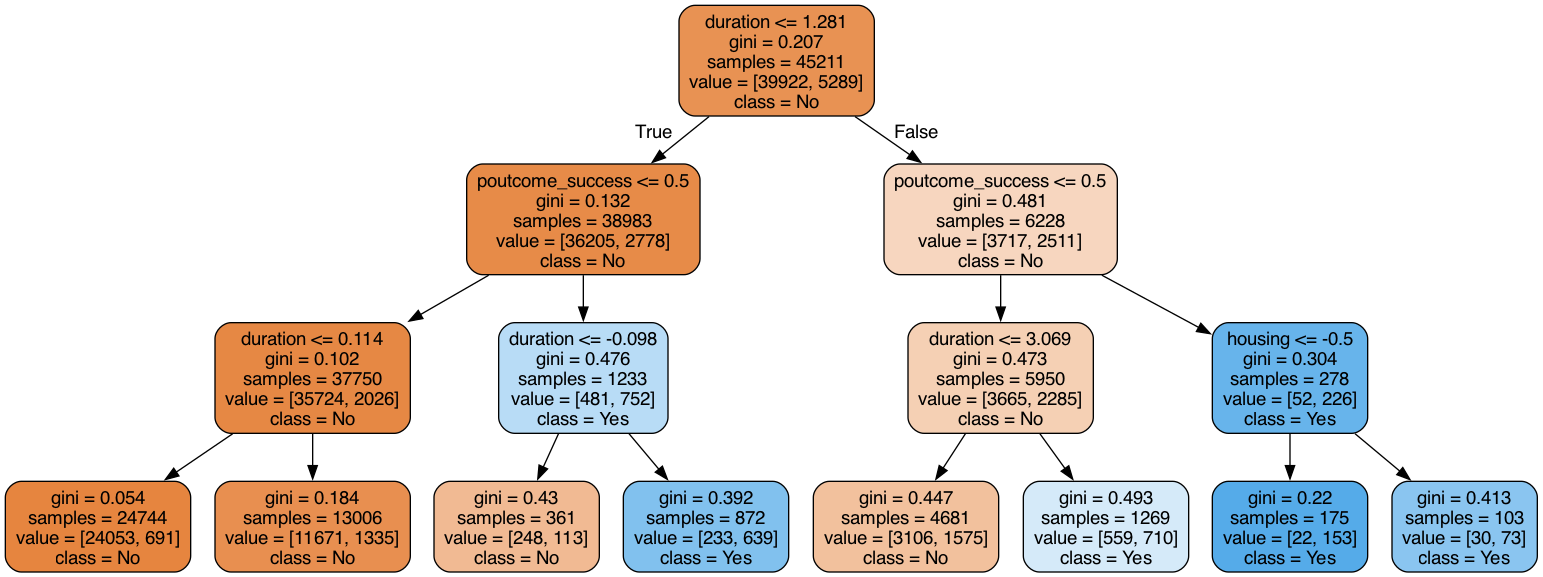

In [125]:
dt_hyper = DecisionTreeClassifier(max_depth = 3, random_state = random_state)
dt_hyper.fit(X, y)
decisiontree = open('decisiontree.dot','w')
dot_data = export_graphviz(dt_hyper, out_file = 'decisiontree.dot', feature_names = X.columns,
    class_names = ['No', 'Yes'], rounded = True, proportion = False, filled = True)
decisiontree.close()

retCode = system('dot -Tpng decisiontree.dot -o decisiontree.png')
if(retCode>0):
    print('system command returning error: '+str(retCode))
else:
    display(Image('decisiontree.png'))

Feature Importance for Decision Tree Classifier  ----------------------------------------------------------------------------


<AxesSubplot:>

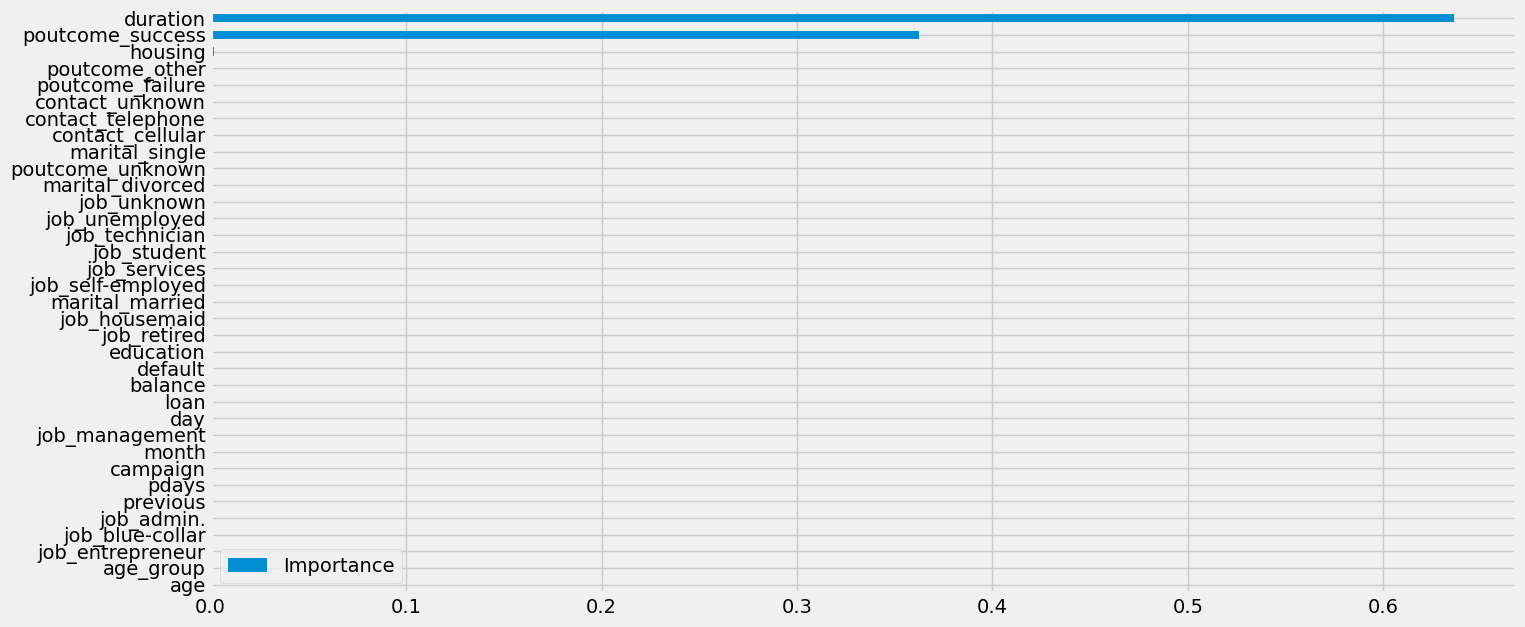

In [110]:
print('Feature Importance for Decision Tree Classifier ', '--'*38)
feature_importances = pd.DataFrame(dt_hyper.feature_importances_, index = X.columns, 
                                   columns=['Importance']).sort_values('Importance', ascending = True)
feature_importances.sort_values(by = 'Importance', ascending = True).plot(kind = 'barh', figsize = (15, 7.2))

<a id='bag'></a>
#### Bagging, AdaBoost, Gradient Boosting Classifier

In [111]:
# Bagging Classifier
bgcl = BaggingClassifier(base_estimator = DecisionTreeClassifier(max_depth = 3, random_state = random_state), 
                         n_estimators = 50, random_state = random_state)
base_model = [bgcl]
n_splits = 5
df1 = train_and_predict(n_splits, base_model, X, y, 'Bagging Classifier')
df = df.append(df1)
df

Model- Bagging classifier and CV- 0
--------------------
Training Score: 0.898
Test Score: 0.901
Accuracy Score: 0.901
Precision Score - Subscribe: 0.665
Recall Score - Subscribe: 0.314
f1 Score - Subscribe: 0.426
Precision Score - Macro: 0.790
Recall Score - Macro: 0.646
f1 Score - Macro: 0.686


Model- Bagging classifier and CV- 1
--------------------
Training Score: 0.900
Test Score: 0.898
Accuracy Score: 0.898
Precision Score - Subscribe: 0.656
Recall Score - Subscribe: 0.271
f1 Score - Subscribe: 0.383
Precision Score - Macro: 0.783
Recall Score - Macro: 0.626
f1 Score - Macro: 0.664


Model- Bagging classifier and CV- 2
--------------------
Training Score: 0.900
Test Score: 0.900
Accuracy Score: 0.900
Precision Score - Subscribe: 0.662
Recall Score - Subscribe: 0.290
f1 Score - Subscribe: 0.403
Precision Score - Macro: 0.787
Recall Score - Macro: 0.635
f1 Score - Macro: 0.674


Model- Bagging classifier and CV- 3
--------------------
Training Score: 0.899
Test Score: 0.899
Accura

Accuracy  \
Baseline Model                                         0.882   
Logistic Regression Without Hyperparameter Tuning      0.898   
Logistic Regression With Hyperparameter Tuning         0.898   
k-Nearest Neighbor Scaled Without Hyperparamete...     0.891   
k-Nearest Neighbor Scaled With Hyperparameter T...     0.886   
Naive Bayes Classifier                                 0.815   
Logistic Regression Without Hyperparameter Tuning      0.898   
Logistic Regression With Hyperparameter Tuning         0.898   
k-Nearest Neighbor Scaled Without Hyperparamete...     0.891   
k-Nearest Neighbor Scaled With Hyperparameter T...     0.886   
Naive Bayes Classifier                                 0.815   
Naive Bayes, Oversampled                               0.717   
Logistic Regression, Oversampled With Hyperpara...     0.830   
Decision Tree Classifier                               0.875   
Decision Tree Classifier - Reducing Max Depth          0.898   
Bagging Classifier                                     0.899   

                                                    Precision_Subscribe  \
Baseline Model                                                    0.000   
Logistic Regression Without Hyperparameter Tuning                 0.624   
Logistic Regression With Hyperparameter Tuning                    0.624   
k-Nearest Neighbor Scaled Without Hyperparamete...                0.566   
k-Nearest Neighbor Scaled With Hyperparameter T...                0.517   
Naive Bayes Classifier                                            0.320   
Logistic Regression Without Hyperparameter Tuning                 0.624   
Logistic Regression With Hyperparameter Tuning                    0.624   
k-Nearest Neighbor Scaled Without Hyperparamete...                0.566   
k-Nearest Neighbor Scaled With Hyperparameter T...                0.517   
Naive Bayes Classifier                                            0.320   
Naive Bayes, Oversampled                                          0.249   
Logistic Regression, Oversampled With Hyperpara...                0.388   
Decision Tree Classifier                                          0.467   
Decision Tree Classifier - Reducing Max Depth                     0.647   
Bagging Classifier                                                0.651   

                                                    Precision_Macro  \
Baseline Model                                                0.441   
Logistic Regression Without Hyperparameter Tuning             0.770   
Logistic Regression With Hyperparameter Tuning                0.770   
k-Nearest Neighbor Scaled Without Hyperparamete...            0.739   
k-Nearest Neighbor Scaled With Hyperparameter T...            0.716   
Naive Bayes Classifier                                        0.625   
Logistic Regression Without Hyperparameter Tuning             0.770   
Logistic Regression With Hyperparameter Tuning                0.770   
k-Nearest Neighbor Scaled Without Hyperparamete...            0.739   
k-Nearest Neighbor Scaled With Hyperparameter T...            0.716   
Naive Bayes Classifier                                        0.625   
Naive Bayes, Oversampled                                      0.599   
Logistic Regression, Oversampled With Hyperpara...            0.678   
Decision Tree Classifier                                      0.698   
Decision Tree Classifier - Reducing Max Depth                 0.780   
Bagging Classifier                                            0.781   

                                                    Recall_Subscribe  \
Baseline Model                                                 0.000   
Logistic Regression Without Hyperparameter Tuning              0.323   
Logistic Regression With Hyperparameter Tuning                 0.326   
k-Nearest Neighbor Scaled Without Hyperparamete...             0.300   
k-Nearest Neighbor Scaled With Hyperparameter T...             0.330   
Naive Bayes Classifier                         

In [112]:
# AdaBoost Classifier
abcl = AdaBoostClassifier(n_estimators = 10, random_state = random_state)
base_model = [abcl]
n_splits = 5
df1 = train_and_predict(n_splits, base_model, X, y, 'AdaBoost Classifier')
df = df.append(df1)
df

Model- Adaboost classifier and CV- 0
--------------------
Training Score: 0.895
Test Score: 0.897
Accuracy Score: 0.897
Precision Score - Subscribe: 0.606
Recall Score - Subscribe: 0.349
f1 Score - Subscribe: 0.443
Precision Score - Macro: 0.762
Recall Score - Macro: 0.659
f1 Score - Macro: 0.693


Model- Adaboost classifier and CV- 1
--------------------
Training Score: 0.891
Test Score: 0.889
Accuracy Score: 0.889
Precision Score - Subscribe: 0.533
Recall Score - Subscribe: 0.385
f1 Score - Subscribe: 0.447
Precision Score - Macro: 0.727
Recall Score - Macro: 0.670
f1 Score - Macro: 0.693


Model- Adaboost classifier and CV- 2
--------------------
Training Score: 0.891
Test Score: 0.890
Accuracy Score: 0.890
Precision Score - Subscribe: 0.545
Recall Score - Subscribe: 0.363
f1 Score - Subscribe: 0.436
Precision Score - Macro: 0.732
Recall Score - Macro: 0.661
f1 Score - Macro: 0.687


Model- Adaboost classifier and CV- 3
--------------------
Training Score: 0.892
Test Score: 0.894
Ac

Accuracy  \
Baseline Model                                         0.882   
Logistic Regression Without Hyperparameter Tuning      0.898   
Logistic Regression With Hyperparameter Tuning         0.898   
k-Nearest Neighbor Scaled Without Hyperparamete...     0.891   
k-Nearest Neighbor Scaled With Hyperparameter T...     0.886   
Naive Bayes Classifier                                 0.815   
Logistic Regression Without Hyperparameter Tuning      0.898   
Logistic Regression With Hyperparameter Tuning         0.898   
k-Nearest Neighbor Scaled Without Hyperparamete...     0.891   
k-Nearest Neighbor Scaled With Hyperparameter T...     0.886   
Naive Bayes Classifier                                 0.815   
Naive Bayes, Oversampled                               0.717   
Logistic Regression, Oversampled With Hyperpara...     0.830   
Decision Tree Classifier                               0.875   
Decision Tree Classifier - Reducing Max Depth          0.898   
Bagging Classifier                                     0.899   
AdaBoost Classifier                                    0.892   

                                                    Precision_Subscribe  \
Baseline Model                                                    0.000   
Logistic Regression Without Hyperparameter Tuning                 0.624   
Logistic Regression With Hyperparameter Tuning                    0.624   
k-Nearest Neighbor Scaled Without Hyperparamete...                0.566   
k-Nearest Neighbor Scaled With Hyperparameter T...                0.517   
Naive Bayes Classifier                                            0.320   
Logistic Regression Without Hyperparameter Tuning                 0.624   
Logistic Regression With Hyperparameter Tuning                    0.624   
k-Nearest Neighbor Scaled Without Hyperparamete...                0.566   
k-Nearest Neighbor Scaled With Hyperparameter T...                0.517   
Naive Bayes Classifier                                            0.320   
Naive Bayes, Oversampled                                          0.249   
Logistic Regression, Oversampled With Hyperpara...                0.388   
Decision Tree Classifier                                          0.467   
Decision Tree Classifier - Reducing Max Depth                     0.647   
Bagging Classifier                                                0.651   
AdaBoost Classifier                                               0.560   

                                                    Precision_Macro  \
Baseline Model                                                0.441   
Logistic Regression Without Hyperparameter Tuning             0.770   
Logistic Regression With Hyperparameter Tuning                0.770   
k-Nearest Neighbor Scaled Without Hyperparamete...            0.739   
k-Nearest Neighbor Scaled With Hyperparameter T...            0.716   
Naive Bayes Classifier                                        0.625   
Logistic Regression Without Hyperparameter Tuning             0.770   
Logistic Regression With Hyperparameter Tuning                0.770   
k-Nearest Neighbor Scaled Without Hyperparamete...            0.739   
k-Nearest Neighbor Scaled With Hyperparameter T...            0.716   
Naive Bayes Classifier                                        0.625   
Naive Bayes, Oversampled                                      0.599   
Logistic Regression, Oversampled With Hyperpara...            0.678   
Decision Tree Classifier                                      0.698   
Decision Tree Classifier - Reducing Max Depth                 0.780   
Bagging Classifier                                            0.781   
AdaBoost Classifier                                           0.739   

                                                    Recall_Subscribe  \
Baseline Model                                                 0.000   
Logistic Regression Without Hyperparameter Tuning              0.323   
Logistic Regression With Hyperparameter Tuning       

In [113]:
# Gradient Boosting Classifier
gbcl = GradientBoostingClassifier(n_estimators = 50, random_state = random_state)
base_model = [gbcl]
n_splits = 5
df1 = train_and_predict(n_splits, base_model, X, y, 'Gradient Boosting Classifier')
df = df.append(df1)
df

Model- Gradient boosting classifier and CV- 0
--------------------
Training Score: 0.903
Test Score: 0.904
Accuracy Score: 0.904
Precision Score - Subscribe: 0.687
Recall Score - Subscribe: 0.328
f1 Score - Subscribe: 0.444
Precision Score - Macro: 0.802
Recall Score - Macro: 0.654
f1 Score - Macro: 0.696


Model- Gradient boosting classifier and CV- 1
--------------------
Training Score: 0.905
Test Score: 0.901
Accuracy Score: 0.901
Precision Score - Subscribe: 0.650
Recall Score - Subscribe: 0.334
f1 Score - Subscribe: 0.441
Precision Score - Macro: 0.784
Recall Score - Macro: 0.655
f1 Score - Macro: 0.694


Model- Gradient boosting classifier and CV- 2
--------------------
Training Score: 0.905
Test Score: 0.901
Accuracy Score: 0.901
Precision Score - Subscribe: 0.651
Recall Score - Subscribe: 0.324
f1 Score - Subscribe: 0.433
Precision Score - Macro: 0.783
Recall Score - Macro: 0.651
f1 Score - Macro: 0.689


Model- Gradient boosting classifier and CV- 3
--------------------
Traini

Accuracy  \
Baseline Model                                         0.882   
Logistic Regression Without Hyperparameter Tuning      0.898   
Logistic Regression With Hyperparameter Tuning         0.898   
k-Nearest Neighbor Scaled Without Hyperparamete...     0.891   
k-Nearest Neighbor Scaled With Hyperparameter T...     0.886   
Naive Bayes Classifier                                 0.815   
Logistic Regression Without Hyperparameter Tuning      0.898   
Logistic Regression With Hyperparameter Tuning         0.898   
k-Nearest Neighbor Scaled Without Hyperparamete...     0.891   
k-Nearest Neighbor Scaled With Hyperparameter T...     0.886   
Naive Bayes Classifier                                 0.815   
Naive Bayes, Oversampled                               0.717   
Logistic Regression, Oversampled With Hyperpara...     0.830   
Decision Tree Classifier                               0.875   
Decision Tree Classifier - Reducing Max Depth          0.898   
Bagging Classifier                                     0.899   
AdaBoost Classifier                                    0.892   
Gradient Boosting Classifier                           0.901   

                                                    Precision_Subscribe  \
Baseline Model                                                    0.000   
Logistic Regression Without Hyperparameter Tuning                 0.624   
Logistic Regression With Hyperparameter Tuning                    0.624   
k-Nearest Neighbor Scaled Without Hyperparamete...                0.566   
k-Nearest Neighbor Scaled With Hyperparameter T...                0.517   
Naive Bayes Classifier                                            0.320   
Logistic Regression Without Hyperparameter Tuning                 0.624   
Logistic Regression With Hyperparameter Tuning                    0.624   
k-Nearest Neighbor Scaled Without Hyperparamete...                0.566   
k-Nearest Neighbor Scaled With Hyperparameter T...                0.517   
Naive Bayes Classifier                                            0.320   
Naive Bayes, Oversampled                                          0.249   
Logistic Regression, Oversampled With Hyperpara...                0.388   
Decision Tree Classifier                                          0.467   
Decision Tree Classifier - Reducing Max Depth                     0.647   
Bagging Classifier                                                0.651   
AdaBoost Classifier                                               0.560   
Gradient Boosting Classifier                                      0.667   

                                                    Precision_Macro  \
Baseline Model                                                0.441   
Logistic Regression Without Hyperparameter Tuning             0.770   
Logistic Regression With Hyperparameter Tuning                0.770   
k-Nearest Neighbor Scaled Without Hyperparamete...            0.739   
k-Nearest Neighbor Scaled With Hyperparameter T...            0.716   
Naive Bayes Classifier                                        0.625   
Logistic Regression Without Hyperparameter Tuning             0.770   
Logistic Regression With Hyperparameter Tuning                0.770   
k-Nearest Neighbor Scaled Without Hyperparamete...            0.739   
k-Nearest Neighbor Scaled With Hyperparameter T...            0.716   
Naive Bayes Classifier                                        0.625   
Naive Bayes, Oversampled                                      0.599   
Logistic Regression, Oversampled With Hyperpara...            0.678   
Decision Tree Classifier                                      0.698   
Decision Tree Classifier - Reducing Max Depth                 0.780   
Bagging Classifier                                            0.781   
AdaBoost Classifier                                           0.739   
Gradient Boosting Classifier                                  0.791   

                                                    Recall_

<a id='oa'></a>
#### Oversampling and AdaBoost Classifier

In [114]:
abcl_over = AdaBoostClassifier(n_estimators = 15, random_state = random_state, learning_rate = 0.3)
base_model = [abcl_over]
n_splits = 5
df1 = train_and_predict(n_splits, base_model, X, y, 'AdaBoost Classifier, Oversampled', oversampling = True)
df = df.append(df1)
df

Model- Adaboost classifier, oversampled and CV- 0
--------------------
Training Score: 0.826
Test Score: 0.817
Accuracy Score: 0.817
Precision Score - Subscribe: 0.366
Recall Score - Subscribe: 0.771
f1 Score - Subscribe: 0.496
Precision Score - Macro: 0.665
Recall Score - Macro: 0.797
f1 Score - Macro: 0.692


Model- Adaboost classifier, oversampled and CV- 1
--------------------
Training Score: 0.822
Test Score: 0.815
Accuracy Score: 0.815
Precision Score - Subscribe: 0.358
Recall Score - Subscribe: 0.736
f1 Score - Subscribe: 0.482
Precision Score - Macro: 0.659
Recall Score - Macro: 0.781
f1 Score - Macro: 0.685


Model- Adaboost classifier, oversampled and CV- 2
--------------------
Training Score: 0.846
Test Score: 0.807
Accuracy Score: 0.807
Precision Score - Subscribe: 0.358
Recall Score - Subscribe: 0.813
f1 Score - Subscribe: 0.497
Precision Score - Macro: 0.664
Recall Score - Macro: 0.810
f1 Score - Macro: 0.689


Model- Adaboost classifier, oversampled and CV- 3
-----------

Accuracy  \
Baseline Model                                         0.882   
Logistic Regression Without Hyperparameter Tuning      0.898   
Logistic Regression With Hyperparameter Tuning         0.898   
k-Nearest Neighbor Scaled Without Hyperparamete...     0.891   
k-Nearest Neighbor Scaled With Hyperparameter T...     0.886   
Naive Bayes Classifier                                 0.815   
Logistic Regression Without Hyperparameter Tuning      0.898   
Logistic Regression With Hyperparameter Tuning         0.898   
k-Nearest Neighbor Scaled Without Hyperparamete...     0.891   
k-Nearest Neighbor Scaled With Hyperparameter T...     0.886   
Naive Bayes Classifier                                 0.815   
Naive Bayes, Oversampled                               0.717   
Logistic Regression, Oversampled With Hyperpara...     0.830   
Decision Tree Classifier                               0.875   
Decision Tree Classifier - Reducing Max Depth          0.898   
Bagging Classifier                                     0.899   
AdaBoost Classifier                                    0.892   
Gradient Boosting Classifier                           0.901   
AdaBoost Classifier, Oversampled                       0.812   

                                                    Precision_Subscribe  \
Baseline Model                                                    0.000   
Logistic Regression Without Hyperparameter Tuning                 0.624   
Logistic Regression With Hyperparameter Tuning                    0.624   
k-Nearest Neighbor Scaled Without Hyperparamete...                0.566   
k-Nearest Neighbor Scaled With Hyperparameter T...                0.517   
Naive Bayes Classifier                                            0.320   
Logistic Regression Without Hyperparameter Tuning                 0.624   
Logistic Regression With Hyperparameter Tuning                    0.624   
k-Nearest Neighbor Scaled Without Hyperparamete...                0.566   
k-Nearest Neighbor Scaled With Hyperparameter T...                0.517   
Naive Bayes Classifier                                            0.320   
Naive Bayes, Oversampled                                          0.249   
Logistic Regression, Oversampled With Hyperpara...                0.388   
Decision Tree Classifier                                          0.467   
Decision Tree Classifier - Reducing Max Depth                     0.647   
Bagging Classifier                                                0.651   
AdaBoost Classifier                                               0.560   
Gradient Boosting Classifier                                      0.667   
AdaBoost Classifier, Oversampled                                  0.360   

                                                    Precision_Macro  \
Baseline Model                                                0.441   
Logistic Regression Without Hyperparameter Tuning             0.770   
Logistic Regression With Hyperparameter Tuning                0.770   
k-Nearest Neighbor Scaled Without Hyperparamete...            0.739   
k-Nearest Neighbor Scaled With Hyperparameter T...            0.716   
Naive Bayes Classifier                                        0.625   
Logistic Regression Without Hyperparameter Tuning             0.770   
Logistic Regression With Hyperparameter Tuning                0.770   
k-Nearest Neighbor Scaled Without Hyperparamete...            0.739   
k-Nearest Neighbor Scaled With Hyperparameter T...            0.716   
Naive Bayes Classifier                                        0.625   
Naive Bayes, Oversampled                                      0.599   
Logistic Regression, Oversampled With Hyperpara...            0.678   
Decision Tree Classifier                                      0.698   
Decision Tree Classifier - Reducing Max Depth                 0.780   
Bagging Classifier                                            0.781   
AdaBoost Classifier                                           0

<a id='rf'></a>
#### Random Forest Classifier

In [115]:
# Random Forest Classifier
rfc = RandomForestClassifier(n_jobs = -1, random_state = random_state)
base_model = [rfc]
n_splits = 5
df1 = train_and_predict(n_splits, base_model, X, y, 'Random Forest Classifier')
df = df.append(df1)
df

Model- Random forest classifier and CV- 0
--------------------
Training Score: 1.000
Test Score: 0.902
Accuracy Score: 0.902
Precision Score - Subscribe: 0.664
Recall Score - Subscribe: 0.336
f1 Score - Subscribe: 0.447
Precision Score - Macro: 0.791
Recall Score - Macro: 0.657
f1 Score - Macro: 0.697


Model- Random forest classifier and CV- 1
--------------------
Training Score: 1.000
Test Score: 0.902
Accuracy Score: 0.902
Precision Score - Subscribe: 0.662
Recall Score - Subscribe: 0.333
f1 Score - Subscribe: 0.443
Precision Score - Macro: 0.789
Recall Score - Macro: 0.655
f1 Score - Macro: 0.695


Model- Random forest classifier and CV- 2
--------------------
Training Score: 1.000
Test Score: 0.899
Accuracy Score: 0.899
Precision Score - Subscribe: 0.641
Recall Score - Subscribe: 0.319
f1 Score - Subscribe: 0.426
Precision Score - Macro: 0.778
Recall Score - Macro: 0.647
f1 Score - Macro: 0.685


Model- Random forest classifier and CV- 3
--------------------
Training Score: 1.000


Accuracy  \
Baseline Model                                         0.882   
Logistic Regression Without Hyperparameter Tuning      0.898   
Logistic Regression With Hyperparameter Tuning         0.898   
k-Nearest Neighbor Scaled Without Hyperparamete...     0.891   
k-Nearest Neighbor Scaled With Hyperparameter T...     0.886   
Naive Bayes Classifier                                 0.815   
Logistic Regression Without Hyperparameter Tuning      0.898   
Logistic Regression With Hyperparameter Tuning         0.898   
k-Nearest Neighbor Scaled Without Hyperparamete...     0.891   
k-Nearest Neighbor Scaled With Hyperparameter T...     0.886   
Naive Bayes Classifier                                 0.815   
Naive Bayes, Oversampled                               0.717   
Logistic Regression, Oversampled With Hyperpara...     0.830   
Decision Tree Classifier                               0.875   
Decision Tree Classifier - Reducing Max Depth          0.898   
Bagging Classifier                                     0.899   
AdaBoost Classifier                                    0.892   
Gradient Boosting Classifier                           0.901   
AdaBoost Classifier, Oversampled                       0.812   
Random Forest Classifier                               0.902   

                                                    Precision_Subscribe  \
Baseline Model                                                    0.000   
Logistic Regression Without Hyperparameter Tuning                 0.624   
Logistic Regression With Hyperparameter Tuning                    0.624   
k-Nearest Neighbor Scaled Without Hyperparamete...                0.566   
k-Nearest Neighbor Scaled With Hyperparameter T...                0.517   
Naive Bayes Classifier                                            0.320   
Logistic Regression Without Hyperparameter Tuning                 0.624   
Logistic Regression With Hyperparameter Tuning                    0.624   
k-Nearest Neighbor Scaled Without Hyperparamete...                0.566   
k-Nearest Neighbor Scaled With Hyperparameter T...                0.517   
Naive Bayes Classifier                                            0.320   
Naive Bayes, Oversampled                                          0.249   
Logistic Regression, Oversampled With Hyperpara...                0.388   
Decision Tree Classifier                                          0.467   
Decision Tree Classifier - Reducing Max Depth                     0.647   
Bagging Classifier                                                0.651   
AdaBoost Classifier                                               0.560   
Gradient Boosting Classifier                                      0.667   
AdaBoost Classifier, Oversampled                                  0.360   
Random Forest Classifier                                          0.660   

                                                    Precision_Macro  \
Baseline Model                                                0.441   
Logistic Regression Without Hyperparameter Tuning             0.770   
Logistic Regression With Hyperparameter Tuning                0.770   
k-Nearest Neighbor Scaled Without Hyperparamete...            0.739   
k-Nearest Neighbor Scaled With Hyperparameter T...            0.716   
Naive Bayes Classifier                                        0.625   
Logistic Regression Without Hyperparameter Tuning             0.770   
Logistic Regression With Hyperparameter Tuning                0.770   
k-Nearest Neighbor Scaled Without Hyperparamete...            0.739   
k-Nearest Neighbor Scaled With Hyperparameter T...            0.716   
Naive Bayes Classifier                                        0.625   
Naive Bayes, Oversampled                                      0.599   
Logistic Regression, Oversampled With Hyperpara...            0.678   
Decision Tree Classifier                                      0.698   
Decision Tree Classifier - Reducing Max Depth                 0.78

In [116]:
# Random Forest Classifier with hyperparameter tuning
rfc = RandomForestClassifier(n_jobs = -1, random_state = random_state)
params = {'n_estimators' : [10, 20, 30, 50, 75, 100], 'max_depth': [1, 2, 3, 5, 7, 10]}

scoring = {'Recall': make_scorer(recall_score), 'f1_score': make_scorer(f1_score)}

skf = StratifiedKFold(n_splits = 3, shuffle = True, random_state = random_state)

rfc_grid = GridSearchCV(rfc, param_grid = params, n_jobs = -1, cv = skf, scoring = scoring, refit = 'f1_score')
rfc_grid.fit(X, y)

print(rfc_grid.best_estimator_)
print(rfc_grid.best_params_)

RandomForestClassifier(max_depth=10, n_estimators=20, n_jobs=-1,
                       random_state=42)
{'max_depth': 10, 'n_estimators': 20}


In [118]:
# Random Forest Classifier with hyperparameter tuning
rfc_hyper = RandomForestClassifier(bootstrap = True, class_weight = None, criterion = 'gini', max_depth = 10, 
                                   max_features = 'auto', max_leaf_nodes = None, min_impurity_decrease = 0.0
                                   , min_samples_leaf = 1, min_samples_split = 2,
                                   min_weight_fraction_leaf = 0.0, n_estimators = 20, n_jobs = -1, 
                                   oob_score = False, random_state = 42, verbose = 0, warm_start = False)
base_model = [rfc_hyper]
n_splits = 5
df1 = train_and_predict(n_splits, base_model, X, y, 'Random Forest Classifier With Hyperparameter Tuning')
df = df.append(df1)
df

Model- Random forest classifier with hyperparameter tuning and CV- 0
--------------------
Training Score: 0.911
Test Score: 0.898
Accuracy Score: 0.898
Precision Score - Subscribe: 0.724
Recall Score - Subscribe: 0.214
f1 Score - Subscribe: 0.330
Precision Score - Macro: 0.815
Recall Score - Macro: 0.601
f1 Score - Macro: 0.638


Model- Random forest classifier with hyperparameter tuning and CV- 1
--------------------
Training Score: 0.912
Test Score: 0.897
Accuracy Score: 0.897
Precision Score - Subscribe: 0.678
Recall Score - Subscribe: 0.227
f1 Score - Subscribe: 0.340
Precision Score - Macro: 0.792
Recall Score - Macro: 0.606
f1 Score - Macro: 0.642


Model- Random forest classifier with hyperparameter tuning and CV- 2
--------------------
Training Score: 0.912
Test Score: 0.898
Accuracy Score: 0.898
Precision Score - Subscribe: 0.725
Recall Score - Subscribe: 0.212
f1 Score - Subscribe: 0.328
Precision Score - Macro: 0.815
Recall Score - Macro: 0.601
f1 Score - Macro: 0.636


Mode

Accuracy  \
Baseline Model                                         0.882   
Logistic Regression Without Hyperparameter Tuning      0.898   
Logistic Regression With Hyperparameter Tuning         0.898   
k-Nearest Neighbor Scaled Without Hyperparamete...     0.891   
k-Nearest Neighbor Scaled With Hyperparameter T...     0.886   
Naive Bayes Classifier                                 0.815   
Logistic Regression Without Hyperparameter Tuning      0.898   
Logistic Regression With Hyperparameter Tuning         0.898   
k-Nearest Neighbor Scaled Without Hyperparamete...     0.891   
k-Nearest Neighbor Scaled With Hyperparameter T...     0.886   
Naive Bayes Classifier                                 0.815   
Naive Bayes, Oversampled                               0.717   
Logistic Regression, Oversampled With Hyperpara...     0.830   
Decision Tree Classifier                               0.875   
Decision Tree Classifier - Reducing Max Depth          0.898   
Bagging Classifier                                     0.899   
AdaBoost Classifier                                    0.892   
Gradient Boosting Classifier                           0.901   
AdaBoost Classifier, Oversampled                       0.812   
Random Forest Classifier                               0.902   
Random Forest Classifier With Hyperparameter Tu...     0.898   

                                                    Precision_Subscribe  \
Baseline Model                                                    0.000   
Logistic Regression Without Hyperparameter Tuning                 0.624   
Logistic Regression With Hyperparameter Tuning                    0.624   
k-Nearest Neighbor Scaled Without Hyperparamete...                0.566   
k-Nearest Neighbor Scaled With Hyperparameter T...                0.517   
Naive Bayes Classifier                                            0.320   
Logistic Regression Without Hyperparameter Tuning                 0.624   
Logistic Regression With Hyperparameter Tuning                    0.624   
k-Nearest Neighbor Scaled Without Hyperparamete...                0.566   
k-Nearest Neighbor Scaled With Hyperparameter T...                0.517   
Naive Bayes Classifier                                            0.320   
Naive Bayes, Oversampled                                          0.249   
Logistic Regression, Oversampled With Hyperpara...                0.388   
Decision Tree Classifier                                          0.467   
Decision Tree Classifier - Reducing Max Depth                     0.647   
Bagging Classifier                                                0.651   
AdaBoost Classifier                                               0.560   
Gradient Boosting Classifier                                      0.667   
AdaBoost Classifier, Oversampled                                  0.360   
Random Forest Classifier                                          0.660   
Random Forest Classifier With Hyperparameter Tu...                0.720   

                                                    Precision_Macro  \
Baseline Model                                                0.441   
Logistic Regression Without Hyperparameter Tuning             0.770   
Logistic Regression With Hyperparameter Tuning                0.770   
k-Nearest Neighbor Scaled Without Hyperparamete...            0.739   
k-Nearest Neighbor Scaled With Hyperparameter T...            0.716   
Naive Bayes Classifier                                        0.625   
Logistic Regression Without Hyperparameter Tuning             0.770   
Logistic Regression With Hyperparameter Tuning                0.770   
k-Nearest Neighbor Scaled Without Hyperparamete...            0.739   
k-Nearest Neighbor Scaled With Hyperparameter T...            0.716   
Naive Bayes Classifier                                        0.625   
Naive Bayes, Oversampled                                      0.599   
Logistic Regression, Oversampled With Hyperpara...            0.678  

/Users/ayushphukan/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ayushphukan/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

<a id='orf'></a>
#### Oversampling and Random Forest Classifier

In [120]:
# Random Forest Classifier with hyperparameter tuning, Oversampled
rfc_over = RandomForestClassifier(bootstrap = True, class_weight = None, criterion = 'gini', max_depth = 10, 
                                   max_features = 'auto', max_leaf_nodes = None, min_impurity_decrease = 0.0
                                   , min_samples_leaf = 1, min_samples_split = 2,
                                   min_weight_fraction_leaf = 0.0, n_estimators = 20, n_jobs = -1, 
                                   oob_score = False, random_state = 42, verbose = 0, warm_start = False)
base_model = [rfc_over]
n_splits = 5
df1 = train_and_predict(n_splits, base_model, X, y, 
                        'Random Forest Classifier, Oversampled With Hyperparameter Tuning',
                        oversampling = True)
df = df.append(df1)
df

Model- Random forest classifier, oversampled with hyperparameter tuning and CV- 0
--------------------
Training Score: 0.912
Test Score: 0.851
Accuracy Score: 0.851
Precision Score - Subscribe: 0.423
Recall Score - Subscribe: 0.746
f1 Score - Subscribe: 0.540
Precision Score - Macro: 0.693
Recall Score - Macro: 0.805
f1 Score - Macro: 0.725


Model- Random forest classifier, oversampled with hyperparameter tuning and CV- 1
--------------------
Training Score: 0.915
Test Score: 0.861
Accuracy Score: 0.861
Precision Score - Subscribe: 0.444
Recall Score - Subscribe: 0.751
f1 Score - Subscribe: 0.558
Precision Score - Macro: 0.704
Recall Score - Macro: 0.813
f1 Score - Macro: 0.738


Model- Random forest classifier, oversampled with hyperparameter tuning and CV- 2
--------------------
Training Score: 0.914
Test Score: 0.854
Accuracy Score: 0.854
Precision Score - Subscribe: 0.430
Recall Score - Subscribe: 0.744
f1 Score - Subscribe: 0.545
Precision Score - Macro: 0.696
Recall Score - Macr

Accuracy  \
Baseline Model                                         0.882   
Logistic Regression Without Hyperparameter Tuning      0.898   
Logistic Regression With Hyperparameter Tuning         0.898   
k-Nearest Neighbor Scaled Without Hyperparamete...     0.891   
k-Nearest Neighbor Scaled With Hyperparameter T...     0.886   
Naive Bayes Classifier                                 0.815   
Logistic Regression Without Hyperparameter Tuning      0.898   
Logistic Regression With Hyperparameter Tuning         0.898   
k-Nearest Neighbor Scaled Without Hyperparamete...     0.891   
k-Nearest Neighbor Scaled With Hyperparameter T...     0.886   
Naive Bayes Classifier                                 0.815   
Naive Bayes, Oversampled                               0.717   
Logistic Regression, Oversampled With Hyperpara...     0.830   
Decision Tree Classifier                               0.875   
Decision Tree Classifier - Reducing Max Depth          0.898   
Bagging Classifier                                     0.899   
AdaBoost Classifier                                    0.892   
Gradient Boosting Classifier                           0.901   
AdaBoost Classifier, Oversampled                       0.812   
Random Forest Classifier                               0.902   
Random Forest Classifier With Hyperparameter Tu...     0.898   
Random Forest Classifier, Oversampled With Hype...     0.858   

                                                    Precision_Subscribe  \
Baseline Model                                                    0.000   
Logistic Regression Without Hyperparameter Tuning                 0.624   
Logistic Regression With Hyperparameter Tuning                    0.624   
k-Nearest Neighbor Scaled Without Hyperparamete...                0.566   
k-Nearest Neighbor Scaled With Hyperparameter T...                0.517   
Naive Bayes Classifier                                            0.320   
Logistic Regression Without Hyperparameter Tuning                 0.624   
Logistic Regression With Hyperparameter Tuning                    0.624   
k-Nearest Neighbor Scaled Without Hyperparamete...                0.566   
k-Nearest Neighbor Scaled With Hyperparameter T...                0.517   
Naive Bayes Classifier                                            0.320   
Naive Bayes, Oversampled                                          0.249   
Logistic Regression, Oversampled With Hyperpara...                0.388   
Decision Tree Classifier                                          0.467   
Decision Tree Classifier - Reducing Max Depth                     0.647   
Bagging Classifier                                                0.651   
AdaBoost Classifier                                               0.560   
Gradient Boosting Classifier                                      0.667   
AdaBoost Classifier, Oversampled                                  0.360   
Random Forest Classifier                                          0.660   
Random Forest Classifier With Hyperparameter Tu...                0.720   
Random Forest Classifier, Oversampled With Hype...                0.437   

                                                    Precision_Macro  \
Baseline Model                                                0.441   
Logistic Regression Without Hyperparameter Tuning             0.770   
Logistic Regression With Hyperparameter Tuning                0.770   
k-Nearest Neighbor Scaled Without Hyperparamete...            0.739   
k-Nearest Neighbor Scaled With Hyperparameter T...            0.716   
Naive Bayes Classifier                                        0.625   
Logistic Regression Without Hyperparameter Tuning             0.770   
Logistic Regression With Hyperparameter Tuning                0.770   
k-Nearest Neighbor Scaled Without Hyperparamete...            0.739   
k-Nearest Neighbor Scaled With Hyperparameter T...            0.716   
Naive Bayes Classifier                                        0.625   
N

In [122]:
# Random Forest Classifier with hyperparameter tuning, Oversampled -- Reducing Max Depth
rfc_over = RandomForestClassifier(bootstrap = True, class_weight = None, criterion = 'gini', max_depth = 3, 
                                   max_features = 'auto', max_leaf_nodes = None, min_impurity_decrease = 0.0
                                   , min_samples_leaf = 1, min_samples_split = 2,
                                   min_weight_fraction_leaf = 0.0, n_estimators = 50, n_jobs = -1, 
                                   oob_score = False, random_state = 42, verbose = 0, warm_start = False)
base_model = [rfc_over]
n_splits = 5
df1 = train_and_predict(n_splits, base_model, X, y, 
                        'Random Forest Classifier, Oversampled With Hyperparameter Tuning - Reducing Max Depth',
                        oversampling = True)
df = df.append(df1)
df

Model- Random forest classifier, oversampled with hyperparameter tuning - reducing max depth and CV- 0
--------------------
Training Score: 0.843
Test Score: 0.815
Accuracy Score: 0.815
Precision Score - Subscribe: 0.363
Recall Score - Subscribe: 0.770
f1 Score - Subscribe: 0.493
Precision Score - Macro: 0.663
Recall Score - Macro: 0.795
f1 Score - Macro: 0.690


Model- Random forest classifier, oversampled with hyperparameter tuning - reducing max depth and CV- 1
--------------------
Training Score: 0.847
Test Score: 0.810
Accuracy Score: 0.810
Precision Score - Subscribe: 0.359
Recall Score - Subscribe: 0.797
f1 Score - Subscribe: 0.495
Precision Score - Macro: 0.663
Recall Score - Macro: 0.804
f1 Score - Macro: 0.689


Model- Random forest classifier, oversampled with hyperparameter tuning - reducing max depth and CV- 2
--------------------
Training Score: 0.843
Test Score: 0.813
Accuracy Score: 0.813
Precision Score - Subscribe: 0.360
Recall Score - Subscribe: 0.771
f1 Score - Subs

Accuracy  \
Baseline Model                                         0.882   
Logistic Regression Without Hyperparameter Tuning      0.898   
Logistic Regression With Hyperparameter Tuning         0.898   
k-Nearest Neighbor Scaled Without Hyperparamete...     0.891   
k-Nearest Neighbor Scaled With Hyperparameter T...     0.886   
Naive Bayes Classifier                                 0.815   
Logistic Regression Without Hyperparameter Tuning      0.898   
Logistic Regression With Hyperparameter Tuning         0.898   
k-Nearest Neighbor Scaled Without Hyperparamete...     0.891   
k-Nearest Neighbor Scaled With Hyperparameter T...     0.886   
Naive Bayes Classifier                                 0.815   
Naive Bayes, Oversampled                               0.717   
Logistic Regression, Oversampled With Hyperpara...     0.830   
Decision Tree Classifier                               0.875   
Decision Tree Classifier - Reducing Max Depth          0.898   
Bagging Classifier                                     0.899   
AdaBoost Classifier                                    0.892   
Gradient Boosting Classifier                           0.901   
AdaBoost Classifier, Oversampled                       0.812   
Random Forest Classifier                               0.902   
Random Forest Classifier With Hyperparameter Tu...     0.898   
Random Forest Classifier, Oversampled With Hype...     0.858   
Random Forest Classifier, Oversampled With Hype...     0.810   

                                                    Precision_Subscribe  \
Baseline Model                                                    0.000   
Logistic Regression Without Hyperparameter Tuning                 0.624   
Logistic Regression With Hyperparameter Tuning                    0.624   
k-Nearest Neighbor Scaled Without Hyperparamete...                0.566   
k-Nearest Neighbor Scaled With Hyperparameter T...                0.517   
Naive Bayes Classifier                                            0.320   
Logistic Regression Without Hyperparameter Tuning                 0.624   
Logistic Regression With Hyperparameter Tuning                    0.624   
k-Nearest Neighbor Scaled Without Hyperparamete...                0.566   
k-Nearest Neighbor Scaled With Hyperparameter T...                0.517   
Naive Bayes Classifier                                            0.320   
Naive Bayes, Oversampled                                          0.249   
Logistic Regression, Oversampled With Hyperpara...                0.388   
Decision Tree Classifier                                          0.467   
Decision Tree Classifier - Reducing Max Depth                     0.647   
Bagging Classifier                                                0.651   
AdaBoost Classifier                                               0.560   
Gradient Boosting Classifier                                      0.667   
AdaBoost Classifier, Oversampled                                  0.360   
Random Forest Classifier                                          0.660   
Random Forest Classifier With Hyperparameter Tu...                0.720   
Random Forest Classifier, Oversampled With Hype...                0.437   
Random Forest Classifier, Oversampled With Hype...                0.358   

                                                    Precision_Macro  \
Baseline Model                                                0.441   
Logistic Regression Without Hyperparameter Tuning             0.770   
Logistic Regression With Hyperparameter Tuning                0.770   
k-Nearest Neighbor Scaled Without Hyperparamete...            0.739   
k-Nearest Neighbor Scaled With Hyperparameter T...            0.716   
Naive Bayes Classifier                                        0.625   
Logistic Regression Without Hyperparameter Tuning             0.770   
Logistic Regression With Hyperparameter Tuning                0.770   
k-Nearest Neighbor Scaled Without Hyperparamete...            0.739   
k-Ne

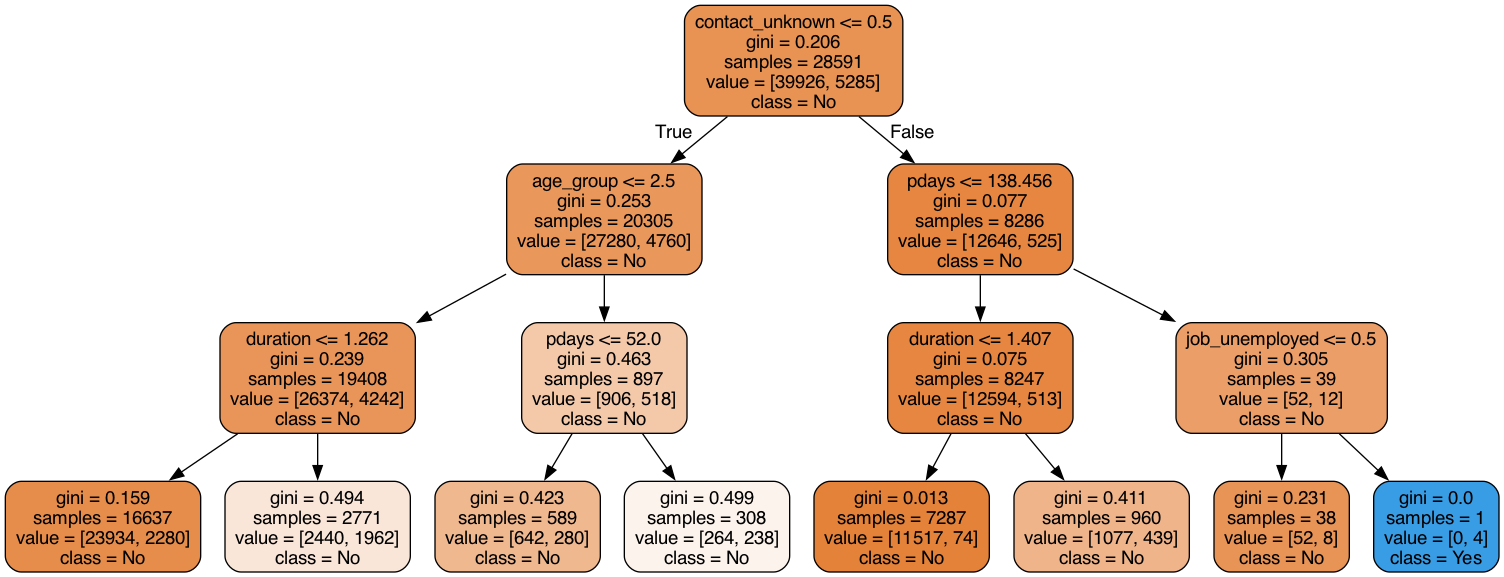

In [126]:
rfc_over = RandomForestClassifier(bootstrap = True, class_weight = None, criterion = 'gini', max_depth = 3, 
                                   max_features = 'auto', max_leaf_nodes = None, min_impurity_decrease = 0.0,
                                   min_samples_leaf = 1, min_samples_split = 2,
                                   min_weight_fraction_leaf = 0.0, n_estimators = 50, n_jobs = -1, 
                                   oob_score = False, random_state = 42, verbose = 0, warm_start = False)
rfc_over.fit(X, y)

random_forest_tree = open('random_forest.dot','w')
dot_data = export_graphviz(rfc_over.estimators_[0], out_file = random_forest_tree, feature_names = list(X_train), class_names = ['No', 'Yes'], rounded = True, proportion = False, filled = True)
random_forest_tree.close()

retCode = system("dot -Tpng random_forest.dot -o random_forest.png")
if(retCode>0):
    print("system command returning error: "+str(retCode))
else:
    display(Image("random_forest.png"))

Feature Importance for Random Forest Classifier  ----------------------------------------------------------------------------


<AxesSubplot:>

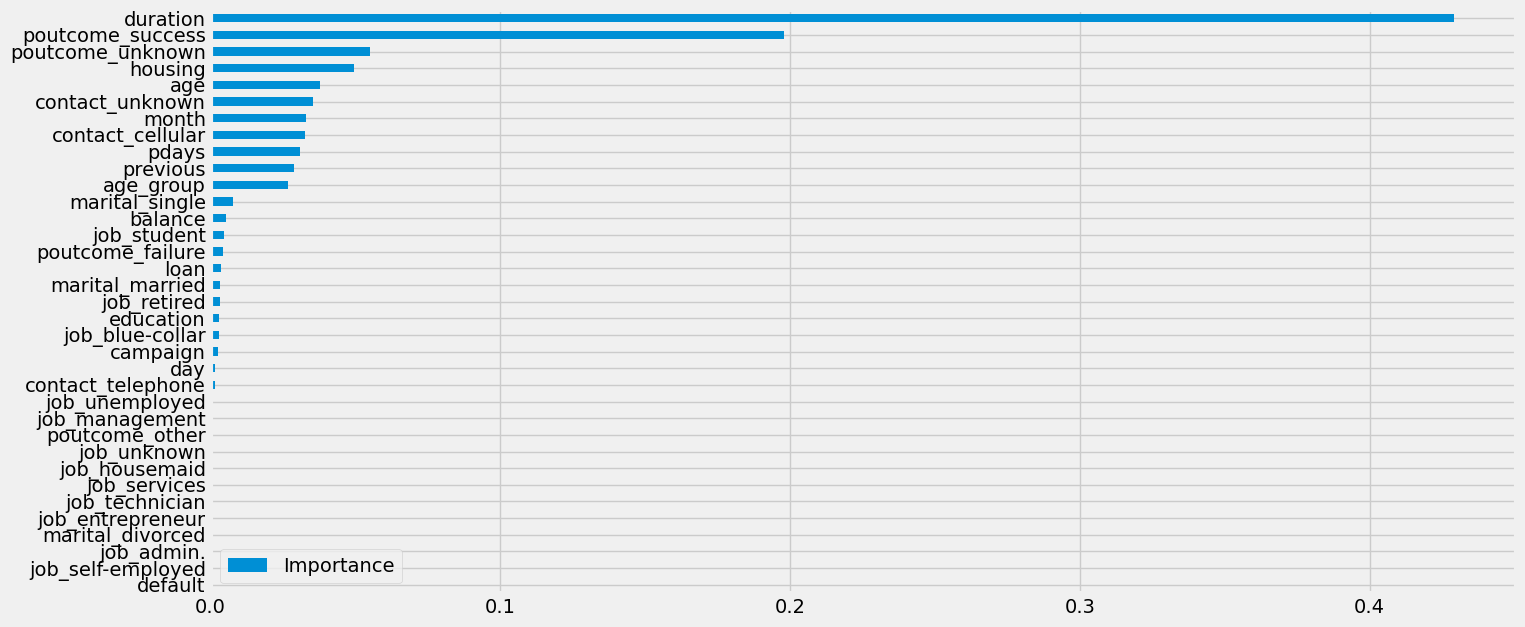

In [127]:
print('Feature Importance for Random Forest Classifier ', '--'*38)
feature_importances = pd.DataFrame(rfc_over.feature_importances_, index = X.columns, 
                                   columns=['Importance']).sort_values('Importance', ascending = True)
feature_importances.sort_values(by = 'Importance', ascending = True).plot(kind = 'barh', figsize = (15, 7.2))

<a id='mr'></a>
### Comparing model results

In [133]:
print('Conditional Formatting on the scores dataframe ', '--'*39)
display(df.style.background_gradient(cmap=sns.light_palette("green", as_cmap=True)))

Conditional Formatting on the scores dataframe  ------------------------------------------------------------------------------


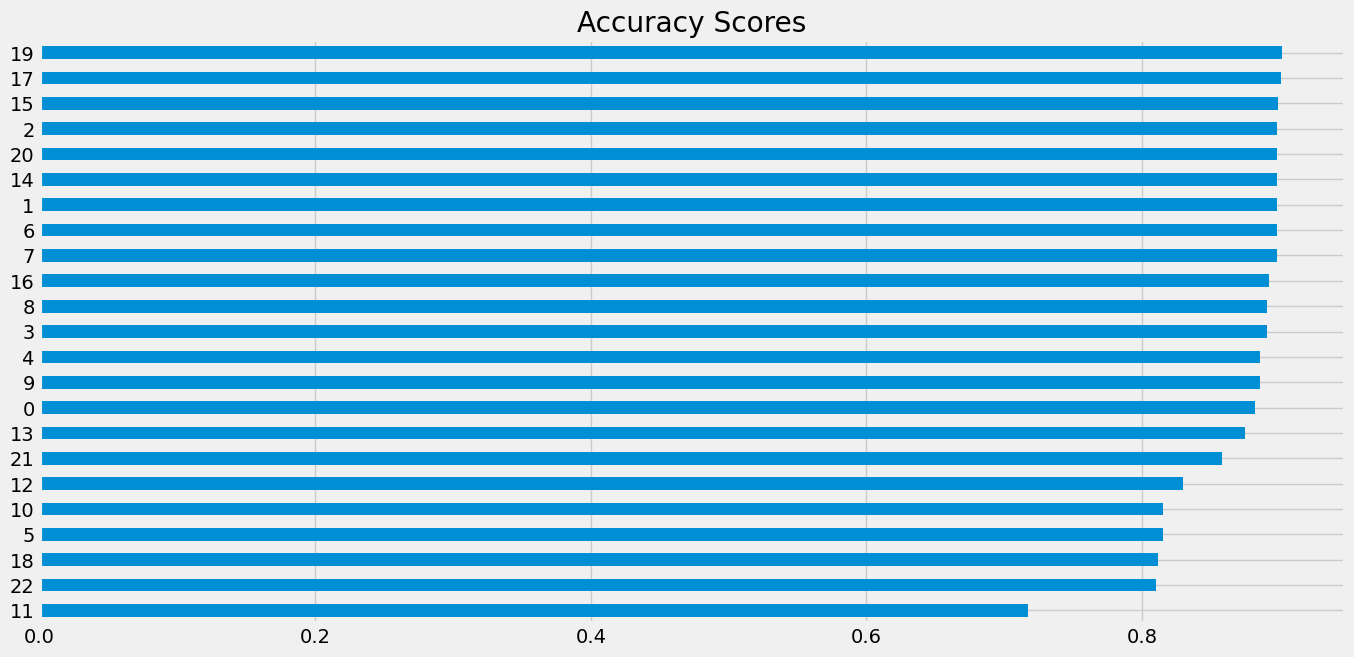

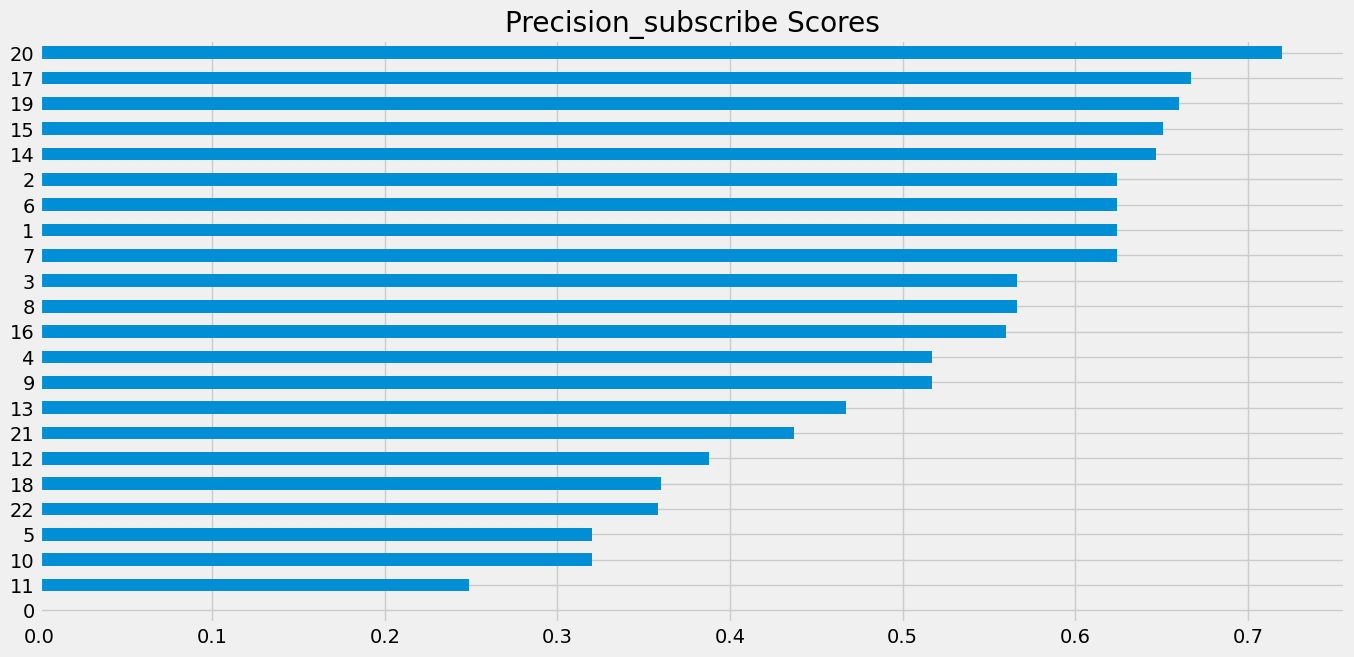

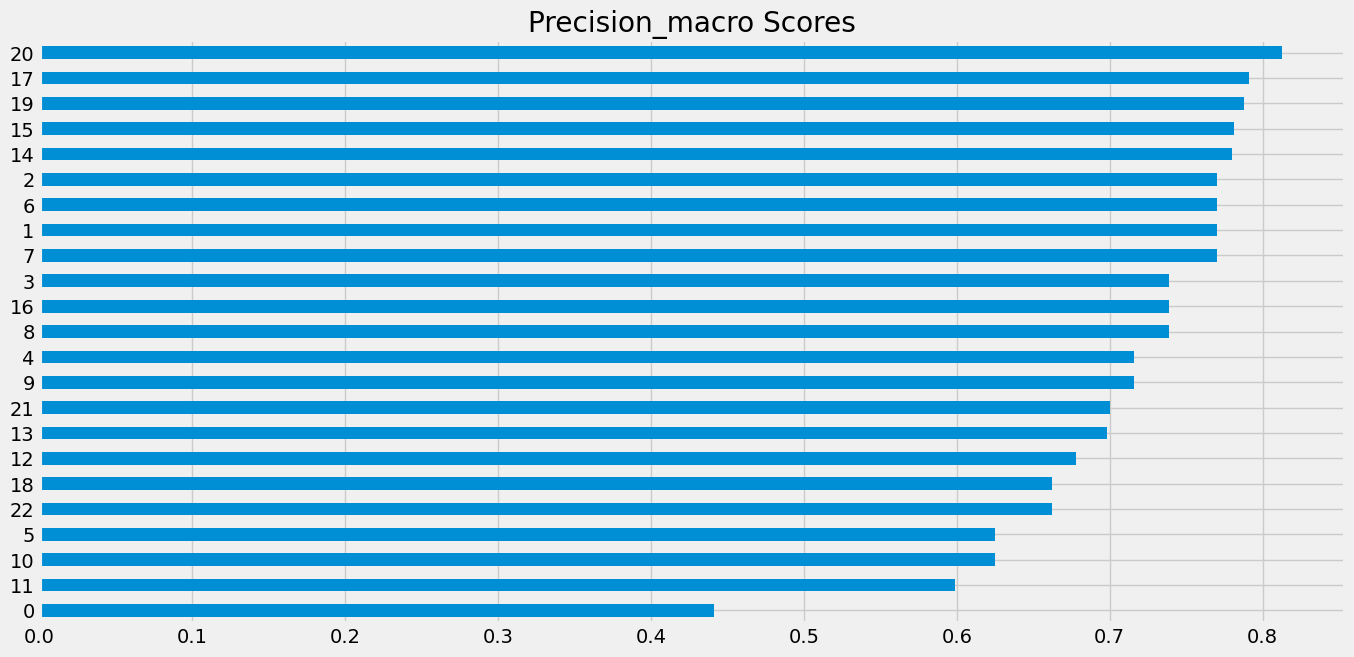

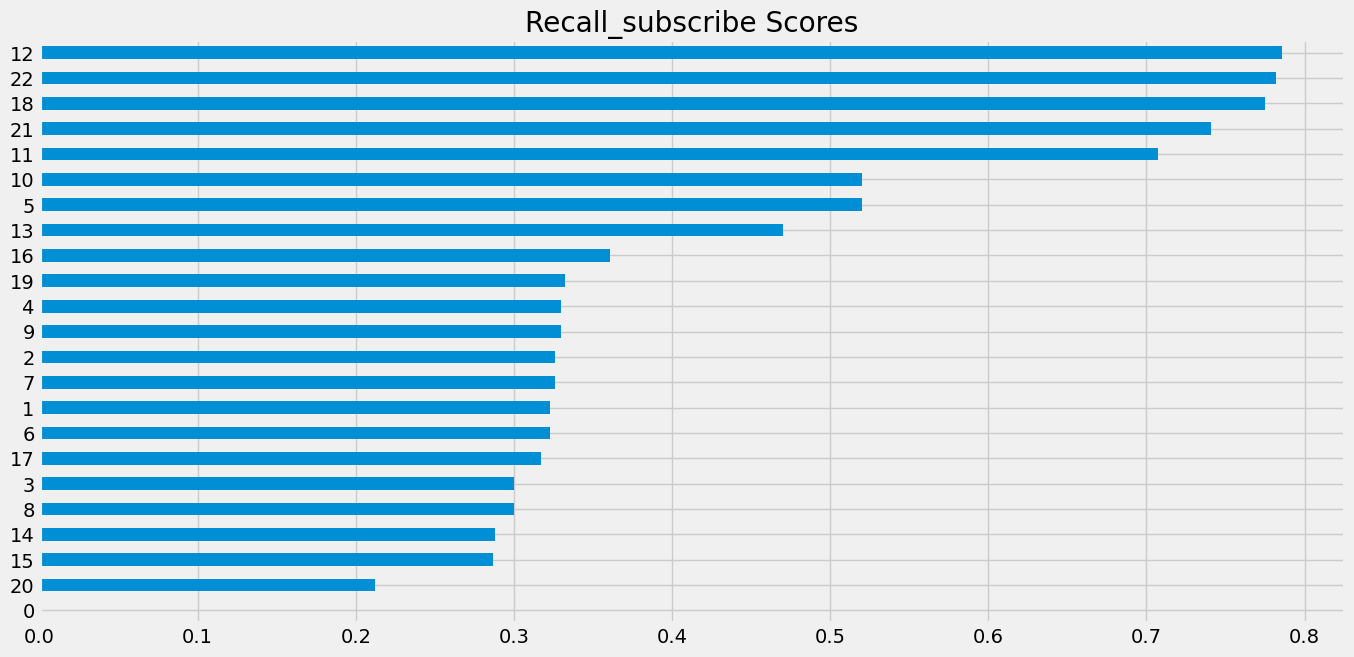

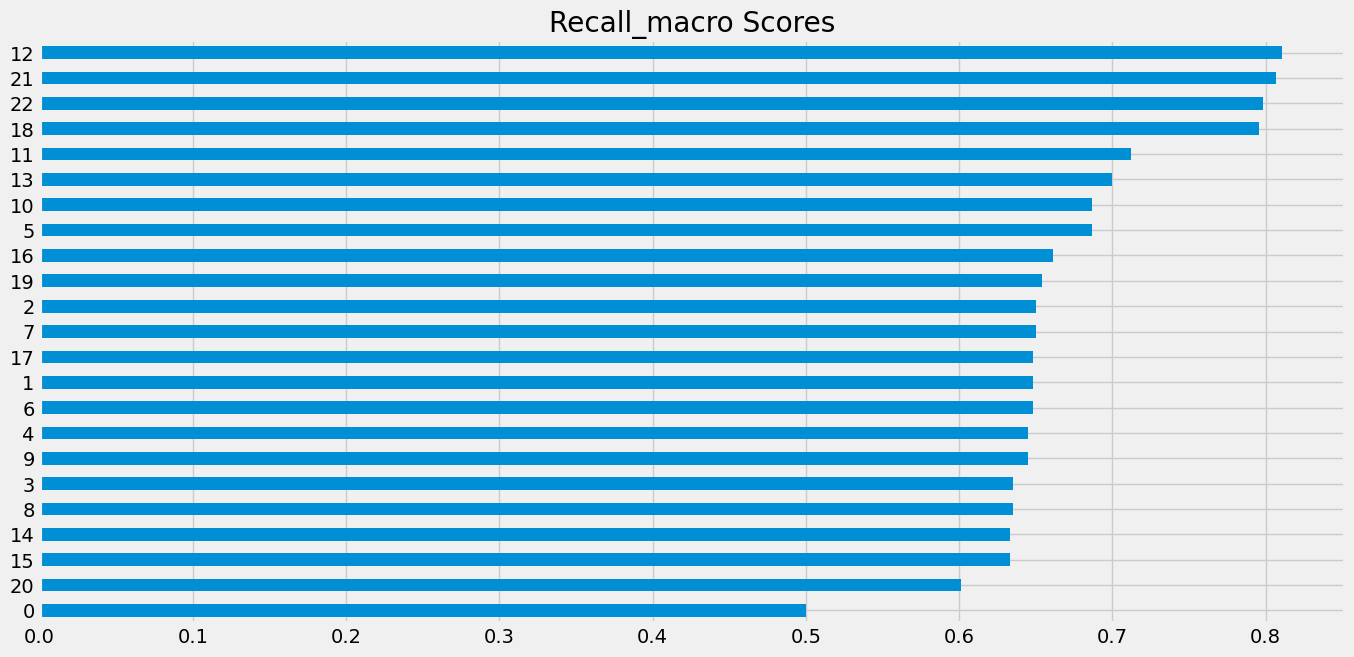

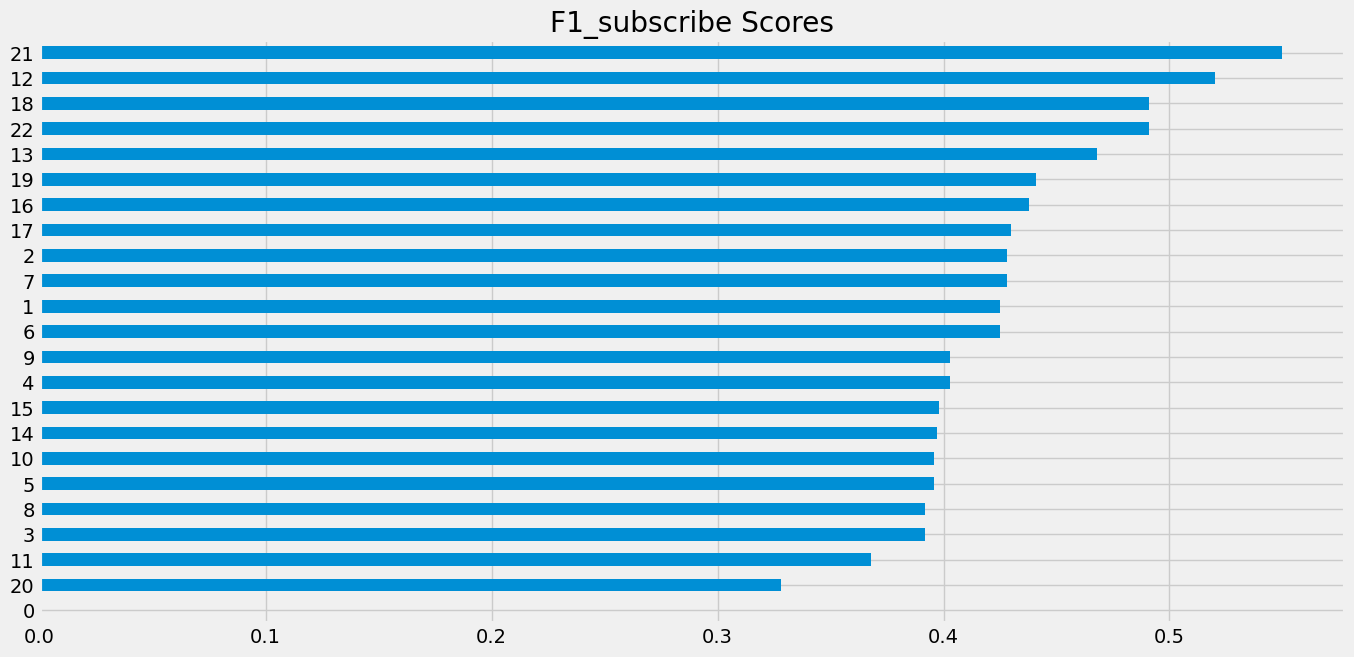

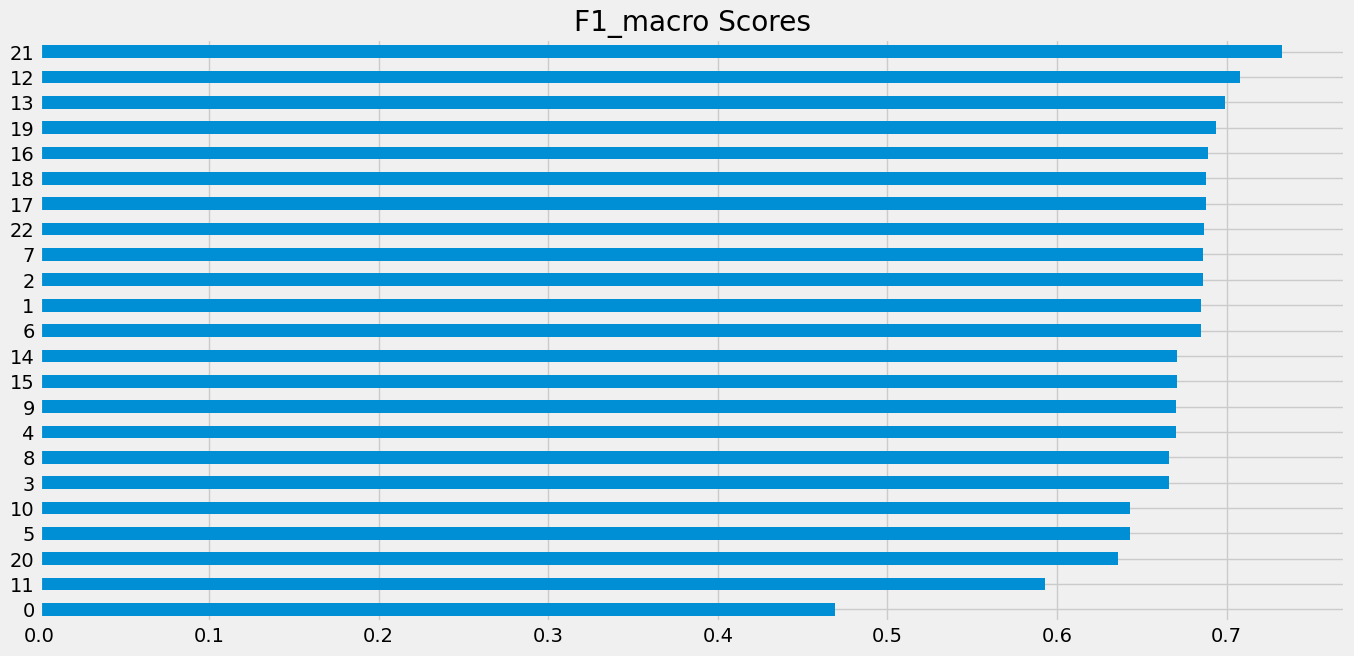

In [134]:
for i, types in enumerate(df.columns):
    temp = df[types]
    plt.figure(i, figsize = (15, 7.2))
    temp.sort_values(ascending = True).plot(kind = 'barh')
    plt.title(f'{types.capitalize()} Scores')
    plt.show()

<a id='conclusion'></a>
### Conclusion

The classification goal is to predict if the client will subscribe (yes/no) a term deposit. 

Most of the ML models works best when the number of classes are in equal proportion since they are designed to maximize accuracy and reduce error. Thus, they do not take into account the class distribution / proportion or balance of classes. In our dataset, the clients subscribing to term deposit (class 'yes' i.e. 1) is 11.7% whereas those about 88.3% of the clients didn't subscribe (class 'no' i.e. 0) to the term deposit.

Building a <span class="girk">DummyClassifier</span>, baseline model, in our case gave an accuracy of 88.2% with zero recall and precision for predicting minority class i.e. where the client subscribed to term deposits. In this cases, important performance measures such as precision, recall, and f1-score would be helpful. We can also calculate this metrics for the minority, positive, class.

* **Precision**: When it predicts the positive result, how often is it correct? i.e. limit the number of false positives.
* **Recall**: When it is actually the positive result, how often does it predict correctly? i.e. limit the number of false negatives.
* **f1-score**: Harmonic mean of precision and recall.

The confusion matrix for class 1 (Subscribed) would look like:

|                        | Predicted: 0 (Not Subscribed) | Predicted: 1 (Subscribed)|
|------------------------|-----------------------------|------------------------|
|**Actual: 0 (Not Subscribed)**| True Negatives              | False Positives        |
|**Actual: 1 (Subscribed)**    | False Negatives             | True Positives         |

* **Precision would tell us cases where actually the client hadn't subscribed to the term deposit but we predicted it as subscribed.**
* **Recall would tell us cases where actually the client had subscribed  to the term deposit but we predicted it as didn't subscribe.**

In our case, it would be recall that would hold more importance then precision. So <span class="mark">choosing recall particularly for class 1 and accuracy as as evaluation metric. Also important would be how is model behaving over the training and test scores across the cross validation sets.</span>

**Modeling** was sub-divided in two phases, in the first phase we applied standard models (with and without the hyperparameter tuning wherever applicable) such as <span class="girk">Logistic Regression, k-Nearest Neighbor and Naive Bayes classifiers</span>. In second phase apply ensemble techniques such as <span class="girk">Decision Tree, Bagging, AdaBoost, Gradient Boosting and Random Forest classifiers</span>. Oversampling the ones with higher accuracy and better recall for subscribe.

**Oversampling**, which is one of common ways to tackle the issue of imbalanced data. Over-sampling refers to various methods that aim to increase the number of instances from the underrepresented class in the data set. Out of the various methods, we chose Synthetic Minority Over-Sampling Technique (SMOTE). SMOTE’s main advantage compared to traditional random naive over-sampling is that by creating synthetic observations instead of reusing existing observations, classifier is less likely to overfit.

**In the first phase (Standard machine learning models vs baseline model)**,
* Best recall for minority class in Naive Bayes of 52.1%
* However better accuracy of 89.9% was observed in logistic regression with hyperparameter tuning
* <span class="mark">Oversampling both, recall of Naive Bayes increases but accuracy drops significantly whereas oversampled logistic regression with hyperparameter tuned model out of which we found a significant improvement of 78.4% in the recall for subscribe against the baseline model, however the accuracy dropped by 5.4%. But again, it's recall that's more important here.</span>

**In the second phase (Ensemble models vs baseline model)**,
* Decision tree classifier gives the best recall score for subscribe class but is also prone to overfitting across the cross validation set. Reducing the max depth did solve the problem of overfitting, but resulted in lower recall subscribe.
* AdaBoost classifier gave the best recall when compared with decision tree reduced max depth, bagging and gradient boosting classifier. Thus, oversampled that which gave a recall of 78.3% for subscribe (yes) class. Best till now among ensembles.
* Tried different methods with random forest i.e. hyperparameter tuning, oversampling and even reducing max depth.. but recall score didn't improve when compared with AdaBoost classifier when oversampled.
* <span class="mark">Thus two better models from this phase are AdaBoost classifier when oversampled with a recall of 78.3%, accuracy of 81.1% and Random Forest classifier when hyperparameter tuned and oversampled, max depth reduced with recall of 78% and accuracy of 81.2%</span>
* **<span class="mark">AdaBoost's recall for subscribe is an improvement of 78.3% from the baseline model while the accuracy did reduce. It's a trade off we have to deal with.</span>**